In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.interpolate import griddata
import xeofs as xe
from geometry_izzyv1 import grad_sphere
from regression_izzyv1 import linregress_3D
import cartopy.crs as ccrs
crs = ccrs.PlateCarree()
import warnings
import os
warnings.filterwarnings('ignore')



In [3]:
# constant
rho_a = 1.225 # air density kg m-3
rho_w = 1000 #fresh water density kh m-3
rho_sw = 1027 # SW max density (https://essd.copernicus.org/articles/14/65/2022/essd-14-65-2022.pdf)

Cd_a = 1.5e-3 # drag coeff air
Cd_w = 5.5e-3 #drag coeff ice-water


In [4]:
gridtype = 'remapcon'

In [133]:
# dot dataset
path = '/Users/iw2g24/PycharmProjects/SSH_project/'
print(path)
ds = xr.open_dataset(path + 'Data/dot_all_30bmedian_goco05c_sig3_1.nc')
print(ds)
# ERA5 remap dataset
ds_era5 = xr.open_dataset(path + 'Data/ERA5_u10v10_Antartica_2000-2023_' + gridtype + '.nc')

/Users/iw2g24/PycharmProjects/SSH_project/
<xarray.Dataset> Size: 109MB
Dimensions:          (longitude: 360, latitude: 64, time: 196, edge_lat: 65,
                      edge_lon: 361)
Coordinates:
  * longitude        (longitude) float64 3kB -179.5 -178.5 ... 178.5 179.5
  * latitude         (latitude) float64 512B -81.75 -81.25 ... -50.75 -50.25
  * time             (time) datetime64[ns] 2kB 2002-07-01 ... 2018-10-01
  * edge_lat         (edge_lat) float64 520B -82.0 -81.5 -81.0 ... -50.5 -50.0
  * edge_lon         (edge_lon) float64 3kB -180.0 -179.0 -178.0 ... 179.0 180.0
Data variables:
    dot              (longitude, latitude, time) float64 36MB ...
    ug               (longitude, latitude, time) float64 36MB ...
    vg               (longitude, latitude, time) float64 36MB ...
    land_mask        (longitude, latitude) float64 184kB ...
    intersat_offset  float64 8B ...
Attributes:
    history:      Created 08/01/2022, 00:5223
    description:  ENVISAT + CryoSat2 altimetry 

<xarray.Dataset> Size: 53MB
Dimensions:    (time: 288, latitude: 360, longitude: 64)
Coordinates:
  * time       (time) datetime64[ns] 2kB 2000-01-01 2000-02-01 ... 2023-12-01
  * latitude   (latitude) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * longitude  (longitude) float64 512B -81.75 -81.25 -80.75 ... -50.75 -50.25
Data variables:
    u10        (time, longitude, latitude) float32 27MB ...
    v10        (time, longitude, latitude) float32 27MB ...
Attributes:
    CDI:          Climate Data Interface version 2.4.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Fri Aug 02 19:47:10 2024: cdo remapcon,grid_horiz.txt ERA5_...
    CDO:          Climate Data Operators version 2.4.0 (https://mpimet.mpg.de...


<xarray.Dataset> Size: 65MB
Dimensions:                 (x: 321, y: 321, time: 52)
Coordinates:
  * x                       (x) float64 3kB -4.011e+06 -3.986e+06 ... 4.011e+06
  * y                       (y) float64 3kB -4.011e+06 -3.986e+06 ... 4.011e+06
  * time                    (time) object 416B 1978-01-01 12:00:00 ... 1978-1...
Data variables:
    crs                     int32 4B ...
    u                       (time, y, x) float32 21MB ...
    v                       (time, y, x) float32 21MB ...
    number_of_observations  (time, y, x) float32 21MB ...
    latitude                (y, x) float32 412kB ...
    longitude               (y, x) float32 412kB ...
Attributes:
    version:       4.1
    release_date:  April 2019
    Conventions:   CF-1.4
    citation:      Tschudi, M. A., Meier, W. N., and Stewart, J. S.: An enhan...
    dataset_doi:   10.5067/INAWUWO7QH7B
<xarray.DataArray 'x' (x: 321)> Size: 3kB
array([-4010804.   , -3985736.475, -3960668.95 , ...,  3960668.95 ,
    

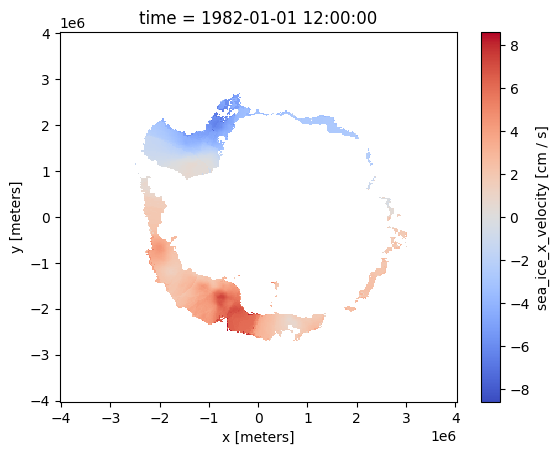

(321,)
(321,)


In [6]:
#sea ice drift data from nsidc
directory = "/Users/iw2g24/PycharmProjects/SSH_project/mca_shared_izzy/si_drift_nsidc_v4/"
ds_example = xr.open_dataset(directory + 'icemotion_weekly_sh_25km_19781105_19781231_v4.1.nc')
print(ds_example)
print(ds_example['x'])

ds_example2 = xr.open_dataset(directory + 'icemotion_weekly_sh_25km_19820101_19821231_v4.1.nc')
print(ds_example2)
print(ds_example2['x'])

variable_name = "u"

# Extract the data array for plotting
data_to_plot = ds_example2[variable_name].isel(time=0)
print("plotted data size",data_to_plot.shape)

# Plot using xarray's built-in method
data_to_plot.plot(cmap="coolwarm")  # Replace 'viridis' with your preferred color map
#plt.title(f"{variable_name} at time {ds_example['time']}")
plt.show()

print(ds_example2["x"].shape)
print(ds_example2["y"].shape)

In [7]:
print(ds_example2["u"].attrs)

{'short_name': 'U', 'long_name': 'sea_ice_x_velocity', 'standard_name': 'sea_ice_x_velocity', 'units': 'cm / s', 'valid_min': -200.0, 'valid_max': 200.0, 'grid_mapping': 'crs', 'comment': 'U is the along-x component of the ice motion.  It is *not* the eastward velocity.'}


In [8]:
print(ds_example2.variables)


Frozen({'x': <xarray.IndexVariable 'x' (x: 321)> Size: 3kB
array([-4010804.   , -3985736.475, -3960668.95 , ...,  3960668.95 ,
        3985736.475,  4010804.   ])
Attributes:
    standard_name:          projection_x_coordinate
    coverage_content_type:  coordinate
    long_name:              x
    units:                  meters
    axis:                   X
    valid_min:              -4023337.7625
    valid_max:              4023337.7625, 'y': <xarray.IndexVariable 'y' (y: 321)> Size: 3kB
array([-4010804.   , -3985736.475, -3960668.95 , ...,  3960668.95 ,
        3985736.475,  4010804.   ])
Attributes:
    standard_name:          projection_y_coordinate
    coverage_content_type:  coordinate
    long_name:              y
    units:                  meters
    axis:                   Y
    valid_min:              -4023337.7625
    valid_max:              4023337.7625, 'time': <xarray.IndexVariable 'time' (time: 52)> Size: 416B
array([cftime.DatetimeJulian(1982, 1, 1, 12, 0, 0, 0, has_

In [9]:
ds_check = xr.open_dataset('si_drift_nsidc.nc')
print(ds_check)

<xarray.Dataset> Size: 5GB
Dimensions:                 (time: 2392, y: 321, x: 321)
Coordinates:
  * x                       (x) float64 3kB -4.011e+06 -3.986e+06 ... 4.011e+06
  * y                       (y) float64 3kB -4.011e+06 -3.986e+06 ... 4.011e+06
  * time                    (time) object 19kB 1978-01-01 12:00:00 ... 2023-1...
Data variables:
    crs                     (time) int32 10kB ...
    u                       (time, y, x) float32 986MB ...
    v                       (time, y, x) float32 986MB ...
    number_of_observations  (time, y, x) float32 986MB ...
    latitude                (time, y, x) float32 986MB ...
    longitude               (time, y, x) float32 986MB ...
Attributes:
    version:       4.1
    release_date:  April 2019
    Conventions:   CF-1.4
    citation:      Tschudi, M. A., Meier, W. N., and Stewart, J. S.: An enhan...
    dataset_doi:   10.5067/INAWUWO7QH7B


In [10]:
ds_nsidc_drift = xr.open_dataset('si_drift_nsidc.nc')
print(ds_nsidc_drift)

<xarray.Dataset> Size: 5GB
Dimensions:                 (time: 2392, y: 321, x: 321)
Coordinates:
  * x                       (x) float64 3kB -4.011e+06 -3.986e+06 ... 4.011e+06
  * y                       (y) float64 3kB -4.011e+06 -3.986e+06 ... 4.011e+06
  * time                    (time) object 19kB 1978-01-01 12:00:00 ... 2023-1...
Data variables:
    crs                     (time) int32 10kB ...
    u                       (time, y, x) float32 986MB ...
    v                       (time, y, x) float32 986MB ...
    number_of_observations  (time, y, x) float32 986MB ...
    latitude                (time, y, x) float32 986MB ...
    longitude               (time, y, x) float32 986MB ...
Attributes:
    version:       4.1
    release_date:  April 2019
    Conventions:   CF-1.4
    citation:      Tschudi, M. A., Meier, W. N., and Stewart, J. S.: An enhan...
    dataset_doi:   10.5067/INAWUWO7QH7B


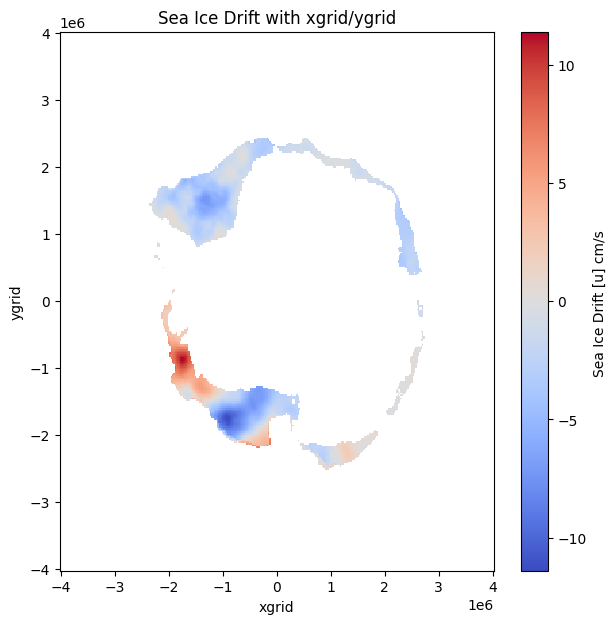

In [11]:
# Plot sea ice drift using x and y coordinates
data_to_plot = ds_nsidc_drift["u"]

plt.figure(figsize=(7,7))
plt.pcolormesh(
    ds_nsidc_drift["x"],
    ds_nsidc_drift["y"],
    data_to_plot.isel(time=1156),
    cmap="coolwarm",
    shading="auto"
)
plt.colorbar(label="Sea Ice Drift [u] cm/s ")
plt.title("Sea Ice Drift with xgrid/ygrid")
plt.xlabel("xgrid")
plt.ylabel("ygrid")
plt.show()


In [12]:
print("Data shape:", ds_nsidc_drift["u"].isel(time=1156).shape)
print("Longitude shape:", ds_nsidc_drift["longitude"].shape)
print("Latitude shape:", ds_nsidc_drift["latitude"].shape)


Data shape: (321, 321)
Longitude shape: (2392, 321, 321)
Latitude shape: (2392, 321, 321)


In [13]:
print(ds_nsidc_drift["longitude"])
print(ds_nsidc_drift["u"].values)

<xarray.DataArray 'longitude' (time: 2392, y: 321, x: 321)> Size: 986MB
[246474072 values with dtype=float32]
Coordinates:
  * x        (x) float64 3kB -4.011e+06 -3.986e+06 ... 3.986e+06 4.011e+06
  * y        (y) float64 3kB -4.011e+06 -3.986e+06 ... 3.986e+06 4.011e+06
  * time     (time) object 19kB 1978-01-01 12:00:00 ... 2023-12-24 12:00:00
Attributes:
    standard_name:  longitude
    units:          degrees_east
[[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan

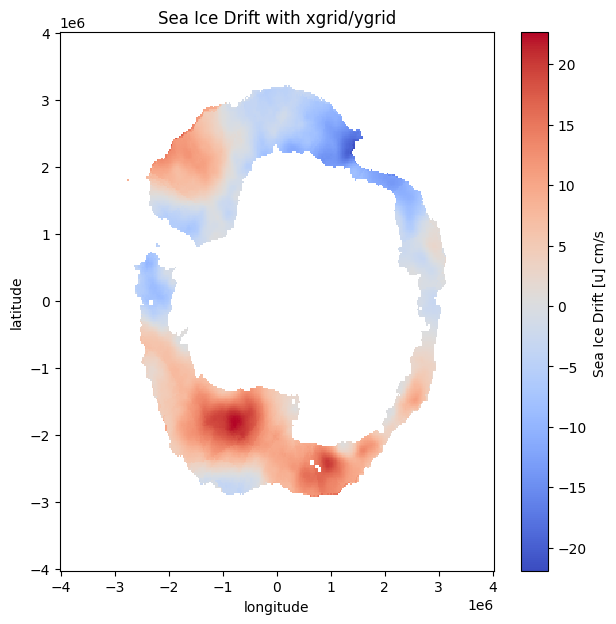

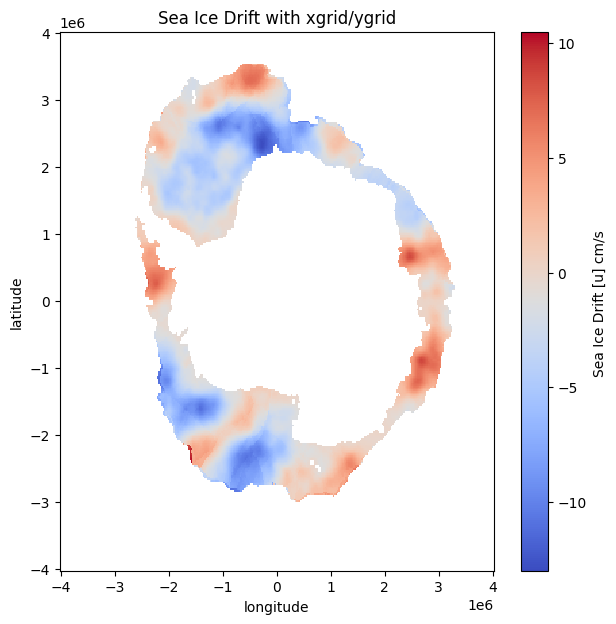

In [14]:
# Plot sea ice drift using x and y coordinates
data_to_plot = ds_nsidc_drift["u"]

plt.figure(figsize=(7,7))
plt.pcolormesh(
    ds_nsidc_drift["x"],
    ds_nsidc_drift["y"],
    data_to_plot.isel(time=1115),
    cmap="coolwarm",
    shading="auto"
)
plt.colorbar(label="Sea Ice Drift [u] cm/s ")
plt.title("Sea Ice Drift with xgrid/ygrid")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.show()

plt.figure(figsize=(7,7))
plt.pcolormesh(
    ds_nsidc_drift["x"],
    ds_nsidc_drift["y"],
    data_to_plot.isel(time=2000),
    cmap="coolwarm",
    shading="auto"
)
plt.colorbar(label="Sea Ice Drift [u] cm/s ")
plt.title("Sea Ice Drift with xgrid/ygrid")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.show()

In [15]:
print(ds_nsidc_drift["latitude"].dims)
print(ds_nsidc_drift["longitude"].dims)

('time', 'y', 'x')
('time', 'y', 'x')


In [16]:
print(ds_nsidc_drift.values)
print("Lon shape", ds_nsidc_drift['longitude'].shape)
print("Lat shape", ds_nsidc_drift['latitude'].shape)

# Compute the max and min values
lon_values = ds_nsidc_drift['longitude'].values  # Extract as a NumPy array
lon_max = np.max(lon_values)
lon_min = np.min(lon_values)

# Print the results
print(f"Longitude Min: {lon_min}, Longitude Max: {lon_max}")

<bound method Mapping.values of <xarray.Dataset> Size: 5GB
Dimensions:                 (time: 2392, y: 321, x: 321)
Coordinates:
  * x                       (x) float64 3kB -4.011e+06 -3.986e+06 ... 4.011e+06
  * y                       (y) float64 3kB -4.011e+06 -3.986e+06 ... 4.011e+06
  * time                    (time) object 19kB 1978-01-01 12:00:00 ... 2023-1...
Data variables:
    crs                     (time) int32 10kB ...
    u                       (time, y, x) float32 986MB nan nan nan ... nan nan
    v                       (time, y, x) float32 986MB ...
    number_of_observations  (time, y, x) float32 986MB ...
    latitude                (time, y, x) float32 986MB ...
    longitude               (time, y, x) float32 986MB ...
Attributes:
    version:       4.1
    release_date:  April 2019
    Conventions:   CF-1.4
    citation:      Tschudi, M. A., Meier, W. N., and Stewart, J. S.: An enhan...
    dataset_doi:   10.5067/INAWUWO7QH7B>
Lon shape (2392, 321, 321)
Lat shape

In [17]:
print(ds_nsidc_drift["time"].dtype)

object


In [18]:
# Convert time to datetime64[ns] using astype()
ds_nsidc_drift["time"] = ds_nsidc_drift["time"].astype('datetime64[ns]')


In [19]:
print(ds_nsidc_drift["time"].dtype)
time_check = ds_nsidc_drift["time"].values
print(time_check)

datetime64[ns]
['1978-01-01T12:00:00.000000000' '1978-01-08T12:00:00.000000000'
 '1978-01-15T12:00:00.000000000' ... '2023-12-10T12:00:00.000000000'
 '2023-12-17T12:00:00.000000000' '2023-12-24T12:00:00.000000000']


In [20]:
time_nsidc_drift = ds_nsidc_drift['time'].values
print("nsidc drift time", time_nsidc_drift[1274],time_nsidc_drift[2119])

nsidc drift time 2002-07-02T12:00:00.000000000 2018-10-01T12:00:00.000000000


In [21]:
ds_check['u'].shape
ds_check['v'].shape

(2392, 321, 321)

In [22]:
5+5

10

In [23]:
# change coordinates from (lon,lat,time) to (time,lat,lon) as ERA5
lon_dot = ds['longitude'].values; lat_dot = ds['latitude'].values
dot_all = ds['dot'].values
dot = np.zeros((dot_all.shape[2], dot_all.shape[1], dot_all.shape[0]))
for t in range(0,dot_all.shape[2]):
    for i in range(0,dot_all.shape[1]):
        for j in range(0,dot_all.shape[0]):
            dot[t,i,j] = dot_all[j,i,t].copy()
seamask = dot[0].copy()/dot[0]
seamask[seamask == 0] = np.nan
del dot_all

In [24]:
# make lon lat 2d
llon = np.zeros((dot.shape[1],dot.shape[2]))
for i in range(0,dot.shape[1]):
    llon[i,:] = lon_dot
llat = np.zeros((dot.shape[1],dot.shape[2]))
for i in range(0,dot.shape[2]):
    llat[:,i] = lat_dot

In [25]:
print(dot.shape)
print(llon.shape)
print(llat.shape)
print(dot[0].shape)

(196, 64, 360)
(64, 360)
(64, 360)
(64, 360)


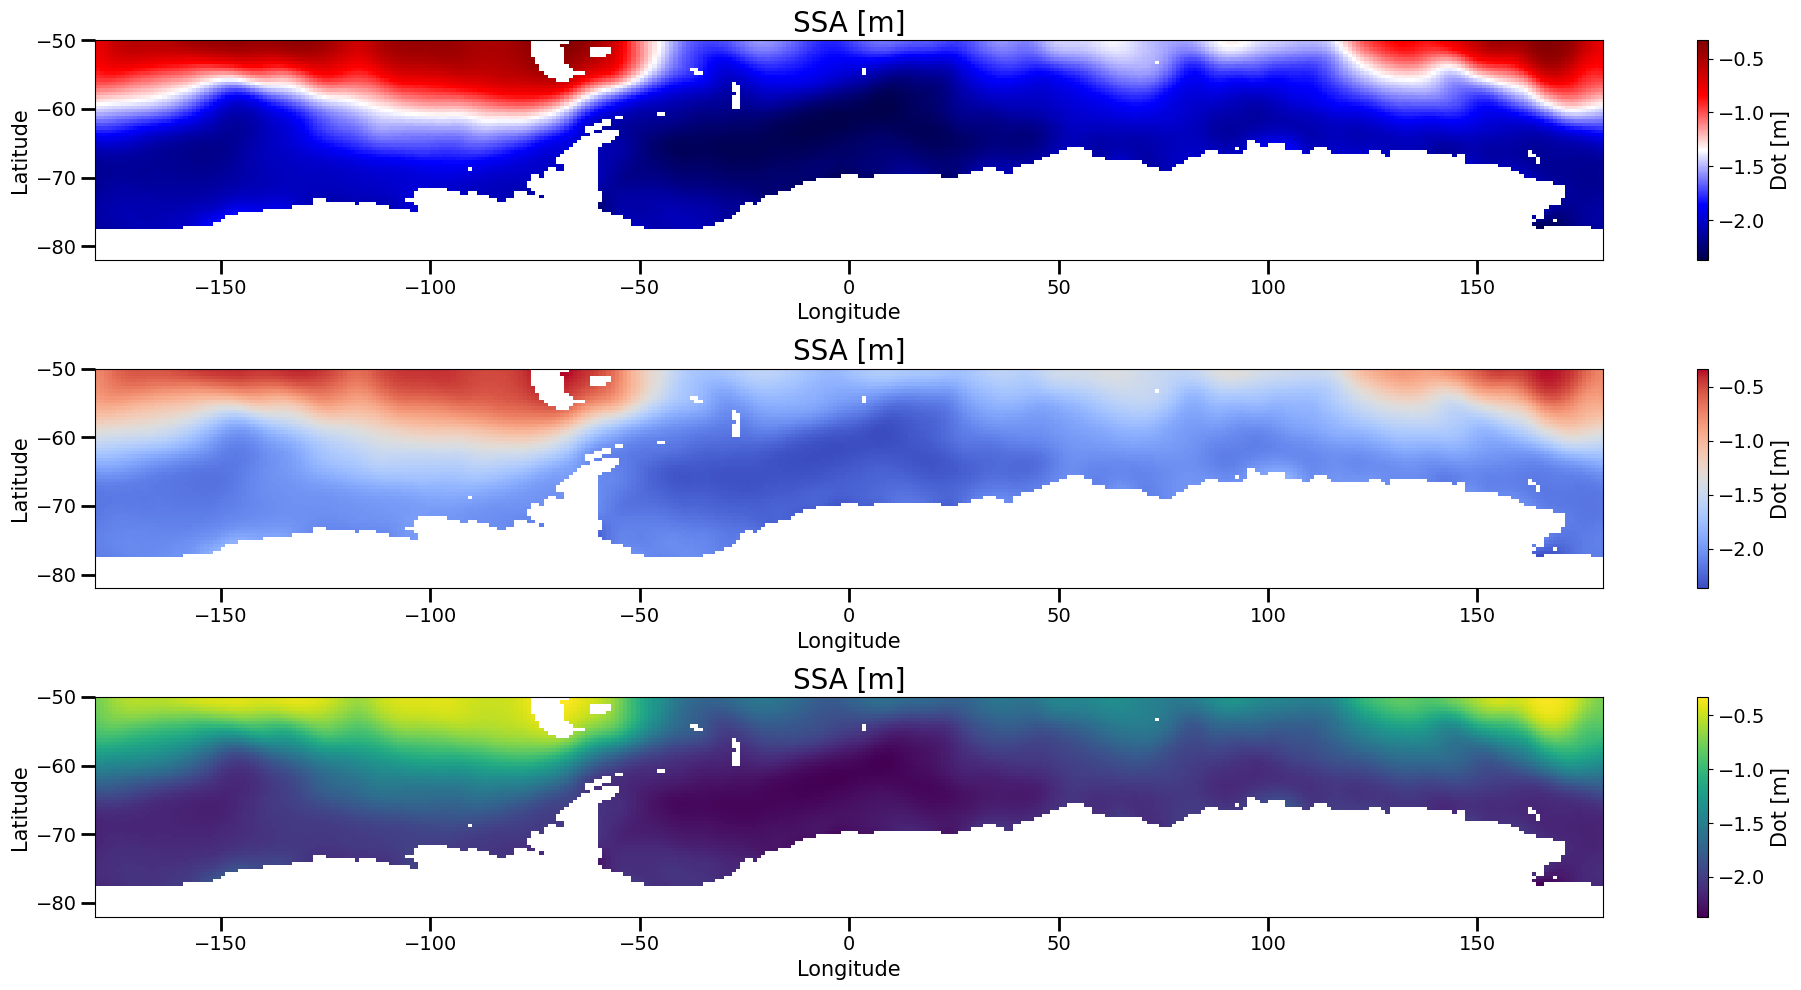

In [26]:
#plot dot with different colour schemes
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 10))

pc1 = axes[0].pcolormesh(llon,llat,dot[0], cmap='seismic')
axes[0].tick_params(axis='both', which='major', length=10, width=2, labelsize=14)
axes[0].set_title('SSA [m]', fontsize=20)
axes[0].set_xlabel('Longitude', fontsize=15)
axes[0].set_ylabel('Latitude', fontsize=15)
cbar1 = fig.colorbar(pc1, ax=axes[0])
cbar1.set_label('Dot [m]', fontsize=15)
cbar1.ax.tick_params(labelsize=14)

pc2 = axes[1].pcolormesh(llon,llat,dot[0], cmap='coolwarm')
axes[1].tick_params(axis='both', which='major', length=10, width=2, labelsize=14)
axes[1].set_title('SSA [m]', fontsize=20)
axes[1].set_xlabel('Longitude', fontsize=15)
axes[1].set_ylabel('Latitude', fontsize=15)
cbar2 = fig.colorbar(pc2, ax=axes[1])
cbar2.set_label('Dot [m]', fontsize=15)
cbar2.ax.tick_params(labelsize=14)

pc3 = axes[2].pcolormesh(llon,llat,dot[0], cmap='viridis')
axes[2].tick_params(axis='both', which='major', length=10, width=2, labelsize=14)
axes[2].set_title('SSA [m]', fontsize=20)
axes[2].set_xlabel('Longitude', fontsize=15)
axes[2].set_ylabel('Latitude', fontsize=15)
cbar3 = fig.colorbar(pc3, ax=axes[2])
cbar3.set_label('Dot [m]', fontsize=15)
cbar3.ax.tick_params(labelsize=14)

plt.tight_layout()
plt.show()

In [27]:
# time
time_era5 = ds_era5['time'].values
time_dot = ds['time'].values
time_nsidc_drift = ds_nsidc_drift['time'].values

In [28]:
time_dot_array = np.array(time_dot, dtype='datetime64[ns]')
time_nsidc_array = np.array(time_nsidc_drift, dtype='datetime64[ns]')

indices_dot_nsidc = np.where(np.isin(time_nsidc_array, time_dot_array))
print(indices_dot_nsidc)

(array([], dtype=int64),)


In [29]:
#print(time_era5)
print("dot time", time_dot[0],time_dot[-1])
print("era5 time", time_era5[30],time_era5[225])
print("nsidc drift time", time_nsidc_drift[1274],time_nsidc_drift[2119])

print(225-30)
2219-1274

dot time 2002-07-01T00:00:00.000000000 2018-10-01T00:00:00.000000000
era5 time 2002-07-01T00:00:00.000000000 2018-10-01T00:00:00.000000000
nsidc drift time 2002-07-02T12:00:00.000000000 2018-10-01T12:00:00.000000000
195


945

In [30]:
print(type(ds_nsidc_drift.indexes['time']))  # Should show CFTimeIndex

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [31]:
# Check the time index type
print(type(ds_nsidc_drift.indexes['time']))  # Should show CFTimeIndex

# Check the type of the current time index
if isinstance(ds_nsidc_drift.indexes['time'], xr.CFTimeIndex):
    print("Converting CFTimeIndex to DatetimeIndex...")

    # Convert CFTimeIndex to DatetimeIndex
    datetimeindex = ds_nsidc_drift.indexes['time'].to_datetimeindex()

    # Replace the time coordinate with the new DatetimeIndex
    ds_nsidc_drift = ds_nsidc_drift.assign_coords(time=datetimeindex)

    # Verify the new time coordinate type
    print("Updated time index type:", type(ds_nsidc_drift.indexes['time']))  # Should now show DatetimeIndex
    print("Updated time coordinate values:")
    print(ds_nsidc_drift['time'])
else:
    print("The time index is already a DatetimeIndex or incompatible type.")
    print("Current time index type:", type(ds_nsidc_drift.indexes['time']))


<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
The time index is already a DatetimeIndex or incompatible type.
Current time index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [32]:
print(ds_nsidc_drift['latitude'].dims)  # Check dimension names
print(ds_nsidc_drift['longitude'].dims)




('time', 'y', 'x')
('time', 'y', 'x')


In [33]:
import pandas as pd
import xarray as xr

# Convert the time coordinate to pandas DatetimeIndex
time_index = pd.to_datetime(ds_nsidc_drift['time'].values)

# Extract latitude and longitude at the first time step (removing time dependency)
latitude = ds_nsidc_drift['latitude'].isel(time=0)
longitude = ds_nsidc_drift['longitude'].isel(time=0)

# Lists to store the first date of each month and the averages
monthly_averages_u = []
monthly_averages_v = []
new_month = []

# Iterate through the datetime array to group by month
for current_month in time_index.to_period('M').unique():  # Loop through each unique month
    # Get the indices for the current month
    month_mask = time_index.to_period('M') == current_month

    # Select the data for the current month and average across time
    monthly_u = ds_nsidc_drift['u'][month_mask].mean(dim='time')  # Average u
    monthly_v = ds_nsidc_drift['v'][month_mask].mean(dim='time')  # Average v

    # Store the monthly averages
    monthly_averages_u.append(monthly_u)
    monthly_averages_v.append(monthly_v)

    # Store the first date of the current month (arbitrary time step)
    new_month.append(current_month.start_time)

# Create a new time coordinate with the first of each month
new_time = pd.to_datetime(new_month)

# Create new xarray DataArrays for the averaged u and v values
monthly_avg_u = xr.DataArray(
    monthly_averages_u,
    dims=("time", "y", "x"),
    coords={
        "time": new_time,
        "latitude": latitude,  # Use fixed latitude without time dimension
        "longitude": longitude,  # Use fixed longitude without time dimension
    },
    name="u",  # Keeping the original name for u
)

monthly_avg_v = xr.DataArray(
    monthly_averages_v,
    dims=("time", "y", "x"),
    coords={
        "time": new_time,
        "latitude": latitude,  # Use fixed latitude without time dimension
        "longitude": longitude,  # Use fixed longitude without time dimension
    },
    name="v",  # Keeping the original name for v
)

# Create a new Dataset with both monthly average u and v
subset_ds = xr.Dataset(
    {
        "u": monthly_avg_u,  # Storing monthly averaged u
        "v": monthly_avg_v,  # Storing monthly averaged v
    }
)

# Verify the new dataset
print(subset_ds)


<xarray.Dataset> Size: 456MB
Dimensions:    (time: 552, y: 321, x: 321)
Coordinates:
  * time       (time) datetime64[ns] 4kB 1978-01-01 1978-02-01 ... 2023-12-01
    latitude   (y, x) float32 412kB -37.14 -37.31 -37.49 ... -37.31 -37.14
    longitude  (y, x) float32 412kB -135.0 -135.2 -135.4 ... 44.64 44.82 45.0
Dimensions without coordinates: y, x
Data variables:
    u          (time, y, x) float32 228MB nan nan nan nan ... nan nan nan nan
    v          (time, y, x) float32 228MB nan nan nan nan ... nan nan nan nan


In [34]:
print(ds_nsidc_drift['time'].shape)
print(ds_nsidc_drift['u'].shape)
print(subset_ds['time'].shape)
print(subset_ds['u'].shape)

(2392,)
(2392, 321, 321)
(552,)
(552, 321, 321)


In [35]:
first_dates_array_formatted = pd.Series(subset_ds['time'].values)

In [36]:
print(ds_nsidc_drift.dims)
print(ds_nsidc_drift.coords)
print(ds_nsidc_drift.var)

print(subset_ds.dims)
print(subset_ds.coords)
print(subset_ds.var)

FrozenMappingWarningOnValuesAccess({'time': 2392, 'y': 321, 'x': 321})
Coordinates:
  * x        (x) float64 3kB -4.011e+06 -3.986e+06 ... 3.986e+06 4.011e+06
  * y        (y) float64 3kB -4.011e+06 -3.986e+06 ... 3.986e+06 4.011e+06
  * time     (time) datetime64[ns] 19kB 1978-01-01T12:00:00 ... 2023-12-24T12...
<bound method DatasetAggregations.var of <xarray.Dataset> Size: 5GB
Dimensions:                 (time: 2392, y: 321, x: 321)
Coordinates:
  * x                       (x) float64 3kB -4.011e+06 -3.986e+06 ... 4.011e+06
  * y                       (y) float64 3kB -4.011e+06 -3.986e+06 ... 4.011e+06
  * time                    (time) datetime64[ns] 19kB 1978-01-01T12:00:00 .....
Data variables:
    crs                     (time) int32 10kB ...
    u                       (time, y, x) float32 986MB nan nan nan ... nan nan
    v                       (time, y, x) float32 986MB ...
    number_of_observations  (time, y, x) float32 986MB ...
    latitude                (time, y, x) fl

In [37]:
time_dot_array = np.array(time_dot, dtype='datetime64[ns]')
#time_nsidc_array = np.array(first_dates_array_formatted, dtype='datetime64[ns]')
time_subset_array = np.array(subset_ds['time'], dtype='datetime64[ns]')

indices_dot_nsidc = np.where(np.isin(time_subset_array, time_dot_array))
print(indices_dot_nsidc)
#print(time_era5)
print("dot time", time_dot[0], time_dot[-1])
print("era5 time", time_era5[30], time_era5[225])
print("nsidc drift time", first_dates_array_formatted[294], first_dates_array_formatted[489])

print(225 - 30)
489-294

(array([294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306,
       307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319,
       320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332,
       333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345,
       346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358,
       359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371,
       372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384,
       385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397,
       398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410,
       411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423,
       424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436,
       437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449,
       450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462,
       463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 4

195

In [38]:
tstart_era5 = 30
tend_era5 = 226 # +1 respect cell above

tstart_nsidc = 294
tend_nsidc = 490 #+1 respect cell above

In [39]:
# select sea ice drift u
seaice_drift_u = subset_ds['u'][tstart_nsidc:tend_nsidc].values
print(seaice_drift_u.shape)
print(seaice_drift_u)

# select sea ice drift v
seaice_drift_v = subset_ds['v'][tstart_nsidc:tend_nsidc].values
print(seaice_drift_v.shape)
print(seaice_drift_v)

(196, 321, 321)
[[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 ...

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan n

In [40]:
print(seaice_drift_u.shape)
print(seamask.shape)

(196, 321, 321)
(64, 360)


In [41]:
# DE-TREND DOT

In [42]:
# linear regression in time on each grid point
n,slope,intercept,p_val,r_square,rmse = linregress_3D(dot)
# remove trend for dot
xt = np.zeros(dot.shape)
for t in range(0,dot.shape[0]):
    xt[t] = t
dot_detrended = dot - (slope*xt + intercept)

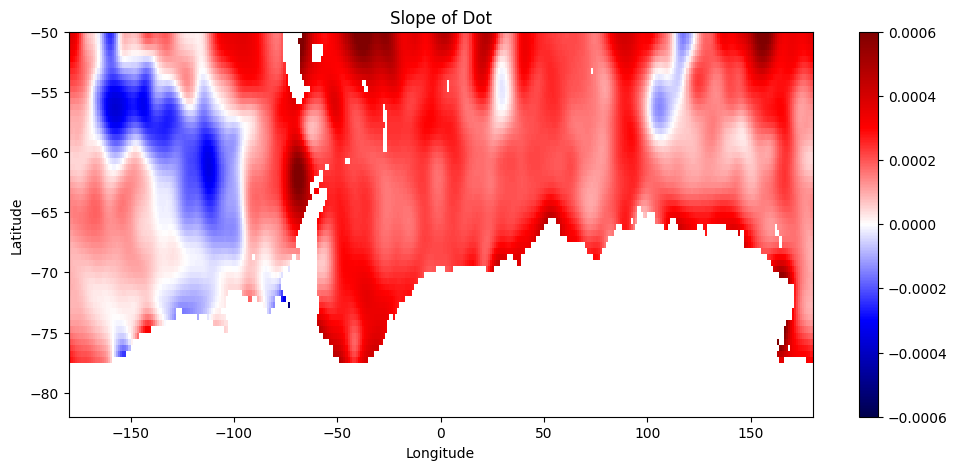

In [43]:
plt.figure(figsize=(12,5))
plt.pcolormesh(llon, llat, slope, vmin=-6e-4, vmax=6e-4, cmap='seismic')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Slope of Dot')
plt.colorbar()


In [44]:
dot_final = dot_detrended.copy()

In [45]:
seaice_u = subset_ds['u'][tstart_nsidc:tend_nsidc].values
seaice_v = subset_ds['v'][tstart_nsidc:tend_nsidc].values

print(seaice_u.shape)
print(seaice_v.shape)

# Assuming 'time_new' is the time coordinate in the dataset
time_values = subset_ds['time'][tstart_nsidc:tend_nsidc].values
print(time_values.shape)  # To verify the shape


(196, 321, 321)
(196, 321, 321)
(196,)


In [46]:
print(seaice_u.shape)
print((seaice_u).shape[0])
print((seaice_u[0]).shape)


(196, 321, 321)
196
(321, 321)


In [47]:
lat_nsidc_drift = subset_ds['latitude'].values  # Shape (time,y, x)
lon_nsidc_drift = subset_ds['longitude'].values # Shape (time,y, x)

print(lon_nsidc_drift.shape)
print(lat_nsidc_drift.shape)

(321, 321)
(321, 321)


In [48]:
print(seaice_drift_u.shape)
print(seaice_drift_u[0].shape)
print(seaice_u.shape[0])

print(seaice_drift_u.shape)
print((seaice_drift_u).shape[0])

(196, 321, 321)
(321, 321)
196
(196, 321, 321)
196


In [49]:
#remap data onto dot grid
# Target grid
lon_target = ds['longitude'].values  # (360,)
lat_target = ds['latitude'].values  # (64,)

# Create an empty list to store regridded data
regridded_data_u = []
regridded_data_v = []
time_steps_list = []


# Loop through each time step of the original sea ice data
for t in range(seaice_drift_u.shape[0]):  # Loop over the time dimension
    # Extracting the sea ice concentration at time t, shape (321, 321)
    seaice_u = seaice_drift_u[t]
    seaice_v = seaice_drift_v[t]

    # Coordinates for the original grid
    lon_seaice = lon_nsidc_drift  # (321, 321)
    lat_seaice = lat_nsidc_drift  # (321, 321)

    # Flatten original grid and sea ice data
    points = np.array([lon_seaice.flatten(), lat_seaice.flatten()]).T  # [lon, lat]
    values_u = seaice_u.flatten()
    values_v = seaice_v.flatten()

    # print(points.shape)
    # print(values.shape)

    # Generate target grid (meshgrid for lon and lat)
    lon_mesh, lat_mesh = np.meshgrid(lon_target, lat_target)  # 2D target grid

    # Interpolate onto the target grid
    seaice_regridded_u = griddata(points, values_u, (lon_mesh, lat_mesh), method='linear')
    seaice_regridded_v = griddata(points, values_v, (lon_mesh, lat_mesh), method='linear')

    # Add regridded data to list (append 2D array for this time step)
    regridded_data_u.append(seaice_regridded_u)
    regridded_data_v.append(seaice_regridded_v)

    # Store the corresponding time value
    time_steps_list.append(time_values[t])  # Add the corresponding time step

# Stack the regridded data along the time dimension
regridded_seaice_drift_u = np.stack(regridded_data_u, axis=0)  # Shape: (time, lat, lon)
regridded_seaice_drift_v = np.stack(regridded_data_v, axis=0)

# Now you can use regridded_data, and time_steps_list to refer to the time dimension
print(f"Regridded data shape u: {regridded_seaice_drift_u.shape}")
print(f"Regridded data shape v: {regridded_seaice_drift_u.shape}")
#print(f"Time steps: {time_steps_list}")


Regridded data shape u: (196, 64, 360)
Regridded data shape v: (196, 64, 360)


In [50]:
print(np.isnan(lon_seaice).sum(), np.isnan(lat_seaice).sum())  # Check if lon/lat have NaNs
print(np.isnan(values_u).sum(), np.isnan(values_v).sum())      # Check if sea ice data has NaNs

0 0
74052 74052


In [51]:
# Create new xarray DataArrays for regridded 'u' and 'v' data
regridded_seaice_da_u = xr.DataArray(
    regridded_seaice_drift_u,
    dims=("time", "lat", "lon"),
    coords={
        "time": time_steps_list,  # Time steps (list of datetime objects)
        "lat": lat_target,  # New latitude grid (64,)
        "lon": lon_target,  # New longitude grid (360,)
    },
    name="seaice_drift_u",  # Variable name for 'u'
)

regridded_seaice_da_v = xr.DataArray(
    regridded_seaice_drift_v,
    dims=("time", "lat", "lon"),
    coords={
        "time": time_steps_list,  # Time steps (list of datetime objects)
        "lat": lat_target,  # New latitude grid (64,)
        "lon": lon_target,  # New longitude grid (360,)
    },
    name="seaice_drift_v",  # Variable name for 'v'
)

# Create a single Dataset with both regridded DataArrays
regridded_seaice_ds = xr.Dataset(
    {
        "seaice_drift_u": regridded_seaice_da_u,
        "seaice_drift_v": regridded_seaice_da_v,
    }
)

# Print dataset to verify
print(regridded_seaice_ds)



<xarray.Dataset> Size: 72MB
Dimensions:         (time: 196, lat: 64, lon: 360)
Coordinates:
  * time            (time) datetime64[ns] 2kB 2002-07-01 ... 2018-10-01
  * lat             (lat) float64 512B -81.75 -81.25 -80.75 ... -50.75 -50.25
  * lon             (lon) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Data variables:
    seaice_drift_u  (time, lat, lon) float64 36MB nan nan nan ... nan nan nan
    seaice_drift_v  (time, lat, lon) float64 36MB nan nan nan ... nan nan nan


<xarray.Dataset> Size: 72MB
Dimensions:         (time: 196, lat: 64, lon: 360)
Coordinates:
  * time            (time) datetime64[ns] 2kB 2002-07-01 ... 2018-10-01
  * lat             (lat) float64 512B -81.75 -81.25 -80.75 ... -50.75 -50.25
  * lon             (lon) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Data variables:
    seaice_drift_u  (time, lat, lon) float64 36MB nan nan nan ... nan nan nan
    seaice_drift_v  (time, lat, lon) float64 36MB nan nan nan ... nan nan nan


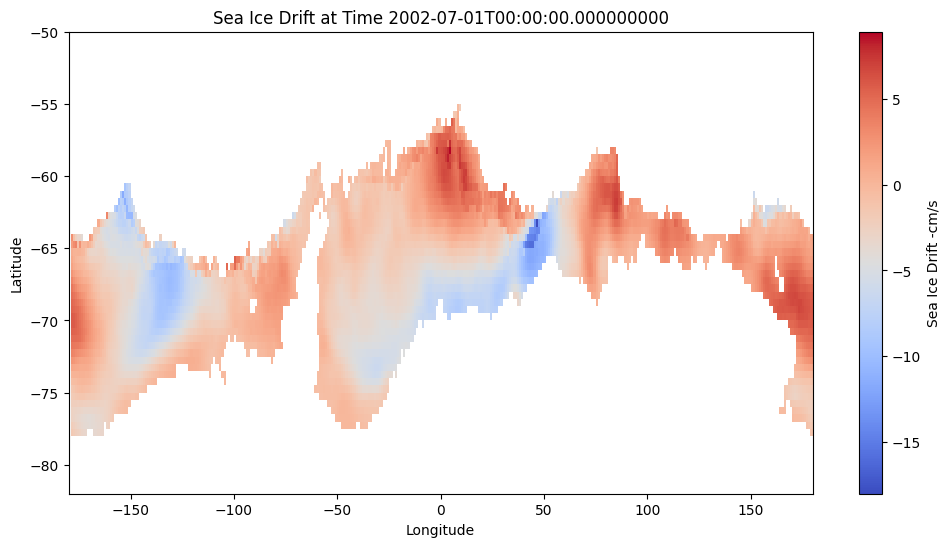

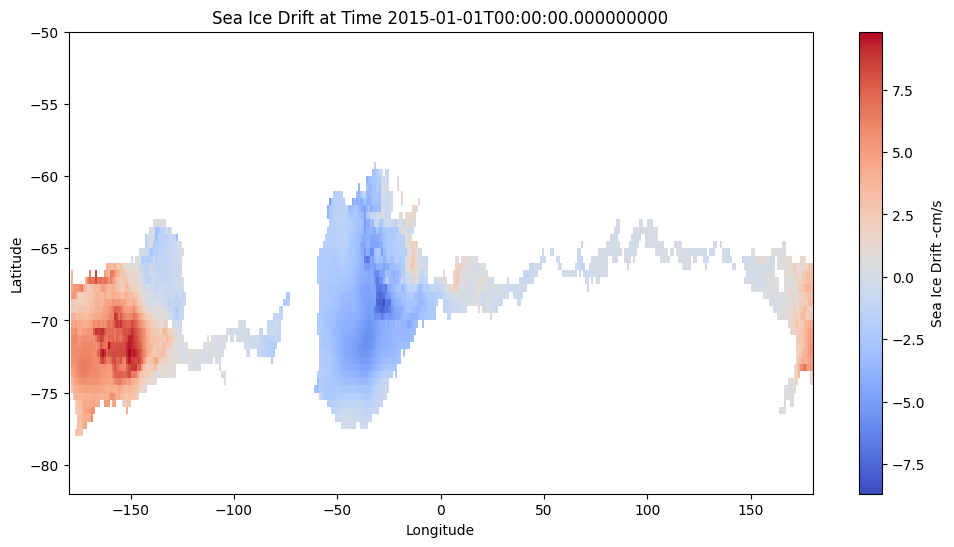

In [52]:
print(regridded_seaice_ds)

# Extract the time, latitude, and longitude coordinates
time_values = regridded_seaice_ds['time'].values
lat_values = regridded_seaice_ds['lat'].values
lon_values = regridded_seaice_ds['lon'].values
time_step = 0

# Create a meshgrid for lat/lon coordinates for plotting
lon_mesh, lat_mesh = np.meshgrid(lon_values, lat_values)

# Plot the sea ice concentration at time step 0 (you can change the time index)
plt.figure(figsize=(12, 6))
plt.pcolormesh(llon, llat, regridded_seaice_ds['seaice_drift_u'].isel(time=time_step), cmap='coolwarm', shading='auto')
plt.colorbar(label='Sea Ice Drift -cm/s')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Sea Ice Drift at Time {time_values[0]}')  # Use time label for title
plt.show()

plt.figure(figsize=(12, 6))
plt.pcolormesh(llon, llat, regridded_seaice_ds['seaice_drift_u'].isel(time=150), cmap='coolwarm', shading='auto')
plt.colorbar(label='Sea Ice Drift -cm/s')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Sea Ice Drift at Time {time_values[150]}')  # Use time label for title
plt.show()

In [53]:
time_step = 0
# Select the data at the specified time step
seaice_drift_u_at_time = regridded_seaice_ds['seaice_drift_u'].isel(time=time_step)
seaice_drift_v_at_time = regridded_seaice_ds['seaice_drift_v'].isel(time=time_step)

# Create the ice mask by dividing by itself and setting zeros to NaN
icemask_u = seaice_drift_u_at_time / seaice_drift_u_at_time
icemask_u = icemask_u.where(icemask_u != 0, np.nan)  # Replace zeros with NaN

icemask_v = seaice_drift_v_at_time / seaice_drift_v_at_time
icemask_v = icemask_v.where(icemask_v != 0, np.nan)  # Replace zeros with NaN



In [54]:
#apply the icemask
# Apply the masks to the u and v components across the entire time dimension
seaice_masked_u = regridded_seaice_ds['seaice_drift_u'] * icemask_u
seaice_masked_v = regridded_seaice_ds['seaice_drift_v'] * icemask_v

# Create a new dataset with masked values
seaice_drift_masked_ds = xr.Dataset(
    {
        'seaice_drift_u_masked': seaice_masked_u,
        'seaice_drift_v_masked': seaice_masked_v
    },
    coords=regridded_seaice_ds.coords
)

# Print the resulting dataset to verify
print(seaice_drift_masked_ds)

<xarray.Dataset> Size: 72MB
Dimensions:                (time: 196, lat: 64, lon: 360)
Coordinates:
  * time                   (time) datetime64[ns] 2kB 2002-07-01 ... 2018-10-01
  * lat                    (lat) float64 512B -81.75 -81.25 ... -50.75 -50.25
  * lon                    (lon) float64 3kB -179.5 -178.5 ... 178.5 179.5
Data variables:
    seaice_drift_u_masked  (time, lat, lon) float64 36MB nan nan nan ... nan nan
    seaice_drift_v_masked  (time, lat, lon) float64 36MB nan nan nan ... nan nan


In [55]:
U_ice = np.sqrt(seaice_masked_u**2. + seaice_masked_v**2.)
print(U_ice.shape)

(196, 64, 360)


In [56]:
#calculate sea ice drift stress
tau_x_sid = rho_sw*Cd_w*U_ice*seaice_masked_u #zonal drift stress
tau_y_sid = rho_sw*Cd_w*U_ice*seaice_masked_v #meridional drift stress

print(tau_x_sid.shape)
print(llon.shape)



(196, 64, 360)
(64, 360)


In [57]:
#calculate sea ice drift curl
sid_curl = np.zeros(tau_x_sid.shape)

for t in range(0, dot.shape[0]):
    dtaux_dx, dtaux_dy = grad_sphere(tau_x_sid[t], llon, llat)
    dtauy_dx, dtauy_dy = grad_sphere(tau_y_sid[t], llon, llat)
    sid_curl[t] = dtauy_dx - dtaux_dy

In [58]:
# Detrend sea ice drift components (u and v)

# Extract the sea ice drift components
seaice_drift_u = regridded_seaice_ds['seaice_drift_u']
seaice_drift_v = regridded_seaice_ds['seaice_drift_v']

# Linear regression in time on each grid point for 'u'
n_si_u, slope_si_u, intercept_si_u, p_val_si_u, r_square_si_u, rmse_si_u = linregress_3D(seaice_drift_u)
# Linear regression in time on each grid point for 'v'
n_si_v, slope_si_v, intercept_si_v, p_val_si_v, r_square_si_v, rmse_si_v = linregress_3D(seaice_drift_v)

# Remove trend for 'u'
xt_si = np.zeros(seaice_drift_u.shape)
for t in range(0, seaice_drift_u.shape[0]):
    xt_si[t] = t

seaice_drift_u_detrended = seaice_drift_u - (slope_si_u * xt_si + intercept_si_u)
seaice_drift_v_detrended = seaice_drift_v - (slope_si_v * xt_si + intercept_si_v)

# Squeeze slopes to remove singleton dimensions
slope_si_u = slope_si_u.squeeze()
slope_si_v = slope_si_v.squeeze()

# Verify shapes
print("Longitude shape:", lon_mesh.shape)
print("Latitude shape:", lat_mesh.shape)
print("Data shape (slope_si_u):", slope_si_u.shape)
print("Data shape (slope_si_v):", slope_si_v.shape)

Longitude shape: (64, 360)
Latitude shape: (64, 360)
Data shape (slope_si_u): (64, 360)
Data shape (slope_si_v): (64, 360)


In [59]:
print('slope v range: ', slope_si_v.min(), slope_si_v.max(), slope_si_v.mean(), slope_si_v.std())
print('slope u range: ', slope_si_u.min(), slope_si_u.max(), slope_si_u.mean(), slope_si_u.std())

print('seaice drift u range:', seaice_drift_u.min(), seaice_drift_u.max())
print('seaice drift v range:', seaice_drift_v.min(), seaice_drift_v.max())


slope v range:  nan nan nan nan
slope u range:  nan nan nan nan
seaice drift u range: <xarray.DataArray 'seaice_drift_u' ()> Size: 8B
array(-29.32073657) <xarray.DataArray 'seaice_drift_u' ()> Size: 8B
array(27.16314453)
seaice drift v range: <xarray.DataArray 'seaice_drift_v' ()> Size: 8B
array(-23.26707275) <xarray.DataArray 'seaice_drift_v' ()> Size: 8B
array(28.42704008)


In [60]:
temporal_variance_u = seaice_drift_u.var(axis=0)
temporal_variance_v = seaice_drift_v.var(axis=0)

print("Number of grid points with zero variance in u:", (temporal_variance_u == 0).sum())
print("Number of grid points with zero variance in v:", (temporal_variance_v == 0).sum())
print('number of grid point u: ', seaice_drift_u.size)
print('number of grid point v: ', seaice_drift_v.size)


Number of grid points with zero variance in u: <xarray.DataArray 'seaice_drift_u' ()> Size: 8B
array(195)
Number of grid points with zero variance in v: <xarray.DataArray 'seaice_drift_v' ()> Size: 8B
array(195)
number of grid point u:  4515840
number of grid point v:  4515840


In [61]:
#detrend seaice drift for masked ds

seaice_drift_u_masked = seaice_drift_masked_ds['seaice_drift_u_masked']
seaice_drift_v_masked = seaice_drift_masked_ds['seaice_drift_v_masked']

# Linear regression in time on each grid point for 'u'
n_si_u_mask, slope_si_u_mask, intercept_si_u_mask, p_val_si_u_mask, r_square_si_u_mask, rmse_si_u_mask = linregress_3D(seaice_drift_u_masked)
# Linear regression in time on each grid point for 'v'
n_si_v_mask, slope_si_v_mask, intercept_si_v_mask, p_val_si_v_mask, r_square_si_v_mask, rmse_si_v_mask = linregress_3D(seaice_drift_v_masked)

# Remove trend for 'u'
xt_si_mask = np.zeros(seaice_drift_u_masked.shape)
for t in range(0, seaice_drift_u_masked.shape[0]):
    xt_si_mask[t] = t

seaice_drift_u_detrended_masked = seaice_drift_u_masked - (slope_si_u_mask * xt_si_mask + intercept_si_u_mask)
seaice_drift_v_detrended_masked = seaice_drift_v_masked - (slope_si_v_mask * xt_si_mask + intercept_si_v_mask)

# Squeeze slopes to remove singleton dimensions
slope_si_u_mask = slope_si_u_mask.squeeze()
slope_si_v_mask = slope_si_v_mask.squeeze()

# Verify shapes
print("Longitude shape:", lon_mesh.shape)
print("Latitude shape:", lat_mesh.shape)
print("Data shape (slope_si_u):", slope_si_u_mask.shape)
print("Data (slope_si_v):", slope_si_v_mask.shape)

Longitude shape: (64, 360)
Latitude shape: (64, 360)
Data shape (slope_si_u): (64, 360)
Data (slope_si_v): (64, 360)


In [62]:
#detrend U and sid_curl
n_U,slope_U,intercept_U,p_val_U,r_square_U,rmse_U = linregress_3D(U_ice)
# remove trend for dot
xt_U = np.zeros(U_ice.shape)
for t in range(0,U_ice.shape[0]):
    xt[t] = t
U_detrended = U_ice - (slope_U*xt_U + intercept_U)

#------
n_sid_curl,slope_sid_curl,intercept_sid_curl,p_val_sid_curl,r_square_sid_curl,rmse_sid_curl = linregress_3D(sid_curl)
# remove trend for sid_curl
xt_sid_curl = np.zeros(sid_curl.shape)
for t in range(0,sid_curl.shape[0]):
    xt[t] = t
sid_curl_detrended = sid_curl - (slope_sid_curl*xt_sid_curl + intercept_sid_curl)




In [63]:
# select wind
u10_wsc = ds_era5['u10'][tstart_era5:tend_era5].values
v10_wsc = ds_era5['v10'][tstart_era5:tend_era5].values

# map lat in lat[::-1] when using gridboxmean mapping
# since lat in ERA5 goes from -50 to -80 instead in dot goes from -80 to -50
if gridtype == 'gridboxmean':
    print('you are using ',gridtype)
    u10_wsc = u10_wsc[:,::-1,:]
    v10_wsc = v10_wsc[:,::-1,:]

u10_wsc = u10_wsc*seamask
v10_wsc = v10_wsc*seamask
U_wsc = np.sqrt(u10_wsc**2. + v10_wsc**2.)

In [64]:
print(U_wsc.shape)

(196, 64, 360)


In [65]:
# wind stress
tau_x_wsc = rho_a*Cd_a*U_wsc*u10_wsc #zonal wind
tau_y_wsc = rho_a*Cd_a*U_wsc*v10_wsc #meridional wind

print('zonal wind:', tau_x_wsc)
print('meridional wind:', tau_y_wsc)

zonal wind: [[[       nan        nan        nan ...        nan        nan        nan]
  [       nan        nan        nan ...        nan        nan        nan]
  [       nan        nan        nan ...        nan        nan        nan]
  ...
  [0.02068101 0.01995691 0.01893414 ... 0.02478185 0.02406133 0.02285532]
  [0.02073882 0.02002566 0.01897176 ... 0.02542477 0.02491941 0.02391698]
  [0.02081135 0.01977531 0.01851727 ... 0.02508504 0.02510456 0.0242639 ]]

 [[       nan        nan        nan ...        nan        nan        nan]
  [       nan        nan        nan ...        nan        nan        nan]
  [       nan        nan        nan ...        nan        nan        nan]
  ...
  [0.02263992 0.02283532 0.02308318 ... 0.0202767  0.02100487 0.02146125]
  [0.01919219 0.01941123 0.01973684 ... 0.01726765 0.01758919 0.01786926]
  [0.01712514 0.01781618 0.01820304 ... 0.01602753 0.01570514 0.01575291]]

 [[       nan        nan        nan ...        nan        nan        nan]
  [       

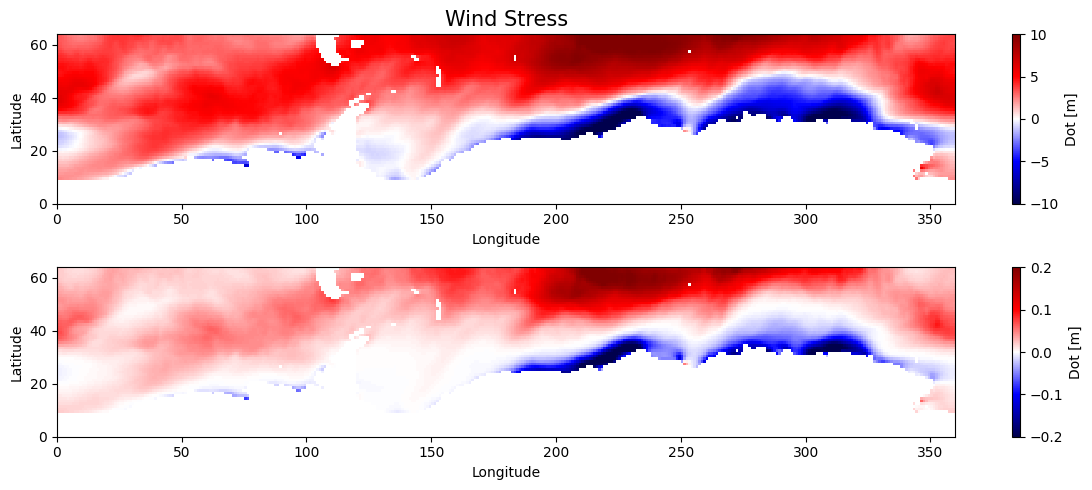

In [66]:
fig = plt.figure(figsize=(12,5))
plt.subplot(2,1,1)
plt.pcolormesh(u10_wsc[0],cmap='seismic',vmin=-10,vmax=10)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Wind Stress', fontsize=15)
cbar1= plt.colorbar()
cbar1.set_label('Dot [m]')
plt.subplot(2,1,2)
plt.pcolormesh(tau_x_wsc[0],cmap='seismic',vmin=-0.2,vmax=0.2)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
cbar2= plt.colorbar()
cbar2.set_label('Dot [m]')


plt.tight_layout()

In [67]:
# wind stress curl
ws_curl = np.zeros(tau_x_wsc.shape)
for t in range(0,dot.shape[0]):
    dtaux_dx, dtaux_dy = grad_sphere(tau_x_wsc[t], llon, llat)
    dtauy_dx, dtauy_dy = grad_sphere(tau_y_wsc[t], llon, llat)
    ws_curl[t] = dtauy_dx - dtaux_dy

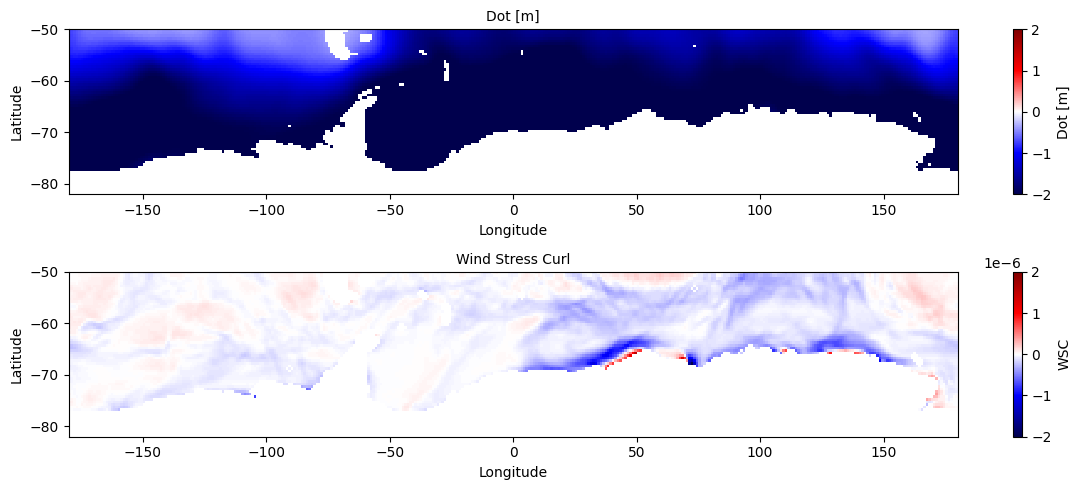

In [68]:
fig = plt.figure(figsize=(12,5))
plt.subplot(2,1,1)
plt.pcolormesh(llon, llat, dot[0], vmin=-2, vmax=2, cmap='seismic')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Dot [m]', fontsize=10)
ws1bar = plt.colorbar()
ws1bar.set_label('Dot [m]')

plt.subplot(2,1,2)
plt.pcolormesh(llon, llat, ws_curl[0], vmin=-2e-6, vmax=2e-6, cmap='seismic')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Wind Stress Curl', fontsize=10)
#plt.quiver(llon, llat, u10[0], v10[0])
ws2bar = plt.colorbar()
ws2bar.set_label('WSC')

plt.tight_layout()

In [69]:
# linear regression in time on each grid point
n_wsc,slope_wsc,intercept_wsc,p_val_wsc,r_square_wsc,rmse_wsc = linregress_3D(ws_curl)
# remove trend for ws_curl
xt_wsc = np.zeros(ws_curl.shape)
for t in range(0,ws_curl.shape[0]):
    xt_wsc[t] = t
ws_curl_detrended = ws_curl - (slope_wsc*xt_wsc + intercept_wsc)

In [70]:
seaice_drift_u_final = seaice_drift_u_detrended.copy()
seaice_drift_v_final = seaice_drift_v_detrended.copy()

seaice_drift_masked_u_final = seaice_drift_u_detrended_masked.copy()
seaice_drift_masked_v_final = seaice_drift_v_detrended_masked.copy()

U_final = U_detrended.copy()
sid_curl_final = sid_curl_detrended.copy()

ws_curl_final = ws_curl_detrended.copy()

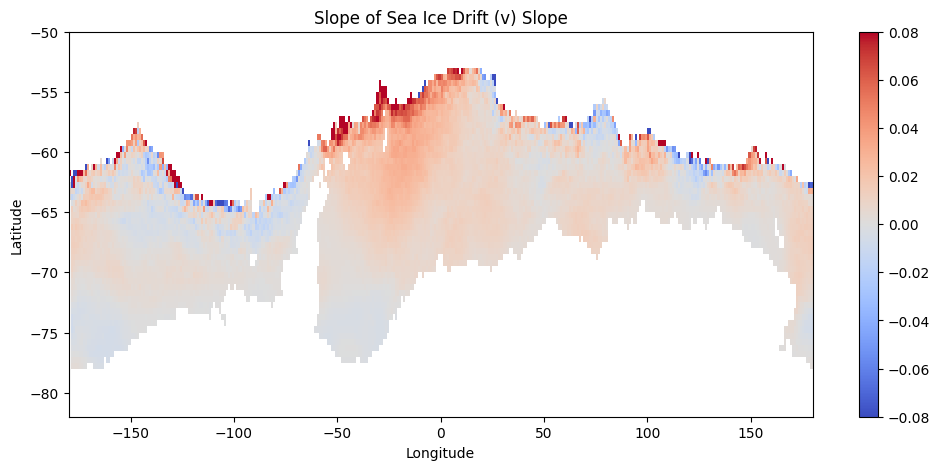

In [71]:
plt.figure(figsize=(12,5))
plt.pcolormesh(llon, llat, slope_si_v, vmin=-0.08, vmax=0.08, cmap='coolwarm')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Slope of Sea Ice Drift (v) Slope')
plt.colorbar()

In [72]:
#DESEASONAL

In [73]:
#deseasonal for sea ice and dot
months = time_dot.astype('datetime64[M]').astype(int) % 12 + 1

In [74]:
# find and remove seasonality from dot_detrended and seaice_detrended and ws_curl_detrended
dot_seas = np.zeros((12,dot.shape[1],dot.shape[2])); seaice_seas = np.zeros((12,dot.shape[1],dot.shape[2]));
ws_curl_seas = np.zeros((12,dot.shape[1],dot.shape[2]))
for m in range(1,13):
    dot_seas[m-1] = np.nanmean(dot_detrended[np.where(months==m)], axis=0)
    #seaice_seas[m-1] = np.nanmean(seaice_detrended[np.where(months==m)], axis=0)
    seaice_seas[m-1] = np.nanmean(seaice_drift_u_detrended[np.where(months==m)], axis=0)
    ws_curl_seas[m-1] = np.nanmean(ws_curl_detrended[np.where(months==m)], axis=0)

# remove seasonality from dot and sea ice concetration
#dot_final = np.zeros(dot_detrended.shape); seaice_final = np.zeros(seaice_detrended.shape)
dot_final = np.zeros(dot_detrended.shape); seaice_final = np.zeros(seaice_drift_u_detrended.shape)
for i,m in enumerate(months):
    dot_final[i] = dot_detrended[i] - dot_seas[m-1]
    seaice_final[i] = seaice_drift_u_detrended[i] - seaice_seas[m-1]
    ws_curl_final[i] = ws_curl_detrended[i] - ws_curl_seas[m-1]
    #seaice_final[i] = seaice_detrended[i] - seaice_seas[m-1]



In [75]:
print("dot_detrended shape:", dot_detrended.shape)
# print("seaice_detrended shape:", seaice_detrended.shape)
print("seaice_detrended shape:", seaice_drift_u_detrended.shape)
print("months shape:", months.shape)


dot_detrended shape: (196, 64, 360)
seaice_detrended shape: (196, 64, 360)
months shape: (196,)


In [76]:
# find and remove seasonality from U_detrended and sid_curl_detrended
U_seas = np.zeros((12,U_ice.shape[1],U_ice.shape[2])); sid_curl_seas = np.zeros((12,sid_curl.shape[1],sid_curl.shape[2]))
for m in range(1,13):
    U_seas[m-1] = np.nanmean(U_detrended[np.where(months==m)], axis=0)
    #seaice_seas[m-1] = np.nanmean(seaice_detrended[np.where(months==m)], axis=0)
    sid_curl_seas[m-1] = np.nanmean(sid_curl_detrended[np.where(months==m)], axis=0)

# remove seasonality from U and sea ice drift curl
U_final = np.zeros(U_detrended.shape); sid_curl_final = np.zeros(sid_curl_detrended.shape)
for i,m in enumerate(months):
    U_final[i] = U_detrended[i] - U_seas[m-1]
    sid_curl_final[i] = sid_curl_detrended[i] - sid_curl_seas[m-1]


In [77]:
# excract SIC from nsidc data
directory = '/Users/iw2g24/PycharmProjects/SSH_project/mca_shared_izzy/'
nsidc_sic_ds = xr.open_dataset(directory+'seaice_xa_masked_nsidc.nc')
print(nsidc_sic_ds)
nsidc_sic = nsidc_sic_ds['seaice_xa_masked']

<xarray.Dataset> Size: 36MB
Dimensions:           (time: 196, lat: 64, lon: 360)
Coordinates:
  * time              (time) datetime64[ns] 2kB 2002-07-01 ... 2018-10-01
  * lat               (lat) float64 512B -81.75 -81.25 -80.75 ... -50.75 -50.25
  * lon               (lon) float64 3kB -179.5 -178.5 -177.5 ... 178.5 179.5
Data variables:
    seaice_xa_masked  (time, lat, lon) float64 36MB ...


In [78]:
#calculate tau_ice_water and tau_air_water
tau_ice_water = ws_curl_final
tau_air_water = sid_curl_final
alpha = nsidc_sic

print('NaNs in alpha: ', alpha.isnull().sum().item())
print('NaNs in tau_ice_water: ', np.isnan(tau_ice_water).sum())
print('NaNs in tau_air_water: ', np.isnan(tau_air_water).sum())

#calculate total ocean surface stress
total_ocean_surface_stress = alpha * tau_ice_water + (1-alpha) * tau_air_water
print('osc shape', total_ocean_surface_stress.shape)
print('NaNs in osc:  ', total_ocean_surface_stress.isnull().sum().item())

total_osc_masked = total_ocean_surface_stress.fillna(0)
print('Nans left in osc: ', total_osc_masked.isnull().sum().item())


NaNs in alpha:  0
NaNs in tau_ice_water:  1693636
NaNs in tau_air_water:  3772835
osc shape (196, 64, 360)
NaNs in osc:   3777546
Nans left in osc:  0


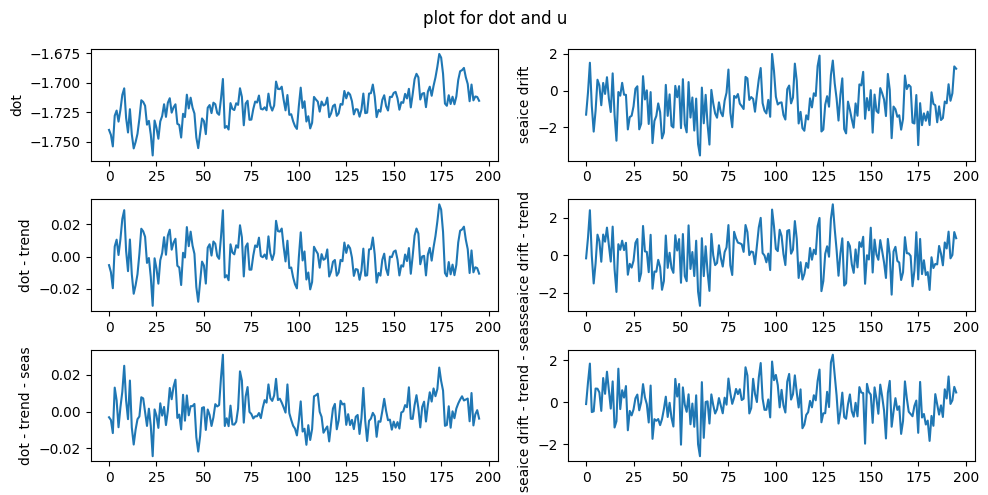

In [79]:
fig = plt.figure(figsize=(10,5))
plt.subplot(3,2,1)
plt.plot(np.nanmean(dot, axis=(1,2)))
plt.ylabel('dot')
plt.subplot(3,2,2)
#plt.plot(np.nanmean(regridded_seaice_filtered, axis=(1,2)))
plt.plot(np.nanmean(regridded_seaice_ds['seaice_drift_u'], axis=(1,2)))
#plt.ylabel('seaice conc')
plt.ylabel('seaice drift')
plt.subplot(3,2,3)
plt.plot(np.nanmean(dot_detrended, axis=(1,2)))
plt.ylabel('dot - trend')
plt.subplot(3,2,4)
# plt.plot(np.nanmean(seaice_detrended, axis=(1,2)))
plt.plot(np.nanmean(seaice_drift_u_detrended, axis=(1,2)))
#plt.ylabel('seaice conc - trend')
plt.ylabel('seaice drift - trend')
plt.subplot(3,2,5)
plt.plot(np.nanmean(dot_final, axis=(1,2)))
plt.ylabel('dot - trend - seas')
plt.subplot(3,2,6)
plt.plot(np.nanmean(seaice_final, axis=(1,2)))
#plt.ylabel('seaice conc - trend - seas')
plt.ylabel('seaice drift - trend - seas')
plt.suptitle(f"plot for dot and u" )

plt.tight_layout()

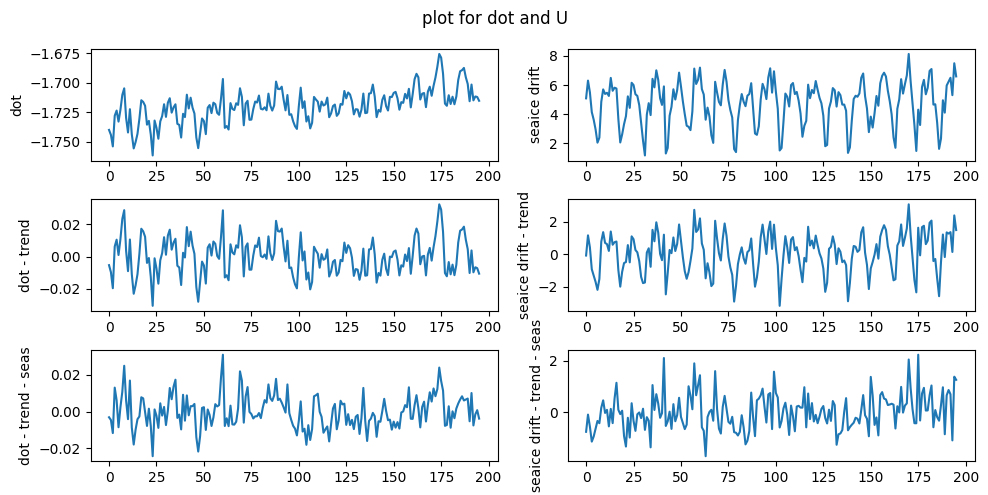

In [80]:
fig = plt.figure(figsize=(10,5))
plt.subplot(3,2,1)
plt.plot(np.nanmean(dot, axis=(1,2)))
plt.ylabel('dot')
plt.subplot(3,2,2)
#plt.plot(np.nanmean(regridded_seaice_filtered, axis=(1,2)))
plt.plot(np.nanmean(U_ice, axis=(1,2)))
#plt.ylabel('seaice conc')
plt.ylabel('seaice drift')
plt.subplot(3,2,3)
plt.plot(np.nanmean(dot_detrended, axis=(1,2)))
plt.ylabel('dot - trend')
plt.subplot(3,2,4)
# plt.plot(np.nanmean(seaice_detrended, axis=(1,2)))
plt.plot(np.nanmean(U_detrended, axis=(1,2)))
#plt.ylabel('seaice conc - trend')
plt.ylabel('seaice drift - trend')
plt.subplot(3,2,5)
plt.plot(np.nanmean(dot_final, axis=(1,2)))
plt.ylabel('dot - trend - seas')
plt.subplot(3,2,6)
plt.plot(np.nanmean(U_final, axis=(1,2)))
#plt.ylabel('seaice conc - trend - seas')
plt.ylabel('seaice drift - trend - seas')
plt.suptitle(f"plot for dot and U" )

plt.tight_layout()

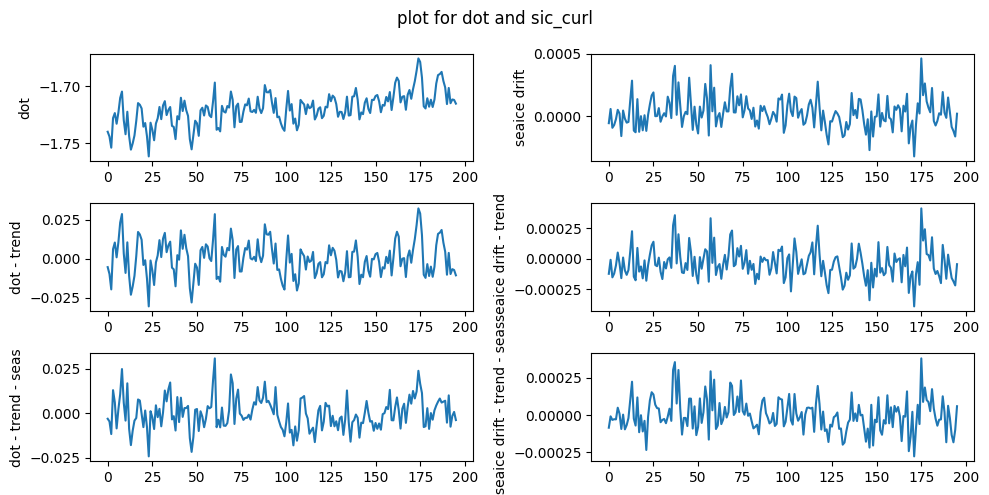

In [81]:
fig = plt.figure(figsize=(10,5))
plt.subplot(3,2,1)
plt.plot(np.nanmean(dot, axis=(1,2)))
plt.ylabel('dot')
plt.subplot(3,2,2)
#plt.plot(np.nanmean(regridded_seaice_filtered, axis=(1,2)))
plt.plot(np.nanmean(sid_curl, axis=(1,2)))
#plt.ylabel('seaice conc')
plt.ylabel('seaice drift')
plt.subplot(3,2,3)
plt.plot(np.nanmean(dot_detrended, axis=(1,2)))
plt.ylabel('dot - trend')
plt.subplot(3,2,4)
# plt.plot(np.nanmean(seaice_detrended, axis=(1,2)))
plt.plot(np.nanmean(sid_curl_detrended, axis=(1,2)))
#plt.ylabel('seaice conc - trend')
plt.ylabel('seaice drift - trend')
plt.subplot(3,2,5)
plt.plot(np.nanmean(dot_final, axis=(1,2)))
plt.ylabel('dot - trend - seas')
plt.subplot(3,2,6)
plt.plot(np.nanmean(sid_curl_final, axis=(1,2)))
#plt.ylabel('seaice conc - trend - seas')
plt.ylabel('seaice drift - trend - seas')
plt.suptitle(f"plot for dot and sic_curl" )
plt.tight_layout()


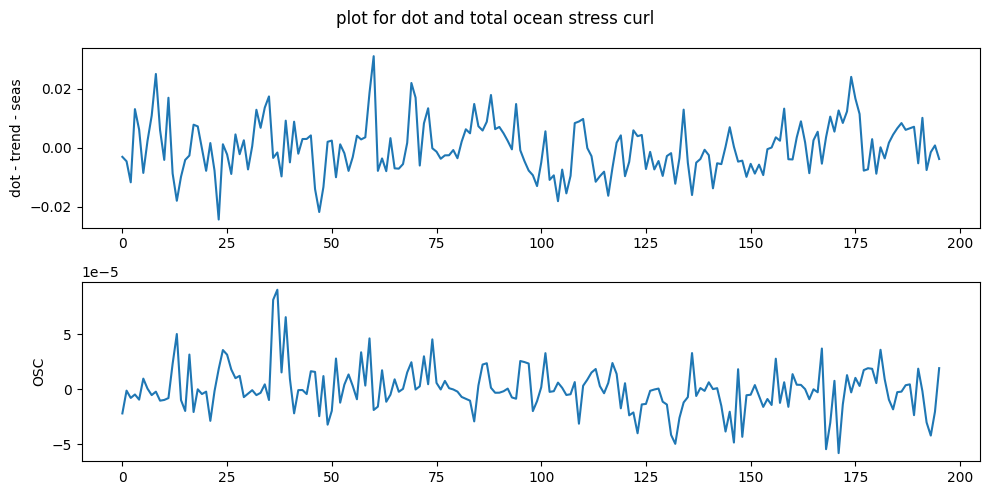

In [82]:
fig = plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.plot(np.nanmean(dot_final, axis=(1,2)))
plt.ylabel('dot - trend - seas')
plt.subplot(2,1,2)
#plt.plot(np.nanmean(total_ocean_surface_stress, axis=(1,2)))
plt.plot(np.nanmean(total_osc_masked, axis=(1,2)))
#plt.ylabel('seaice conc - trend - seas')
plt.ylabel('OSC')
plt.suptitle(f"plot for dot and total ocean stress curl" )
plt.tight_layout()

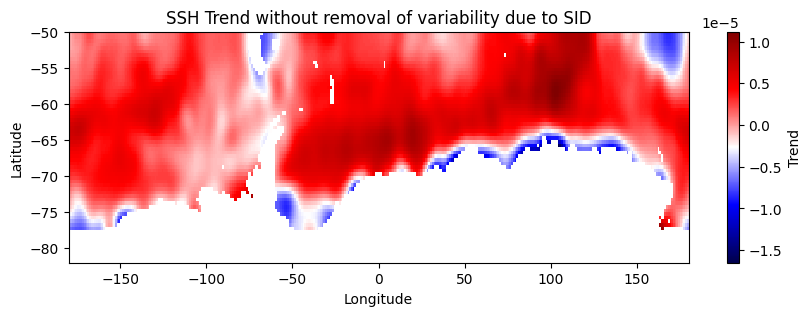

In [83]:
# SSH trends without removing ocean variability due to sea ice concentration
plt.figure(figsize=(10,3))
n,slope,intercept,p_val,r_square,rmse = linregress_3D(dot_final)
plt.pcolormesh(lon_mesh, lat_mesh, slope, cmap='seismic')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('SSH Trend without removal of variability due to SID')
cbar = plt.colorbar()
cbar.set_label('Trend')

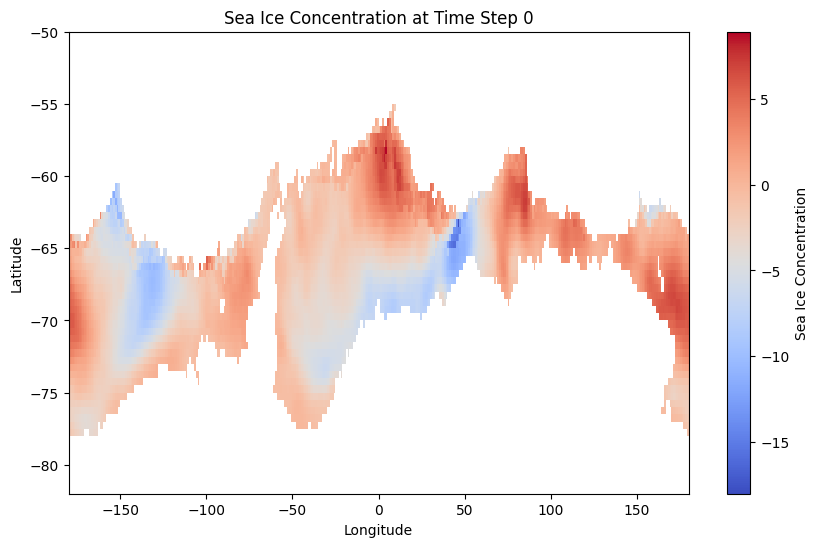

In [84]:
time_step = 0  # You can change this to any index from 0 to 195 (since the shape is (196, 64, 360))

# Extract and plot the masked data for the selected time step
seaice_at_t = regridded_seaice_ds['seaice_drift_u'].isel(time = time_step)


# Plot the data using pcolormesh
plt.figure(figsize=(10, 6))
plt.pcolormesh( lon_mesh, lat_mesh,seaice_at_t, cmap='coolwarm', shading='auto')
plt.colorbar(label='Sea Ice Concentration')
plt.title(f"Sea Ice Concentration at Time Step {time_step}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [85]:
# MCA

In [86]:
#MCA of dot, seaice conc, U, sea ice drift, WSC

dot_xa = xr.DataArray(dot_final, coords=[time_dot, lat_values, lon_values], dims=["time", "lat", "lon"],)
seaice_xa = xr.DataArray(seaice_final, coords=[time_dot, lat_values, lon_values], dims=["time", "lat", "lon"],)
U_xa = xr.DataArray(U_final, coords= [time_dot, lat_values, lon_values], dims=["time", "lat", "lon"],)
sid_curl_xa = xr.DataArray(sid_curl_final, coords= [time_dot, lat_values, lon_values], dims=["time", "lat", "lon"],)
ws_curl_xa = xr.DataArray(ws_curl_final, coords=[time_dot, lat_values, lon_values], dims=["time", "lat", "lon"],)

# print(dot_xa.values)
# print('/n---/n')
# print(seaice_xa.values)

min_value = seaice_xa.where(~seaice_xa.isnull()).min().item()
max_value = seaice_xa.where(~seaice_xa.isnull()).max().item()
print(f"Range of values (excluding NaN): Min = {min_value}, Max = {max_value}")


Range of values (excluding NaN): Min = -22.56512400540126, Max = 20.700299927128142


In [87]:
total_nans = dot_xa.isnull().sum().item()
print(f"Total NaN values in dot_xa: {total_nans}")

total_nans_seaice = seaice_xa.isnull().sum().item()
print(f"Total NaN values in seaice_xa: {total_nans_seaice}")

total_points_dot = dot_xa.size
print(f"Total data points in dot_xa: {total_points_dot}")

total_points_seaice = seaice_xa.size
print(f"Total data points in seaice_xa: {total_points_seaice}")

print(seaice_xa.shape)
print(dot_xa.shape)



Total NaN values in dot_xa: 1582308
Total NaN values in seaice_xa: 3552781
Total data points in dot_xa: 4515840
Total data points in seaice_xa: 4515840
(196, 64, 360)
(196, 64, 360)


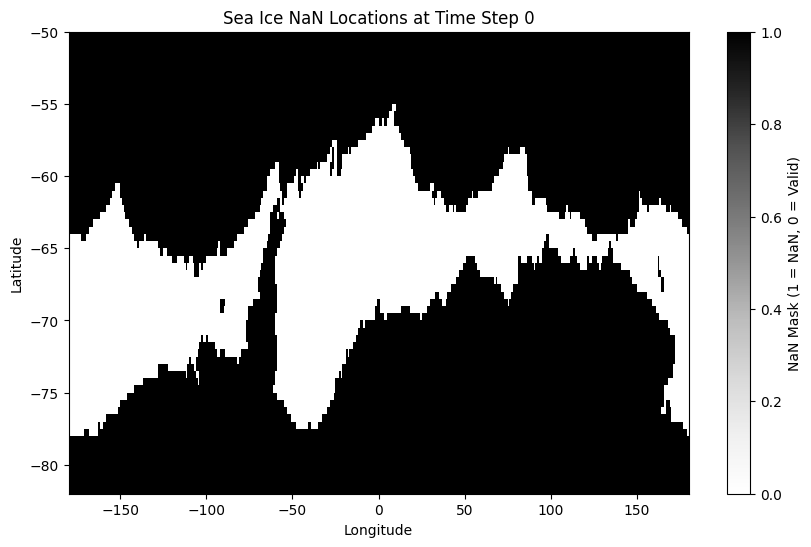

In [88]:
#plot where there are nan values (this is where i created the mask for SIC > 1 earlier)
time_step = 0
# Create a mask where NaN values are True
seaice_nan_mask = np.isnan(regridded_seaice_ds['seaice_drift_u'].isel(time =time_step))

# Plot the mask using pcolormesh
plt.figure(figsize=(10, 6))
plt.pcolormesh(
    lon_mesh, lat_mesh, seaice_nan_mask,
    cmap='Greys', shading='auto'
)
plt.colorbar(label='NaN Mask (1 = NaN, 0 = Valid)')
plt.title(f"Sea Ice NaN Locations at Time Step {time_step}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [89]:
print(dir(xe))

['RotatorFactory', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', '_version', 'base_model', 'cross', 'data_container', 'linalg', 'multi', 'preprocessing', 'rotator_factory', 'single', 'utils', 'validation']


In [167]:
#set all NaN values to = 0 in dot and seaice. this means there has been no change
dot_xa_masked = dot_xa.fillna(0)
seaice_xa_masked = seaice_xa.fillna(0)
sid_curl_xa_masked = sid_curl_xa.fillna(0)
U_xa_masked = U_xa.fillna(0)
WSC_xa_masked = ws_curl_xa.fillna(0)

print("Masked dot_xa shape:", dot_xa_masked.shape)
print("Masked seaice_xa shape:", seaice_xa_masked.shape)
print("masked WSC dtype", WSC_xa_masked.dtype)



Masked dot_xa shape: (196, 64, 360)
Masked seaice_xa shape: (196, 64, 360)
masked WSC dtype float64


In [172]:
test_OSC1 = sid_curl_xa_masked + WSC_xa_masked
print(test_OSC1.dtype)

test_OSC = xr.where(
    sid_curl_xa_masked == 0,
    WSC_xa_masked,
    sid_curl_xa_masked
)
print(test_OSC.dtype)

print(np.isnan(sid_curl_xa_masked).sum(), 'NaNs in SIDC')
print(np.isnan(WSC_xa_masked).sum(), 'NaNs in WSC')
print(np.isnan(test_OSC).sum(), 'NaNs in test_OSC')



float64
float64
<xarray.DataArray ()> Size: 8B
array(0) NaNs in SIDC
<xarray.DataArray ()> Size: 8B
array(0) NaNs in WSC
<xarray.DataArray ()> Size: 8B
array(0) NaNs in test_OSC


float64


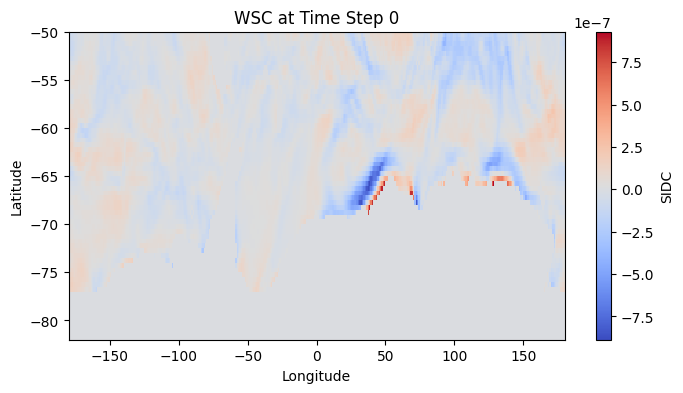

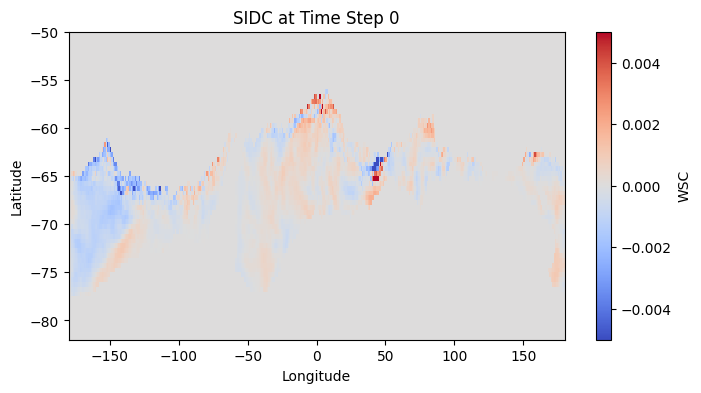

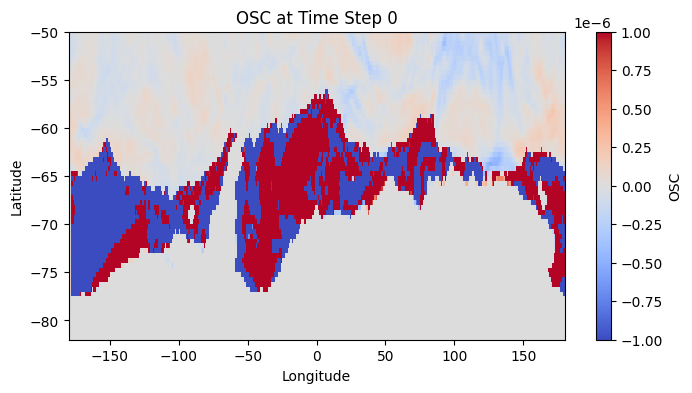

In [183]:
time_step = 0  # You can change this to any index from 0 to 195 (since the shape is (196, 64, 360))

# Extract and plot the masked data for the selected time step
test_OSC_t = (test_OSC.isel(time = time_step))

time_step = 0  # You can change this to any index from 0 to 195 (since the shape is (196, 64, 360))

# Extract and plot the masked data for the selected time step
test_WSC_t = WSC_xa_masked.isel(time = time_step)
test_SIDC_t = sid_curl_xa_masked.isel(time = time_step)
print(test_WSC_t.dtype)

# Plot the data using pcolormesh
plt.figure(figsize=(8, 4))
plt.pcolormesh( lon_mesh, lat_mesh,test_WSC_t, cmap='coolwarm', shading='auto')
plt.colorbar(label='SIDC')
plt.title(f"WSC at Time Step {time_step}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# Plot the data using pcolormesh
plt.figure(figsize=(8, 4))
plt.pcolormesh( lon_mesh, lat_mesh,test_SIDC_t, vmin = -0.005, vmax = 0.005, cmap='coolwarm', shading='auto')
plt.colorbar(label='WSC')
plt.title(f"SIDC at Time Step {time_step}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


# Plot the data using pcolormesh
plt.figure(figsize=(8, 4))
plt.pcolormesh( lon_mesh, lat_mesh,test_OSC_t, cmap='coolwarm', vmin = -0.000001, vmax = 0.000001, shading='auto')
plt.colorbar(label='OSC')
plt.title(f"OSC at Time Step {time_step}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [91]:
print("Remaining NaNs in dot_xa_masked:", dot_xa_masked.isnull().sum().item())
print("Remaining NaNs in seaice_xa_masked:", seaice_xa_masked.isnull().sum().item())


Remaining NaNs in dot_xa_masked: 0
Remaining NaNs in seaice_xa_masked: 0


In [92]:
print(dir(xe))


['RotatorFactory', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', '_version', 'base_model', 'cross', 'data_container', 'linalg', 'multi', 'preprocessing', 'rotator_factory', 'single', 'utils', 'validation']


In [93]:
import inspect
model = xe.cross.MCA(n_modes=22, standardize=True)
#print(dir(model))
print(dot_xa_masked.coords)
print(seaice_xa_masked.coords)

model.fit(dot_xa_masked, seaice_xa_masked, dim='time')
comps1, comps2 = model.components()  # Singular vectors (spatial patterns)
scores1, scores2 = model.scores()  # Expansion coefficients (temporal patterns)

Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lat      (lat) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lat      (lat) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5


In [94]:
s1 = scores1.values; s2 = scores2.values
c1 = comps1.values; c2 = comps2.values

In [95]:
print(path)
print(gridtype)

/Users/iw2g24/PycharmProjects/SSH_project/
remapcon


In [96]:
# Full path to the 'results' directory
results_dir = os.path.join(path, 'results')

# Check if the directory already exists
if os.path.exists(results_dir):
    print("Directory already exists")
else:
    # Create the directory if it doesn't exist
    os.makedirs(results_dir, exist_ok=True)
    print("Directory created!")

Directory already exists


In [97]:
# write PCs on files
# fname = path + 'results/PCs_dot_' + gridtype + '.txt'
fname = path + 'results/PCs_dot_' + gridtype + '_seas.txt'
with open(fname, 'w') as file:
    file.write('time\tPC1\tPC2\tPC3\n')
    for i in range(len(time_dot)):
        file.write(f'{time_dot[i]}\t{s1[0,i]}\t{s1[1,i]}\t{s1[2,i]}\n')
file.close()

# fname = path + 'results/PCs_ws_curl_' + gridtype + '.txt'
fname = path + 'results/PCs_si_drift_test_' + gridtype + '_seas.txt'
with open(fname, 'w') as file:
    file.write('time\tPC1\tPC2\tPC3\n')
    for i in range(len(time_dot)):
        file.write(f'{time_dot[i]}\t{s2[0,i]}\t{s2[1,i]}\t{s2[2,i]}\n')
file.close()

In [98]:
#how can you change from using cross.MCA to calling the subplots PCA1, PCA2, PCA3 etc ...

In [99]:
r_pears = []; p_pears = []
r_spear = []; p_spear = []
for m in range(1,5):
    x = scores1.sel(mode=m)
    y = scores2.sel(mode=m)
    r, p = scipy.stats.pearsonr(x, y)
    r_pears.append(np.round(r, 2)); p_pears.append(np.round(p, 2))
    r, p = scipy.stats.spearmanr(x, y)
    r_spear.append(np.round(r, 2)); p_spear.append(np.round(p, 2))

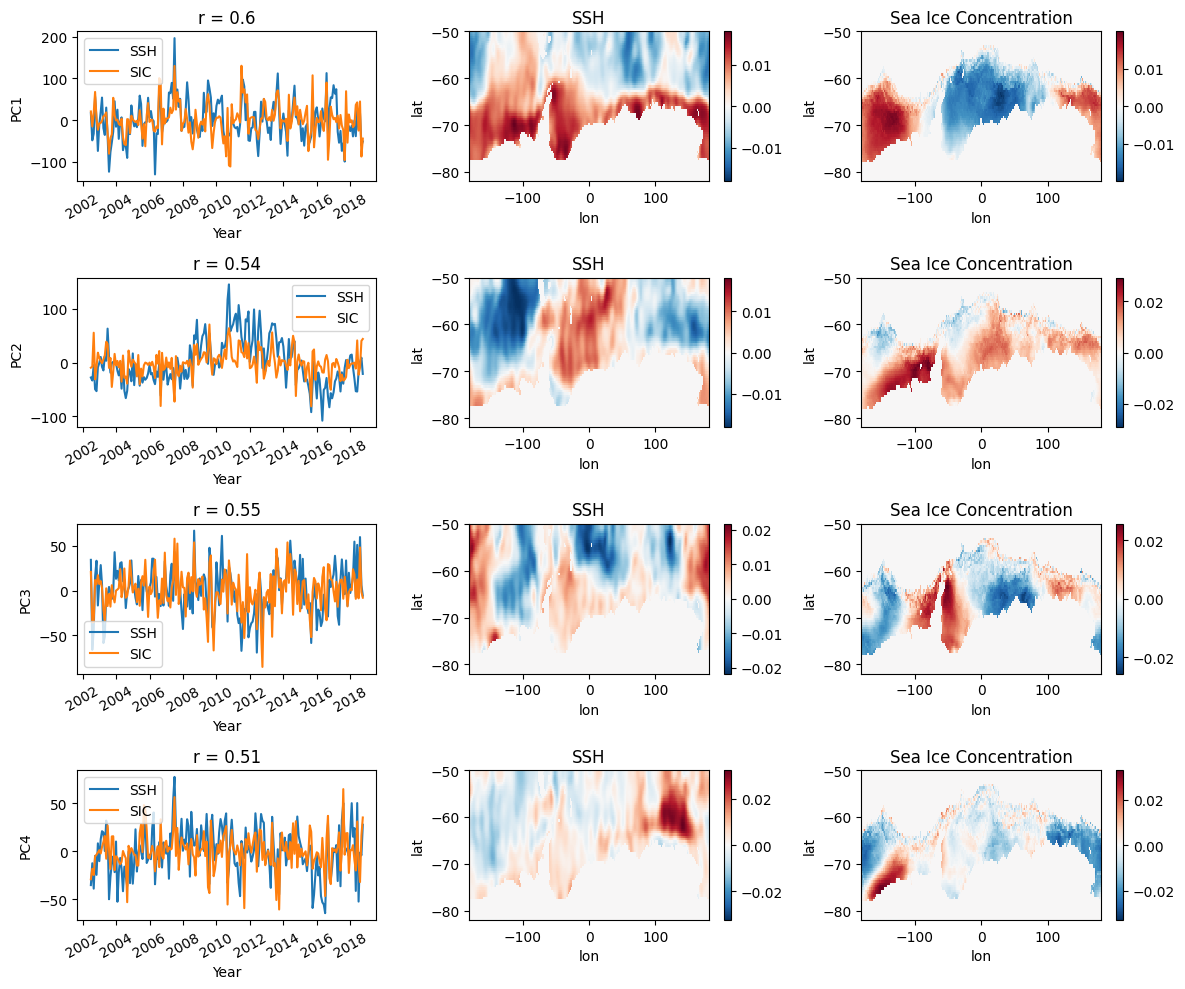

In [100]:
fig = plt.figure(figsize=(12,10))

for i in range(0,4):
    j = 3*i+1 # a = 2*(i+1) + i - 1
    
    plt.subplot(4,3,j)
    scores1.sel(mode=i+1).plot(label = 'SSH')
    scores2.sel(mode=i+1).plot(label = 'SIC')
    plt.title('r = ' +str(r_spear[i]))
    plt.xlabel('Year'); plt.ylabel('PC'+str(int(i+1)))
    plt.xticks(rotation=30) 
    plt.legend()
    
    plt.subplot(4,3,j+1)
    comps1.sel(mode=i+1).plot()
    plt.title('SSH')
    
    plt.subplot(4,3,j+2)
    comps2.sel(mode=i+1).plot()
    plt.title('Sea Ice Concentration')

fig.tight_layout()

#fig.savefig(path + 'results/MCA_output_' + gridtype + '_seas.png')

In [101]:
# compute squared covariance fraction (equivalent to explained variance in PCA)
sq_cov_frac = model.squared_covariance_fraction()
scf = sq_cov_frac.values
cum_sum = np.cumsum(scf)
print('Cumulative sum of squares:', cum_sum)
print('Squared covariance fraction:',scf)

Cumulative sum of squares: [0.6347271  0.79810817 0.85754667 0.88971823 0.9123652  0.92880016
 0.939922   0.94890266 0.95637187 0.96224224 0.96681767 0.97082748
 0.97437769 0.97758474 0.98051375 0.98273161 0.98482579 0.98632706
 0.98763916 0.98885999 0.98996019 0.99095045]
Squared covariance fraction: [0.6347271  0.16338106 0.0594385  0.03217156 0.02264698 0.01643496
 0.01112184 0.00898066 0.0074692  0.00587037 0.00457543 0.00400981
 0.0035502  0.00320705 0.00292901 0.00221786 0.00209418 0.00150127
 0.0013121  0.00122084 0.0011002  0.00099026]


In [102]:
print(type(cum_sum))
print(len(cum_sum))
mode_percent = []
for i in range(len(cum_sum)):
    if i == 0:
        each_mode_percent =float(cum_sum[i])
        mode_percent.append(each_mode_percent)
    else:
        each_mode_percent = float(cum_sum[i]-cum_sum[i-1])
        mode_percent.append(each_mode_percent)
print('PCA fraction', mode_percent)


<class 'numpy.ndarray'>
22
PCA fraction [0.6347271043331988, 0.16338106238744354, 0.05943850003174522, 0.03217156209595251, 0.0226469751982884, 0.016434956725324468, 0.01112183945908396, 0.008980663073330453, 0.0074692039605788185, 0.005870373692090869, 0.00457543081252354, 0.004009809698270472, 0.0035502041842616627, 0.003207054537820442, 0.0029290078995659607, 0.00221786066274976, 0.00209417800822409, 0.0015012721522847938, 0.0013120962229253852, 0.0012208381716684036, 0.0011002000027476866, 0.000990256898570352]


In [142]:
# print(total_osc_masked)
total_osc_masked.name = 'OSC'
print(total_osc_masked)

#NEED TO ADD NAME TO THIS VARIABLE AND ALSO SAVE IT

directory = '/Users/iw2g24/PycharmProjects/SSH_project/mca_shared_izzy/'
total_osc_masked.to_netcdf(directory+'OSC_nsidc_ds_v2.nc')

<xarray.DataArray 'OSC' (time: 196, lat: 64, lon: 360)> Size: 36MB
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],


#HERE I REPEAT THE MCA ANALYSIS FOR U AND OSC !!! - working on adapting for NaNs in OSC


Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lat      (lat) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lat      (lat) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
/Users/iw2g24/PycharmProjects/SSH_project/
remapcon
Directory already exists
Cumulative sum of squares: [0.39599577 0.56879129 0.6595775  0.71673689 0.7503305  0.78268324
 0.81312531 0.83728683 0.85532678 0.87177371 0.88690437 0.89909314
 0.90937251 0.91798833 0.92529662 0.93193154 0.93834003 0.94446343
 0.95010646 0.95442387 0.95837068 0.96209566]
Squared covariance fraction: [0.39599577 0.17279552 0.09078621 0.0571594  0.03359361 0.03235274
 0.03044207 0.02416152 0.01803996 0.01644692 0.01513066 0

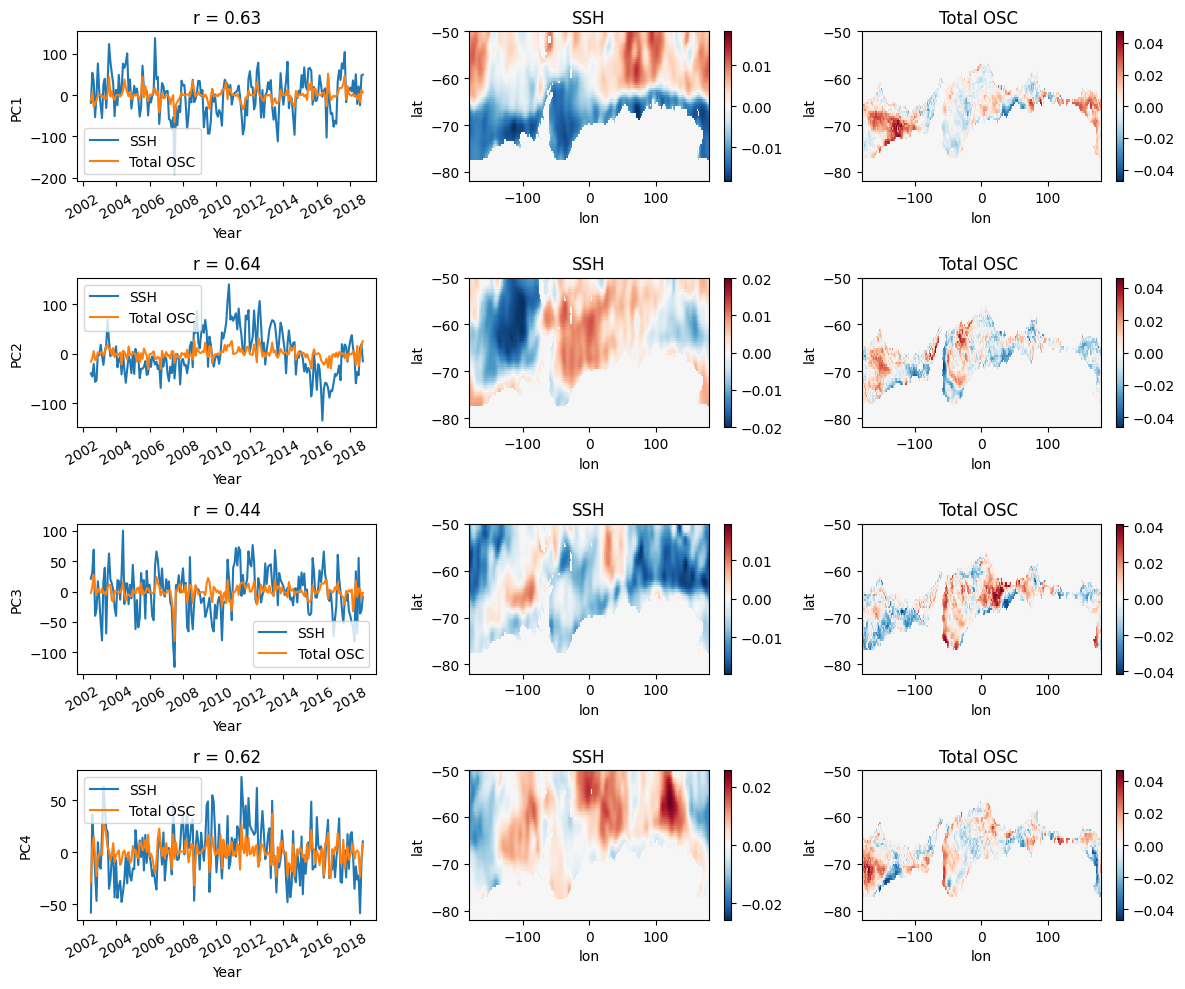

In [104]:
model = xe.cross.MCA(n_modes=22, standardize=True)
#print(dir(model))
print(dot_xa_masked.coords)
print(total_ocean_surface_stress.coords)

model.fit(dot_xa_masked, total_osc_masked, dim='time')
comps1, comps2 = model.components()  # Singular vectors (spatial patterns)
scores1, scores2 = model.scores()  # Expansion coefficients (temporal patterns)
s1 = scores1.values;
s2 = scores2.values
c1 = comps1.values;
c2 = comps2.values
print(path)
print(gridtype)
# Full path to the 'results' directory
results_dir = os.path.join(path, 'results')

# Check if the directory already exists
if os.path.exists(results_dir):
    print("Directory already exists")
else:
    # Create the directory if it doesn't exist
    os.makedirs(results_dir, exist_ok=True)
    print("Directory created!")
# write PCs on files
# fname = path + 'results/PCs_dot_' + gridtype + '.txt'
fname = path + 'results/PCs_U_' + gridtype + '_seas.txt'
with open(fname, 'w') as file:
    file.write('time\tPC1\tPC2\tPC3\n')
    for i in range(len(time_dot)):
        file.write(f'{time_dot[i]}\t{s1[0, i]}\t{s1[1, i]}\t{s1[2, i]}\n')
file.close()

# fname = path + 'results/PCs_ws_curl_' + gridtype + '.txt'
fname = path + 'results/PCs_total_osc' + gridtype + '_seas.txt'
with open(fname, 'w') as file:
    file.write('time\tPC1\tPC2\tPC3\n')
    for i in range(len(time_dot)):
        file.write(f'{time_dot[i]}\t{s2[0, i]}\t{s2[1, i]}\t{s2[2, i]}\n')
file.close()
#how can you change from using cross.MCA to calling the subplots PCA1, PCA2, PCA3 etc ...
r_pears = [];
p_pears = []
r_spear = [];
p_spear = []
for m in range(1, 5):
    x = scores1.sel(mode=m)
    y = scores2.sel(mode=m)
    r, p = scipy.stats.pearsonr(x, y)
    r_pears.append(np.round(r, 2));
    p_pears.append(np.round(p, 2))
    r, p = scipy.stats.spearmanr(x, y)
    r_spear.append(np.round(r, 2));
    p_spear.append(np.round(p, 2))
fig = plt.figure(figsize=(12, 10))

for i in range(0, 4):
    j = 3 * i + 1  # a = 2*(i+1) + i - 1

    plt.subplot(4, 3, j)
    scores1.sel(mode=i + 1).plot(label='SSH')
    scores2.sel(mode=i + 1).plot(label='Total OSC')
    plt.title('r = ' + str(r_spear[i]))
    plt.xlabel('Year');
    plt.ylabel('PC' + str(int(i + 1)))
    plt.xticks(rotation=30)
    plt.legend()

    plt.subplot(4, 3, j + 1)
    comps1.sel(mode=i + 1).plot()
    plt.title('SSH')

    plt.subplot(4, 3, j + 2)
    comps2.sel(mode=i + 1).plot()
    plt.title('Total OSC ')

fig.tight_layout()

#fig.savefig(path + 'results/MCA_output_' + gridtype + '_seas.png')
# compute squared covariance fraction (equivalent to explained variance in PCA)
sq_cov_frac = model.squared_covariance_fraction()
scf = sq_cov_frac.values
cum_sum = np.cumsum(scf)
print('Cumulative sum of squares:', cum_sum)
print('Squared covariance fraction:', scf)
print(type(cum_sum))
print(len(cum_sum))
mode_percent = []
for i in range(len(cum_sum)):
    if i == 0:
        each_mode_percent = float(cum_sum[i])
        mode_percent.append(each_mode_percent)
    else:
        each_mode_percent = float(cum_sum[i] - cum_sum[i - 1])
        mode_percent.append(each_mode_percent)
print('PCA fraction', mode_percent)

In [105]:
#HERE I REPEAT THE MCA ANALYSIS FOR U AND SID_CURL !!!

Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lat      (lat) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lat      (lat) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
/Users/iw2g24/PycharmProjects/SSH_project/
remapcon
Directory already exists
Cumulative sum of squares: [0.52129749 0.70031336 0.76858985 0.82582135 0.86263042 0.8880406
 0.90479816 0.91909553 0.93017034 0.94036969 0.94796658 0.95475722
 0.96048545 0.9650684  0.96960741 0.97339979 0.97629174 0.97859258
 0.98064416 0.98259279 0.98439089 0.98589002]
Squared covariance fraction: [0.52129749 0.17901587 0.06827649 0.0572315  0.03680907 0.02541018
 0.01675756 0.01429737 0.01107481 0.01019935 0.00759689 0.

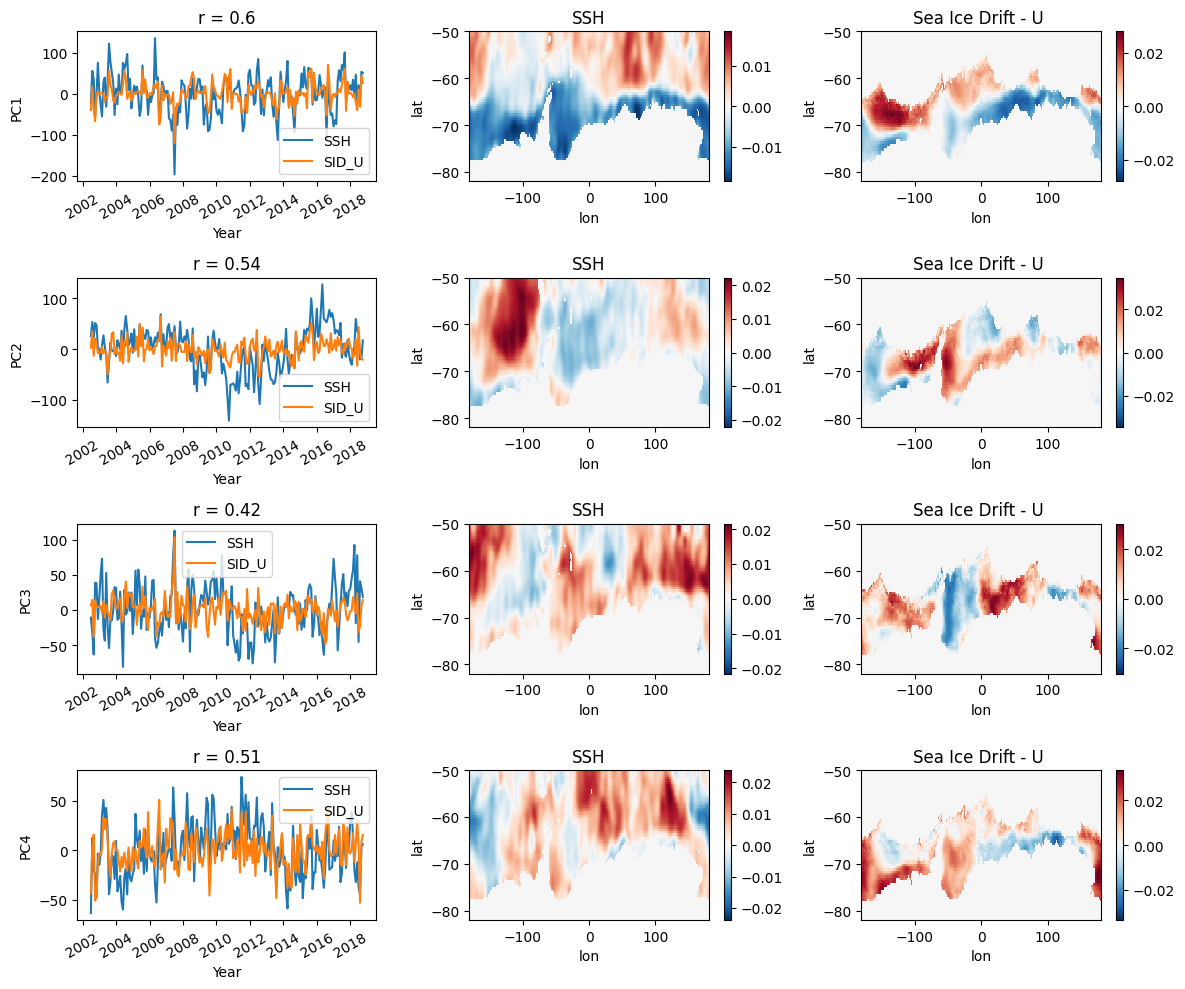

In [106]:
model = xe.cross.MCA(n_modes=22, standardize=True)
#print(dir(model))
print(dot_xa_masked.coords)
print(U_xa_masked.coords)

model.fit(dot_xa_masked, U_xa_masked, dim='time')
comps1, comps2 = model.components()  # Singular vectors (spatial patterns)
scores1, scores2 = model.scores()  # Expansion coefficients (temporal patterns)
s1 = scores1.values;
s2 = scores2.values
c1 = comps1.values;
c2 = comps2.values
print(path)
print(gridtype)
# Full path to the 'results' directory
results_dir = os.path.join(path, 'results')

# Check if the directory already exists
if os.path.exists(results_dir):
    print("Directory already exists")
else:
    # Create the directory if it doesn't exist
    os.makedirs(results_dir, exist_ok=True)
    print("Directory created!")
# write PCs on files
# fname = path + 'results/PCs_dot_' + gridtype + '.txt'
fname = path + 'results/PCs_U_' + gridtype + '_seas.txt'
with open(fname, 'w') as file:
    file.write('time\tPC1\tPC2\tPC3\n')
    for i in range(len(time_dot)):
        file.write(f'{time_dot[i]}\t{s1[0, i]}\t{s1[1, i]}\t{s1[2, i]}\n')
file.close()

# fname = path + 'results/PCs_ws_curl_' + gridtype + '.txt'
fname = path + 'results/PCs_si_drift_U_' + gridtype + '_seas.txt'
with open(fname, 'w') as file:
    file.write('time\tPC1\tPC2\tPC3\n')
    for i in range(len(time_dot)):
        file.write(f'{time_dot[i]}\t{s2[0, i]}\t{s2[1, i]}\t{s2[2, i]}\n')
file.close()
#how can you change from using cross.MCA to calling the subplots PCA1, PCA2, PCA3 etc ...
r_pears = [];
p_pears = []
r_spear = [];
p_spear = []
for m in range(1, 5):
    x = scores1.sel(mode=m)
    y = scores2.sel(mode=m)
    r, p = scipy.stats.pearsonr(x, y)
    r_pears.append(np.round(r, 2));
    p_pears.append(np.round(p, 2))
    r, p = scipy.stats.spearmanr(x, y)
    r_spear.append(np.round(r, 2));
    p_spear.append(np.round(p, 2))
fig = plt.figure(figsize=(12, 10))

for i in range(0, 4):
    j = 3 * i + 1  # a = 2*(i+1) + i - 1

    plt.subplot(4, 3, j)
    scores1.sel(mode=i + 1).plot(label='SSH')
    scores2.sel(mode=i + 1).plot(label='SID_U')
    plt.title('r = ' + str(r_spear[i]))
    plt.xlabel('Year');
    plt.ylabel('PC' + str(int(i + 1)))
    plt.xticks(rotation=30)
    plt.legend()

    plt.subplot(4, 3, j + 1)
    comps1.sel(mode=i + 1).plot()
    plt.title('SSH')

    plt.subplot(4, 3, j + 2)
    comps2.sel(mode=i + 1).plot()
    plt.title('Sea Ice Drift - U ')

fig.tight_layout()

#fig.savefig(path + 'results/MCA_output_' + gridtype + '_seas.png')
# compute squared covariance fraction (equivalent to explained variance in PCA)
sq_cov_frac = model.squared_covariance_fraction()
scf = sq_cov_frac.values
cum_sum = np.cumsum(scf)
print('Cumulative sum of squares:', cum_sum)
print('Squared covariance fraction:', scf)
print(type(cum_sum))
print(len(cum_sum))
mode_percent = []
for i in range(len(cum_sum)):
    if i == 0:
        each_mode_percent = float(cum_sum[i])
        mode_percent.append(each_mode_percent)
    else:
        each_mode_percent = float(cum_sum[i] - cum_sum[i - 1])
        mode_percent.append(each_mode_percent)
print('PCA fraction', mode_percent)


In [107]:
#HERE I REPEAT THE MCA ANALYSIS FOR SID_CURL vs dot !!!

Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lat      (lat) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lat      (lat) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
/Users/iw2g24/PycharmProjects/SSH_project/
remapcon
Directory already exists
Cumulative sum of squares: [0.40824008 0.57928717 0.66682284 0.72385651 0.75833628 0.79118165
 0.8207903  0.84456829 0.86277875 0.87903135 0.89275211 0.90398112
 0.91377295 0.92229626 0.92959073 0.93586057 0.94173467 0.94758201
 0.95290376 0.95720976 0.96123269 0.96470948]
Squared covariance fraction: [0.40824008 0.17104709 0.08753568 0.05703367 0.03447976 0.03284537
 0.02960865 0.02377799 0.01821047 0.0162526  0.01372076 0

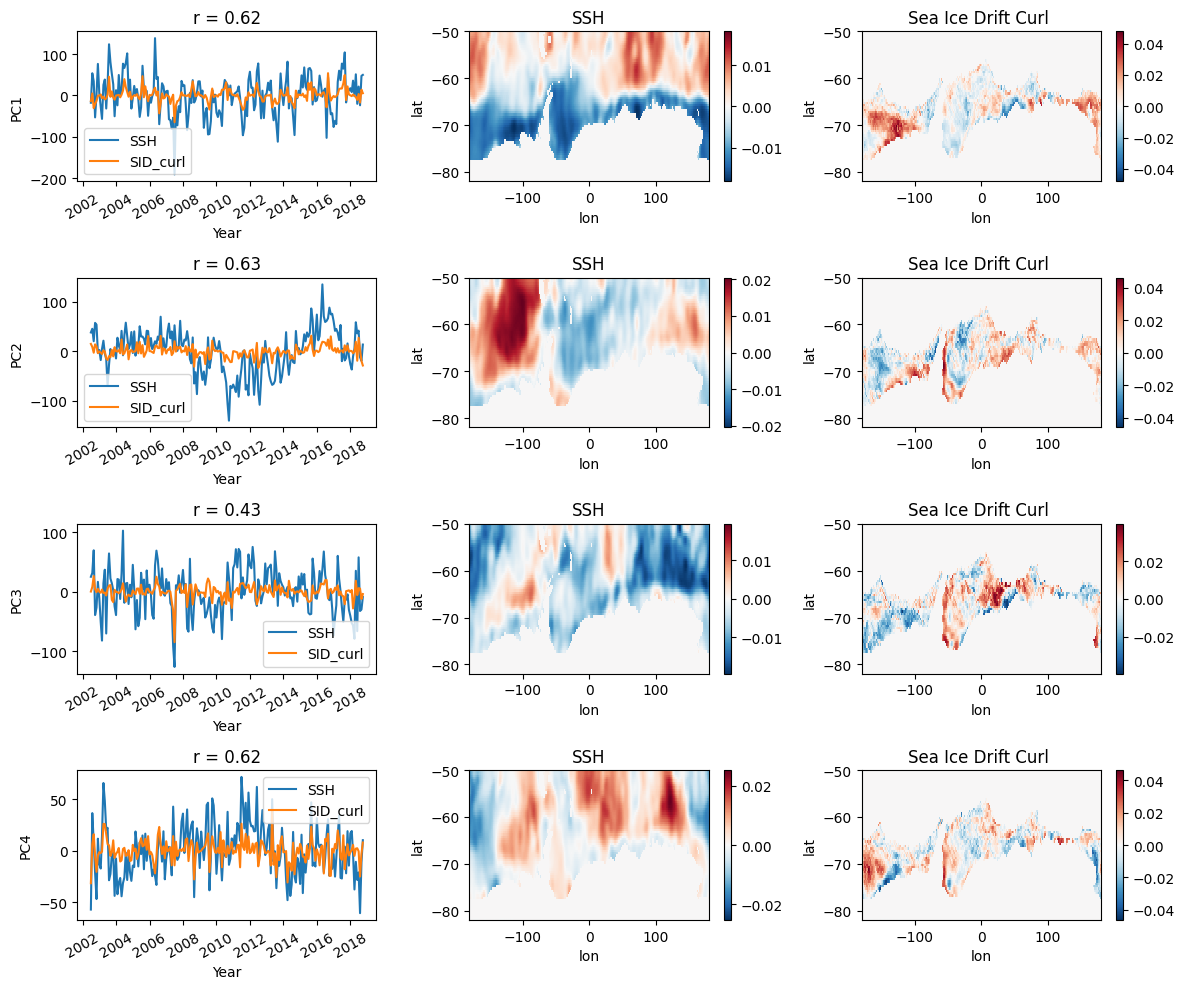

In [108]:
model = xe.cross.MCA(n_modes=22, standardize=True)
#print(dir(model))
print(dot_xa_masked.coords)
print(sid_curl_xa_masked.coords)

model.fit(dot_xa_masked, sid_curl_xa_masked, dim='time')
comps1, comps2 = model.components()  # Singular vectors (spatial patterns)
scores1, scores2 = model.scores()  # Expansion coefficients (temporal patterns)
s1 = scores1.values;
s2 = scores2.values
c1 = comps1.values;
c2 = comps2.values
print(path)
print(gridtype)
# Full path to the 'results' directory
results_dir = os.path.join(path, 'results')

# Check if the directory already exists
if os.path.exists(results_dir):
    print("Directory already exists")
else:
    # Create the directory if it doesn't exist
    os.makedirs(results_dir, exist_ok=True)
    print("Directory created!")
# write PCs on files
# fname = path + 'results/PCs_dot_' + gridtype + '.txt'
fname = path + 'results/PCs_sid_curl_' + gridtype + '_seas.txt'
with open(fname, 'w') as file:
    file.write('time\tPC1\tPC2\tPC3\n')
    for i in range(len(time_dot)):
        file.write(f'{time_dot[i]}\t{s1[0, i]}\t{s1[1, i]}\t{s1[2, i]}\n')
file.close()

# fname = path + 'results/PCs_ws_curl_' + gridtype + '.txt'
fname = path + 'results/PCs_sid_curl_' + gridtype + '_seas.txt'
with open(fname, 'w') as file:
    file.write('time\tPC1\tPC2\tPC3\n')
    for i in range(len(time_dot)):
        file.write(f'{time_dot[i]}\t{s2[0, i]}\t{s2[1, i]}\t{s2[2, i]}\n')
file.close()
#how can you change from using cross.MCA to calling the subplots PCA1, PCA2, PCA3 etc ...
r_pears = [];
p_pears = []
r_spear = [];
p_spear = []
for m in range(1, 5):
    x = scores1.sel(mode=m)
    y = scores2.sel(mode=m)
    r, p = scipy.stats.pearsonr(x, y)
    r_pears.append(np.round(r, 2));
    p_pears.append(np.round(p, 2))
    r, p = scipy.stats.spearmanr(x, y)
    r_spear.append(np.round(r, 2));
    p_spear.append(np.round(p, 2))
fig = plt.figure(figsize=(12, 10))

for i in range(0, 4):
    j = 3 * i + 1  # a = 2*(i+1) + i - 1

    plt.subplot(4, 3, j)
    scores1.sel(mode=i + 1).plot(label='SSH')
    scores2.sel(mode=i + 1).plot(label='SID_curl')
    plt.title('r = ' + str(r_spear[i]))
    plt.xlabel('Year');
    plt.ylabel('PC' + str(int(i + 1)))
    plt.xticks(rotation=30)
    plt.legend()

    plt.subplot(4, 3, j + 1)
    comps1.sel(mode=i + 1).plot()
    plt.title('SSH')

    plt.subplot(4, 3, j + 2)
    comps2.sel(mode=i + 1).plot()
    plt.title('Sea Ice Drift Curl ')

fig.tight_layout()

#fig.savefig(path + 'results/MCA_output_' + gridtype + '_seas.png')
# compute squared covariance fraction (equivalent to explained variance in PCA)
sq_cov_frac = model.squared_covariance_fraction()
scf = sq_cov_frac.values
cum_sum = np.cumsum(scf)
print('Cumulative sum of squares:', cum_sum)
print('Squared covariance fraction:', scf)
print(type(cum_sum))
print(len(cum_sum))
mode_percent = []
for i in range(len(cum_sum)):
    if i == 0:
        each_mode_percent = float(cum_sum[i])
        mode_percent.append(each_mode_percent)
    else:
        each_mode_percent = float(cum_sum[i] - cum_sum[i - 1])
        mode_percent.append(each_mode_percent)
print('PCA fraction', mode_percent)

In [109]:
#SSH vs WSC

Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lat      (lat) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lat      (lat) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
/Users/iw2g24/PycharmProjects/SSH_project/
remapcon
Directory already exists
Cumulative sum of squares: [0.4749506  0.66588813 0.73854331 0.79488149 0.83967664 0.87224476
 0.89499842 0.91339364 0.92655597 0.93893628 0.94787283 0.95473
 0.9596405  0.96406134 0.96826725 0.97162646 0.9745212  0.97702158
 0.97935352 0.98134575 0.98320482 0.98481626]
Squared covariance fraction: [0.4749506  0.19093753 0.07265518 0.05633818 0.04479515 0.03256812
 0.02275365 0.01839523 0.01316233 0.01238031 0.00893655 0.00

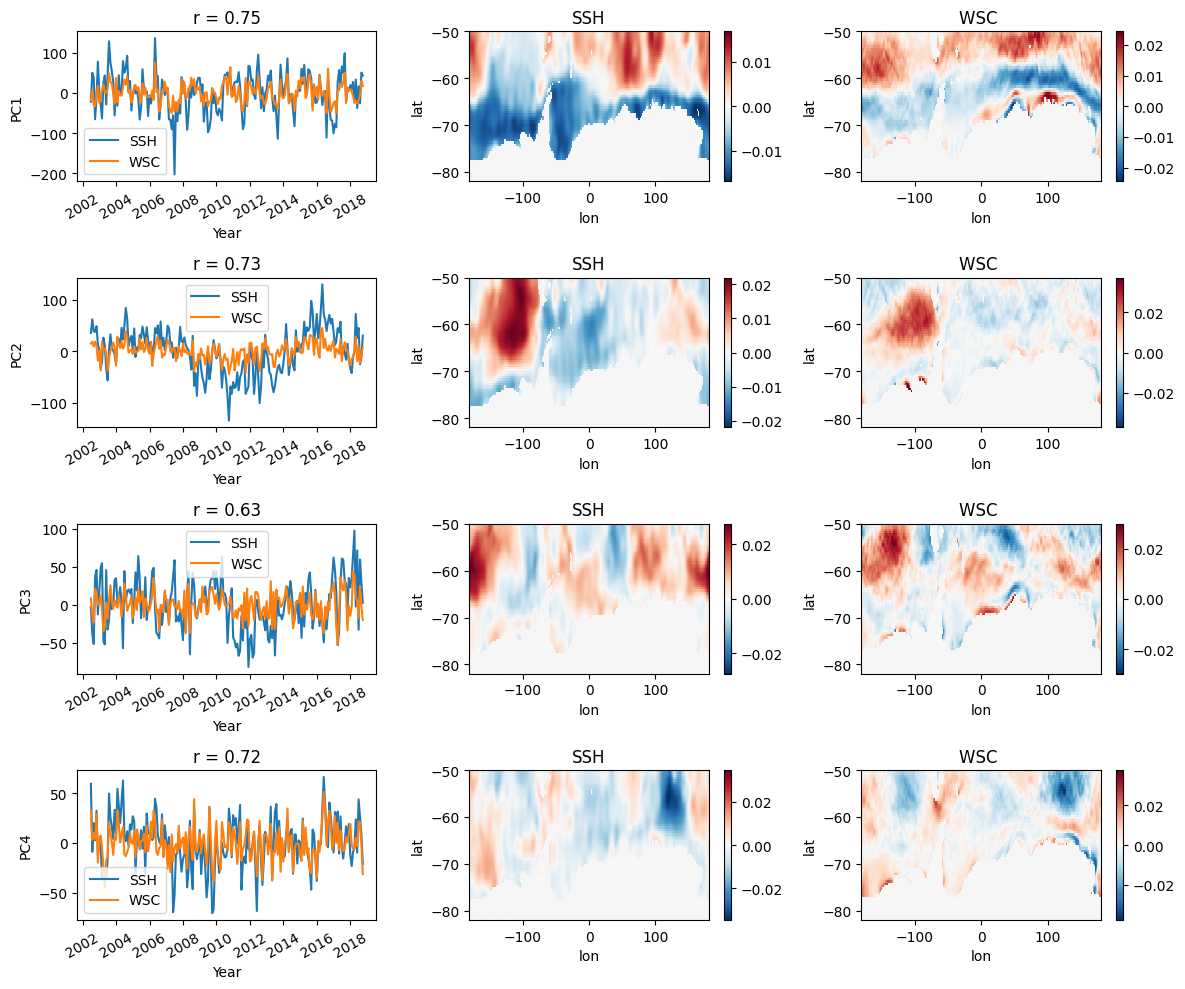

In [110]:
model = xe.cross.MCA(n_modes=22, standardize=True)
#print(dir(model))
print(dot_xa_masked.coords)
print(WSC_xa_masked.coords)

model.fit(dot_xa_masked, WSC_xa_masked, dim='time')
comps1, comps2 = model.components()  # Singular vectors (spatial patterns)
scores1, scores2 = model.scores()  # Expansion coefficients (temporal patterns)
s1 = scores1.values;
s2 = scores2.values
c1 = comps1.values;
c2 = comps2.values
print(path)
print(gridtype)
# Full path to the 'results' directory
results_dir = os.path.join(path, 'results')

# Check if the directory already exists
if os.path.exists(results_dir):
    print("Directory already exists")
else:
    # Create the directory if it doesn't exist
    os.makedirs(results_dir, exist_ok=True)
    print("Directory created!")
# write PCs on files
# fname = path + 'results/PCs_dot_' + gridtype + '.txt'
fname = path + 'results/PCs_sid_curl_' + gridtype + '_seas.txt'
with open(fname, 'w') as file:
    file.write('time\tPC1\tPC2\tPC3\n')
    for i in range(len(time_dot)):
        file.write(f'{time_dot[i]}\t{s1[0, i]}\t{s1[1, i]}\t{s1[2, i]}\n')
file.close()

# fname = path + 'results/PCs_ws_curl_' + gridtype + '.txt'
fname = path + 'results/PCs_sid_curl_' + gridtype + '_seas.txt'
with open(fname, 'w') as file:
    file.write('time\tPC1\tPC2\tPC3\n')
    for i in range(len(time_dot)):
        file.write(f'{time_dot[i]}\t{s2[0, i]}\t{s2[1, i]}\t{s2[2, i]}\n')
file.close()
#how can you change from using cross.MCA to calling the subplots PCA1, PCA2, PCA3 etc ...
r_pears = [];
p_pears = []
r_spear = [];
p_spear = []
for m in range(1, 5):
    x = scores1.sel(mode=m)
    y = scores2.sel(mode=m)
    r, p = scipy.stats.pearsonr(x, y)
    r_pears.append(np.round(r, 2));
    p_pears.append(np.round(p, 2))
    r, p = scipy.stats.spearmanr(x, y)
    r_spear.append(np.round(r, 2));
    p_spear.append(np.round(p, 2))
fig = plt.figure(figsize=(12, 10))

for i in range(0, 4):
    j = 3 * i + 1  # a = 2*(i+1) + i - 1

    plt.subplot(4, 3, j)
    scores1.sel(mode=i + 1).plot(label='SSH')
    scores2.sel(mode=i + 1).plot(label='WSC')
    plt.title('r = ' + str(r_spear[i]))
    plt.xlabel('Year');
    plt.ylabel('PC' + str(int(i + 1)))
    plt.xticks(rotation=30)
    plt.legend()

    plt.subplot(4, 3, j + 1)
    comps1.sel(mode=i + 1).plot()
    plt.title('SSH')

    plt.subplot(4, 3, j + 2)
    comps2.sel(mode=i + 1).plot()
    plt.title('WSC ')

fig.tight_layout()

#fig.savefig(path + 'results/MCA_output_' + gridtype + '_seas.png')
# compute squared covariance fraction (equivalent to explained variance in PCA)
sq_cov_frac = model.squared_covariance_fraction()
scf = sq_cov_frac.values
cum_sum = np.cumsum(scf)
print('Cumulative sum of squares:', cum_sum)
print('Squared covariance fraction:', scf)
print(type(cum_sum))
print(len(cum_sum))
mode_percent = []
for i in range(len(cum_sum)):
    if i == 0:
        each_mode_percent = float(cum_sum[i])
        mode_percent.append(each_mode_percent)
    else:
        each_mode_percent = float(cum_sum[i] - cum_sum[i - 1])
        mode_percent.append(each_mode_percent)
print('PCA fraction', mode_percent)

In [111]:
#HERE I REPEAT THE MCA ANALYSIS FOR SID_CURL vs SIC !!!

Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lat      (lat) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lat      (lat) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
/Users/iw2g24/PycharmProjects/SSH_project/
remapcon
Directory already exists
Cumulative sum of squares: [0.48892149 0.61490095 0.69276237 0.76062324 0.80394508 0.83665453
 0.86693888 0.88354987 0.89925355 0.9104596  0.91922109 0.92696593
 0.93343138 0.93944052 0.94490416 0.9500237  0.95457037 0.95862425
 0.96226752 0.96580497 0.96889834 0.97192736]
Squared covariance fraction: [0.48892149 0.12597947 0.07786142 0.06786086 0.04332184 0.03270945
 0.03028435 0.01661099 0.01570368 0.01120604 0.00876149 0

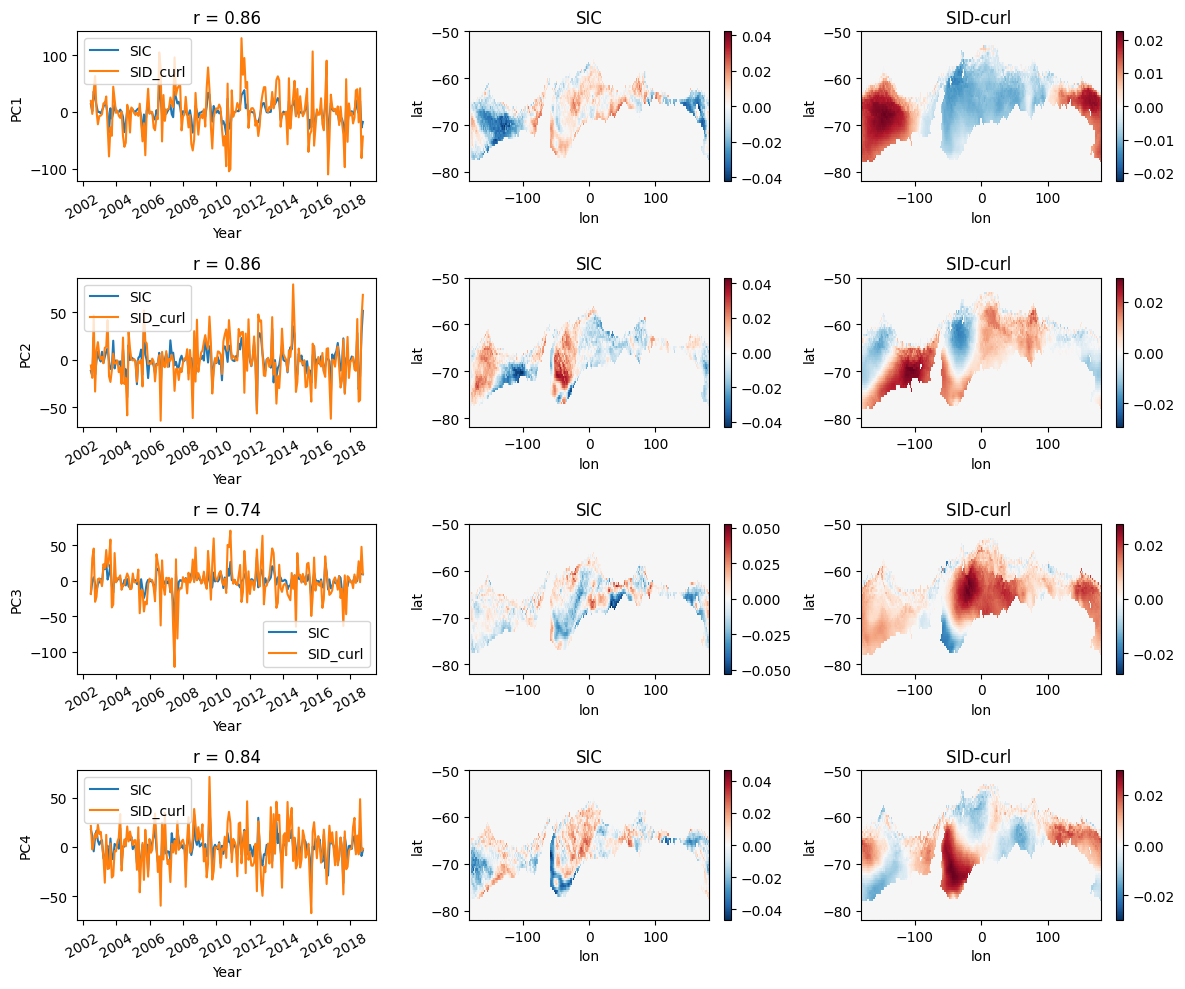

In [112]:
import inspect

model = xe.cross.MCA(n_modes=22, standardize=True)
#print(dir(model))
print(sid_curl_xa_masked.coords)
print(seaice_xa_masked.coords)

model.fit(sid_curl_xa_masked, seaice_xa_masked, dim='time')
comps1, comps2 = model.components()  # Singular vectors (spatial patterns)
scores1, scores2 = model.scores()  # Expansion coefficients (temporal patterns)
s1 = scores1.values;
s2 = scores2.values
c1 = comps1.values;
c2 = comps2.values
print(path)
print(gridtype)
# Full path to the 'results' directory
results_dir = os.path.join(path, 'results')

# Check if the directory already exists
if os.path.exists(results_dir):
    print("Directory already exists")
else:
    # Create the directory if it doesn't exist
    os.makedirs(results_dir, exist_ok=True)
    print("Directory created!")
# write PCs on files
# fname = path + 'results/PCs_dot_' + gridtype + '.txt'
fname = path + 'results/PCs_sid_curl_sic_' + gridtype + '_seas.txt'
with open(fname, 'w') as file:
    file.write('time\tPC1\tPC2\tPC3\n')
    for i in range(len(time_dot)):
        file.write(f'{time_dot[i]}\t{s1[0, i]}\t{s1[1, i]}\t{s1[2, i]}\n')
file.close()

# fname = path + 'results/PCs_ws_curl_' + gridtype + '.txt'
fname = path + 'results/PCs_sic_sidc_' + gridtype + '_seas.txt'
with open(fname, 'w') as file:
    file.write('time\tPC1\tPC2\tPC3\n')
    for i in range(len(time_dot)):
        file.write(f'{time_dot[i]}\t{s2[0, i]}\t{s2[1, i]}\t{s2[2, i]}\n')
file.close()
#how can you change from using cross.MCA to calling the subplots PCA1, PCA2, PCA3 etc ...
r_pears = [];
p_pears = []
r_spear = [];
p_spear = []
for m in range(1, 5):
    x = scores1.sel(mode=m)
    y = scores2.sel(mode=m)
    r, p = scipy.stats.pearsonr(x, y)
    r_pears.append(np.round(r, 2));
    p_pears.append(np.round(p, 2))
    r, p = scipy.stats.spearmanr(x, y)
    r_spear.append(np.round(r, 2));
    p_spear.append(np.round(p, 2))
fig = plt.figure(figsize=(12, 10))

for i in range(0, 4):
    j = 3 * i + 1  # a = 2*(i+1) + i - 1

    plt.subplot(4, 3, j)
    scores1.sel(mode=i + 1).plot(label='SIC')
    scores2.sel(mode=i + 1).plot(label='SID_curl')
    plt.title('r = ' + str(r_spear[i]))
    plt.xlabel('Year');
    plt.ylabel('PC' + str(int(i + 1)))
    plt.xticks(rotation=30)
    plt.legend()

    plt.subplot(4, 3, j + 1)
    comps1.sel(mode=i + 1).plot()
    plt.title('SIC')

    plt.subplot(4, 3, j + 2)
    comps2.sel(mode=i + 1).plot()
    plt.title('SID-curl ')

fig.tight_layout()

#fig.savefig(path + 'results/MCA_output_' + gridtype + '_seas.png')
# compute squared covariance fraction (equivalent to explained variance in PCA)
sq_cov_frac = model.squared_covariance_fraction()
scf = sq_cov_frac.values
cum_sum = np.cumsum(scf)
print('Cumulative sum of squares:', cum_sum)
print('Squared covariance fraction:', scf)
print(type(cum_sum))
print(len(cum_sum))
mode_percent = []
for i in range(len(cum_sum)):
    if i == 0:
        each_mode_percent = float(cum_sum[i])
        mode_percent.append(each_mode_percent)
    else:
        each_mode_percent = float(cum_sum[i] - cum_sum[i - 1])
        mode_percent.append(each_mode_percent)
print('PCA fraction', mode_percent)

In [113]:
#HERE I REPEAT THE MCA ANALYSIS FOR SID_CURL vs U  !!!

Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lat      (lat) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lat      (lat) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
/Users/iw2g24/PycharmProjects/SSH_project/
remapcon
Directory already exists
Cumulative sum of squares: [0.34623924 0.47292281 0.59350346 0.68046215 0.75050953 0.78465723
 0.8111817  0.83319657 0.85152622 0.86653569 0.8802304  0.89157992
 0.90220348 0.91155071 0.92054888 0.92810581 0.93522278 0.94185504
 0.94773296 0.95260681 0.95720127 0.96143018]
Squared covariance fraction: [0.34623924 0.12668357 0.12058066 0.08695869 0.07004738 0.0341477
 0.02652447 0.02201487 0.01832965 0.01500947 0.01369472 0.

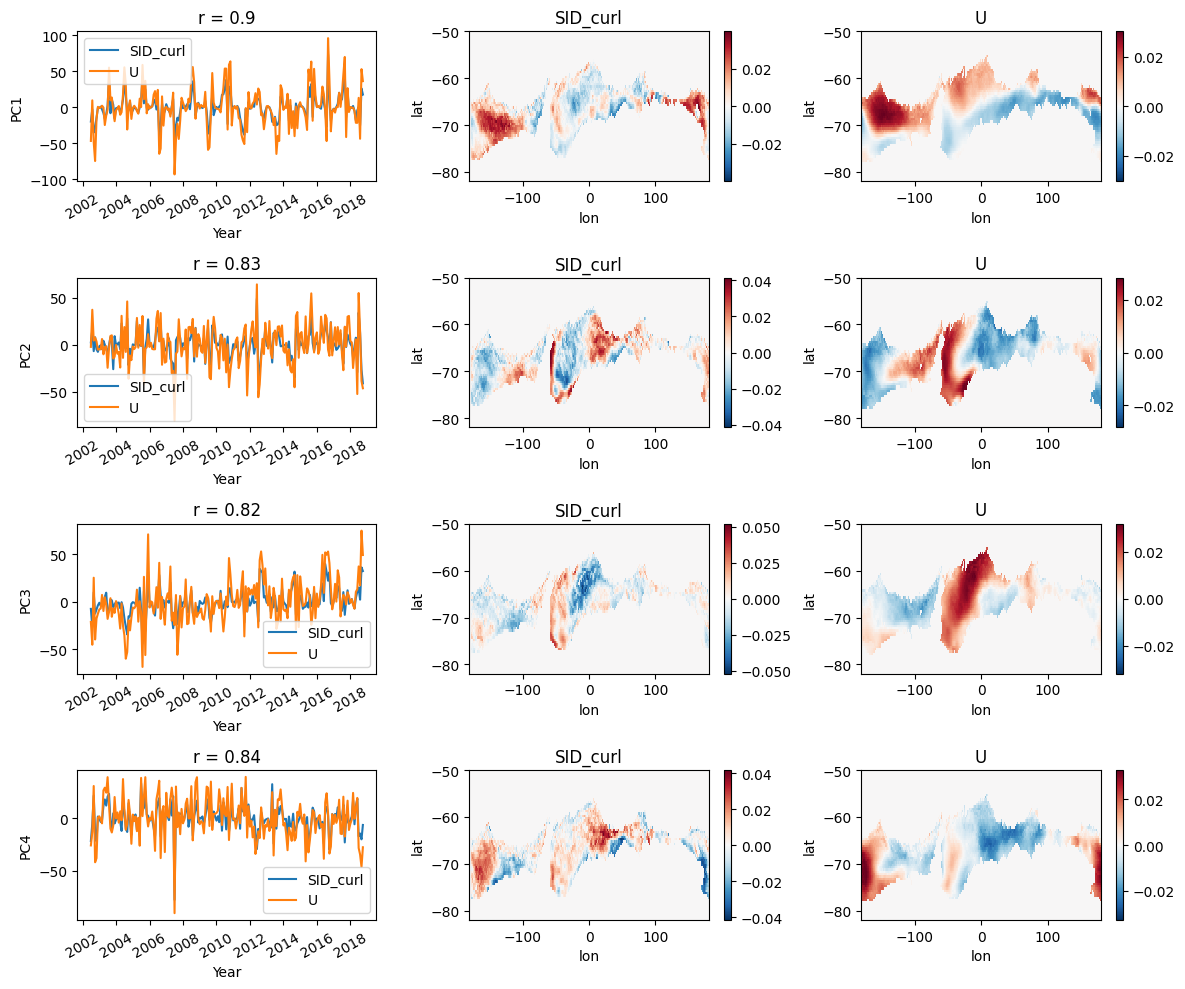

In [114]:
model = xe.cross.MCA(n_modes=22, standardize=True)
#print(dir(model))
print(sid_curl_xa_masked.coords)
print(U_xa_masked.coords)

model.fit(sid_curl_xa_masked, U_xa_masked, dim='time')
comps1, comps2 = model.components()  # Singular vectors (spatial patterns)
scores1, scores2 = model.scores()  # Expansion coefficients (temporal patterns)
s1 = scores1.values;
s2 = scores2.values
c1 = comps1.values;
c2 = comps2.values
print(path)
print(gridtype)
# Full path to the 'results' directory
results_dir = os.path.join(path, 'results')

# Check if the directory already exists
if os.path.exists(results_dir):
    print("Directory already exists")
else:
    # Create the directory if it doesn't exist
    os.makedirs(results_dir, exist_ok=True)
    print("Directory created!")
# write PCs on files
# fname = path + 'results/PCs_dot_' + gridtype + '.txt'
fname = path + 'results/PCs_sid_curl_U_' + gridtype + '_seas.txt'
with open(fname, 'w') as file:
    file.write('time\tPC1\tPC2\tPC3\n')
    for i in range(len(time_dot)):
        file.write(f'{time_dot[i]}\t{s1[0, i]}\t{s1[1, i]}\t{s1[2, i]}\n')
file.close()

# fname = path + 'results/PCs_ws_curl_' + gridtype + '.txt'
fname = path + 'results/PCs_U_sidc_' + gridtype + '_seas.txt'
with open(fname, 'w') as file:
    file.write('time\tPC1\tPC2\tPC3\n')
    for i in range(len(time_dot)):
        file.write(f'{time_dot[i]}\t{s2[0, i]}\t{s2[1, i]}\t{s2[2, i]}\n')
file.close()
#how can you change from using cross.MCA to calling the subplots PCA1, PCA2, PCA3 etc ...
r_pears = [];
p_pears = []
r_spear = [];
p_spear = []
for m in range(1, 5):
    x = scores1.sel(mode=m)
    y = scores2.sel(mode=m)
    r, p = scipy.stats.pearsonr(x, y)
    r_pears.append(np.round(r, 2));
    p_pears.append(np.round(p, 2))
    r, p = scipy.stats.spearmanr(x, y)
    r_spear.append(np.round(r, 2));
    p_spear.append(np.round(p, 2))
fig = plt.figure(figsize=(12, 10))

for i in range(0, 4):
    j = 3 * i + 1  # a = 2*(i+1) + i - 1

    plt.subplot(4, 3, j)
    scores1.sel(mode=i + 1).plot(label='SID_curl')
    scores2.sel(mode=i + 1).plot(label='U')
    plt.title('r = ' + str(r_spear[i]))
    plt.xlabel('Year');
    plt.ylabel('PC' + str(int(i + 1)))
    plt.xticks(rotation=30)
    plt.legend()

    plt.subplot(4, 3, j + 1)
    comps1.sel(mode=i + 1).plot()
    plt.title('SID_curl')

    plt.subplot(4, 3, j + 2)
    comps2.sel(mode=i + 1).plot()
    plt.title('U')

fig.tight_layout()

#fig.savefig(path + 'results/MCA_output_' + gridtype + '_seas.png')
# compute squared covariance fraction (equivalent to explained variance in PCA)
sq_cov_frac = model.squared_covariance_fraction()
scf = sq_cov_frac.values
cum_sum = np.cumsum(scf)
print('Cumulative sum of squares:', cum_sum)
print('Squared covariance fraction:', scf)
print(type(cum_sum))
print(len(cum_sum))
mode_percent = []
for i in range(len(cum_sum)):
    if i == 0:
        each_mode_percent = float(cum_sum[i])
        mode_percent.append(each_mode_percent)
    else:
        each_mode_percent = float(cum_sum[i] - cum_sum[i - 1])
        mode_percent.append(each_mode_percent)
print('PCA fraction', mode_percent)

In [115]:
#HERE I REPEAT THE MCA ANALYSIS FOR SIC vs U  !!!

Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lat      (lat) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lat      (lat) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
/Users/iw2g24/PycharmProjects/SSH_project/
remapcon
Directory already exists
Cumulative sum of squares: [0.61745677 0.72484848 0.81624253 0.87593597 0.9038546  0.9210487
 0.93364708 0.94396387 0.95269724 0.95796448 0.96271623 0.96704981
 0.97075341 0.97431765 0.97714592 0.97950949 0.98180544 0.9837018
 0.98545182 0.98699403 0.98831146 0.98957268]
Squared covariance fraction: [0.61745677 0.1073917  0.09139406 0.05969344 0.02791863 0.01719411
 0.01259837 0.01031679 0.00873337 0.00526724 0.00475175 0.0

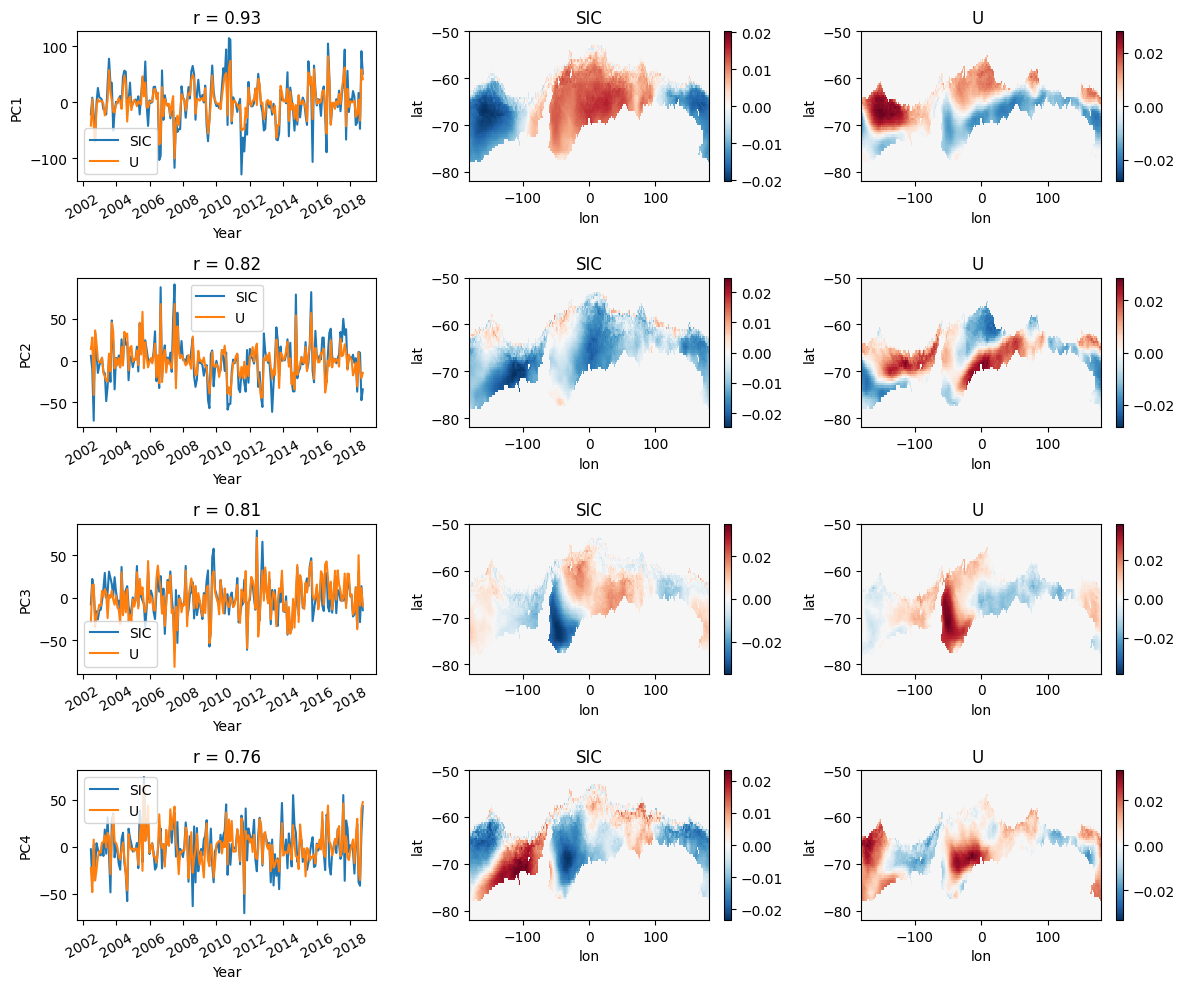

In [116]:
model = xe.cross.MCA(n_modes=22, standardize=True)
#print(dir(model))
print(seaice_xa_masked.coords)
print(U_xa_masked.coords)

model.fit(seaice_xa_masked, U_xa_masked, dim='time')
comps1, comps2 = model.components()  # Singular vectors (spatial patterns)
scores1, scores2 = model.scores()  # Expansion coefficients (temporal patterns)
s1 = scores1.values;
s2 = scores2.values
c1 = comps1.values;
c2 = comps2.values
print(path)
print(gridtype)
# Full path to the 'results' directory
results_dir = os.path.join(path, 'results')

# Check if the directory already exists
if os.path.exists(results_dir):
    print("Directory already exists")
else:
    # Create the directory if it doesn't exist
    os.makedirs(results_dir, exist_ok=True)
    print("Directory created!")
# write PCs on files
# fname = path + 'results/PCs_dot_' + gridtype + '.txt'
fname = path + 'results/PCs_sic_U_' + gridtype + '_seas.txt'
with open(fname, 'w') as file:
    file.write('time\tPC1\tPC2\tPC3\n')
    for i in range(len(time_dot)):
        file.write(f'{time_dot[i]}\t{s1[0, i]}\t{s1[1, i]}\t{s1[2, i]}\n')
file.close()

# fname = path + 'results/PCs_ws_curl_' + gridtype + '.txt'
fname = path + 'results/PCs_sic_U_' + gridtype + '_seas.txt'
with open(fname, 'w') as file:
    file.write('time\tPC1\tPC2\tPC3\n')
    for i in range(len(time_dot)):
        file.write(f'{time_dot[i]}\t{s2[0, i]}\t{s2[1, i]}\t{s2[2, i]}\n')
file.close()
#how can you change from using cross.MCA to calling the subplots PCA1, PCA2, PCA3 etc ...
r_pears = [];
p_pears = []
r_spear = [];
p_spear = []
for m in range(1, 5):
    x = scores1.sel(mode=m)
    y = scores2.sel(mode=m)
    r, p = scipy.stats.pearsonr(x, y)
    r_pears.append(np.round(r, 2));
    p_pears.append(np.round(p, 2))
    r, p = scipy.stats.spearmanr(x, y)
    r_spear.append(np.round(r, 2));
    p_spear.append(np.round(p, 2))
fig = plt.figure(figsize=(12, 10))

for i in range(0, 4):
    j = 3 * i + 1  # a = 2*(i+1) + i - 1

    plt.subplot(4, 3, j)
    scores1.sel(mode=i + 1).plot(label='SIC')
    scores2.sel(mode=i + 1).plot(label='U')
    plt.title('r = ' + str(r_spear[i]))
    plt.xlabel('Year');
    plt.ylabel('PC' + str(int(i + 1)))
    plt.xticks(rotation=30)
    plt.legend()

    plt.subplot(4, 3, j + 1)
    comps1.sel(mode=i + 1).plot()
    plt.title('SIC')

    plt.subplot(4, 3, j + 2)
    comps2.sel(mode=i + 1).plot()
    plt.title('U ')

fig.tight_layout()

#fig.savefig(path + 'results/MCA_output_' + gridtype + '_seas.png')
# compute squared covariance fraction (equivalent to explained variance in PCA)
sq_cov_frac = model.squared_covariance_fraction()
scf = sq_cov_frac.values
cum_sum = np.cumsum(scf)
print('Cumulative sum of squares:', cum_sum)
print('Squared covariance fraction:', scf)
print(type(cum_sum))
print(len(cum_sum))
mode_percent = []
for i in range(len(cum_sum)):
    if i == 0:
        each_mode_percent = float(cum_sum[i])
        mode_percent.append(each_mode_percent)
    else:
        each_mode_percent = float(cum_sum[i] - cum_sum[i - 1])
        mode_percent.append(each_mode_percent)
print('PCA fraction', mode_percent)

In [117]:
#WSC and OSC

Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lat      (lat) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lat      (lat) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
/Users/iw2g24/PycharmProjects/SSH_project/
remapcon
Directory already exists
Cumulative sum of squares: [0.34503301 0.44936215 0.52684101 0.59085618 0.63365674 0.6721147
 0.7081688  0.74199022 0.76495019 0.78602379 0.80518459 0.82073583
 0.83551166 0.84905142 0.8615367  0.87379727 0.88484342 0.89405268
 0.90201696 0.90981839 0.91722501 0.92417163]
Squared covariance fraction: [0.34503301 0.10432914 0.07747886 0.06401517 0.04280056 0.03845796
 0.0360541  0.03382143 0.02295996 0.0210736  0.0191608  0.

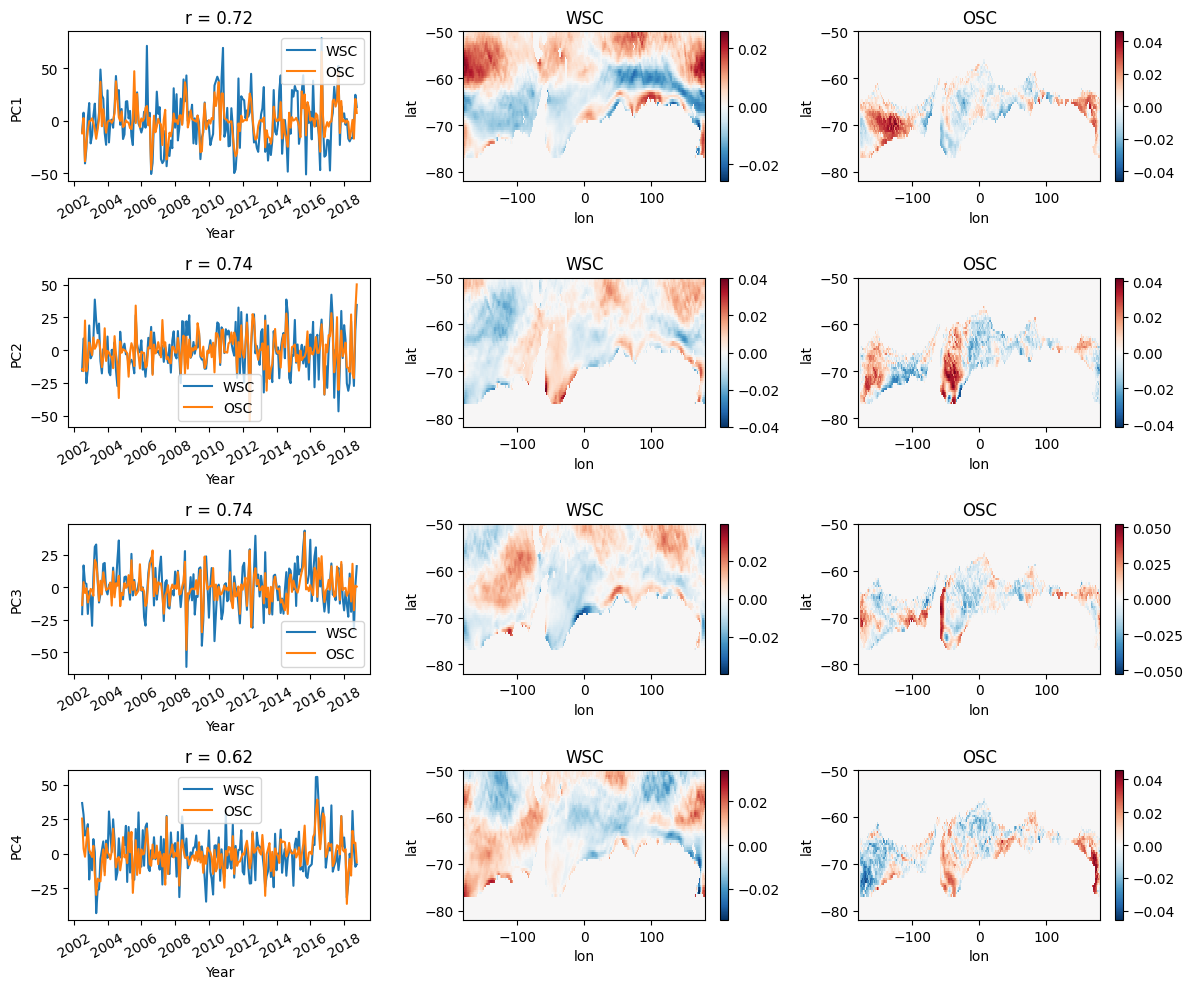

In [118]:
model = xe.cross.MCA(n_modes=22, standardize=True)
#print(dir(model))
print(WSC_xa_masked.coords)
print(total_osc_masked.coords)

model.fit(WSC_xa_masked, total_osc_masked, dim='time')
comps1, comps2 = model.components()  # Singular vectors (spatial patterns)
scores1, scores2 = model.scores()  # Expansion coefficients (temporal patterns)
s1 = scores1.values;
s2 = scores2.values
c1 = comps1.values;
c2 = comps2.values
print(path)
print(gridtype)
# Full path to the 'results' directory
results_dir = os.path.join(path, 'results')

# Check if the directory already exists
if os.path.exists(results_dir):
    print("Directory already exists")
else:
    # Create the directory if it doesn't exist
    os.makedirs(results_dir, exist_ok=True)
    print("Directory created!")
# write PCs on files
# fname = path + 'results/PCs_dot_' + gridtype + '.txt'
fname = path + 'results/PCs_sic_U_' + gridtype + '_seas.txt'
with open(fname, 'w') as file:
    file.write('time\tPC1\tPC2\tPC3\n')
    for i in range(len(time_dot)):
        file.write(f'{time_dot[i]}\t{s1[0, i]}\t{s1[1, i]}\t{s1[2, i]}\n')
file.close()

# fname = path + 'results/PCs_ws_curl_' + gridtype + '.txt'
fname = path + 'results/PCs_sic_U_' + gridtype + '_seas.txt'
with open(fname, 'w') as file:
    file.write('time\tPC1\tPC2\tPC3\n')
    for i in range(len(time_dot)):
        file.write(f'{time_dot[i]}\t{s2[0, i]}\t{s2[1, i]}\t{s2[2, i]}\n')
file.close()
#how can you change from using cross.MCA to calling the subplots PCA1, PCA2, PCA3 etc ...
r_pears = [];
p_pears = []
r_spear = [];
p_spear = []
for m in range(1, 5):
    x = scores1.sel(mode=m)
    y = scores2.sel(mode=m)
    r, p = scipy.stats.pearsonr(x, y)
    r_pears.append(np.round(r, 2));
    p_pears.append(np.round(p, 2))
    r, p = scipy.stats.spearmanr(x, y)
    r_spear.append(np.round(r, 2));
    p_spear.append(np.round(p, 2))
fig = plt.figure(figsize=(12, 10))

for i in range(0, 4):
    j = 3 * i + 1  # a = 2*(i+1) + i - 1

    plt.subplot(4, 3, j)
    scores1.sel(mode=i + 1).plot(label='WSC')
    scores2.sel(mode=i + 1).plot(label='OSC')
    plt.title('r = ' + str(r_spear[i]))
    plt.xlabel('Year');
    plt.ylabel('PC' + str(int(i + 1)))
    plt.xticks(rotation=30)
    plt.legend()

    plt.subplot(4, 3, j + 1)
    comps1.sel(mode=i + 1).plot()
    plt.title('WSC')

    plt.subplot(4, 3, j + 2)
    comps2.sel(mode=i + 1).plot()
    plt.title('OSC')

fig.tight_layout()

#fig.savefig(path + 'results/MCA_output_' + gridtype + '_seas.png')
# compute squared covariance fraction (equivalent to explained variance in PCA)
sq_cov_frac = model.squared_covariance_fraction()
scf = sq_cov_frac.values
cum_sum = np.cumsum(scf)
print('Cumulative sum of squares:', cum_sum)
print('Squared covariance fraction:', scf)
print(type(cum_sum))
print(len(cum_sum))
mode_percent = []
for i in range(len(cum_sum)):
    if i == 0:
        each_mode_percent = float(cum_sum[i])
        mode_percent.append(each_mode_percent)
    else:
        each_mode_percent = float(cum_sum[i] - cum_sum[i - 1])
        mode_percent.append(each_mode_percent)
print('PCA fraction', mode_percent)

In [119]:
#OSC and SID_C

Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lat      (lat) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lat      (lat) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
/Users/iw2g24/PycharmProjects/SSH_project/
remapcon
Directory already exists
Cumulative sum of squares: [0.18941877 0.30598663 0.38520125 0.45784591 0.51860321 0.56032569
 0.59804591 0.62884657 0.65781988 0.68170224 0.7029115  0.72225038
 0.7405377  0.7579854  0.77352642 0.78820643 0.80158654 0.81419305
 0.8257628  0.83628257 0.84605299 0.85551789]
Squared covariance fraction: [0.18941877 0.11656786 0.07921462 0.07264467 0.0607573  0.04172247
 0.03772022 0.03080065 0.02897332 0.02388236 0.02120926 0

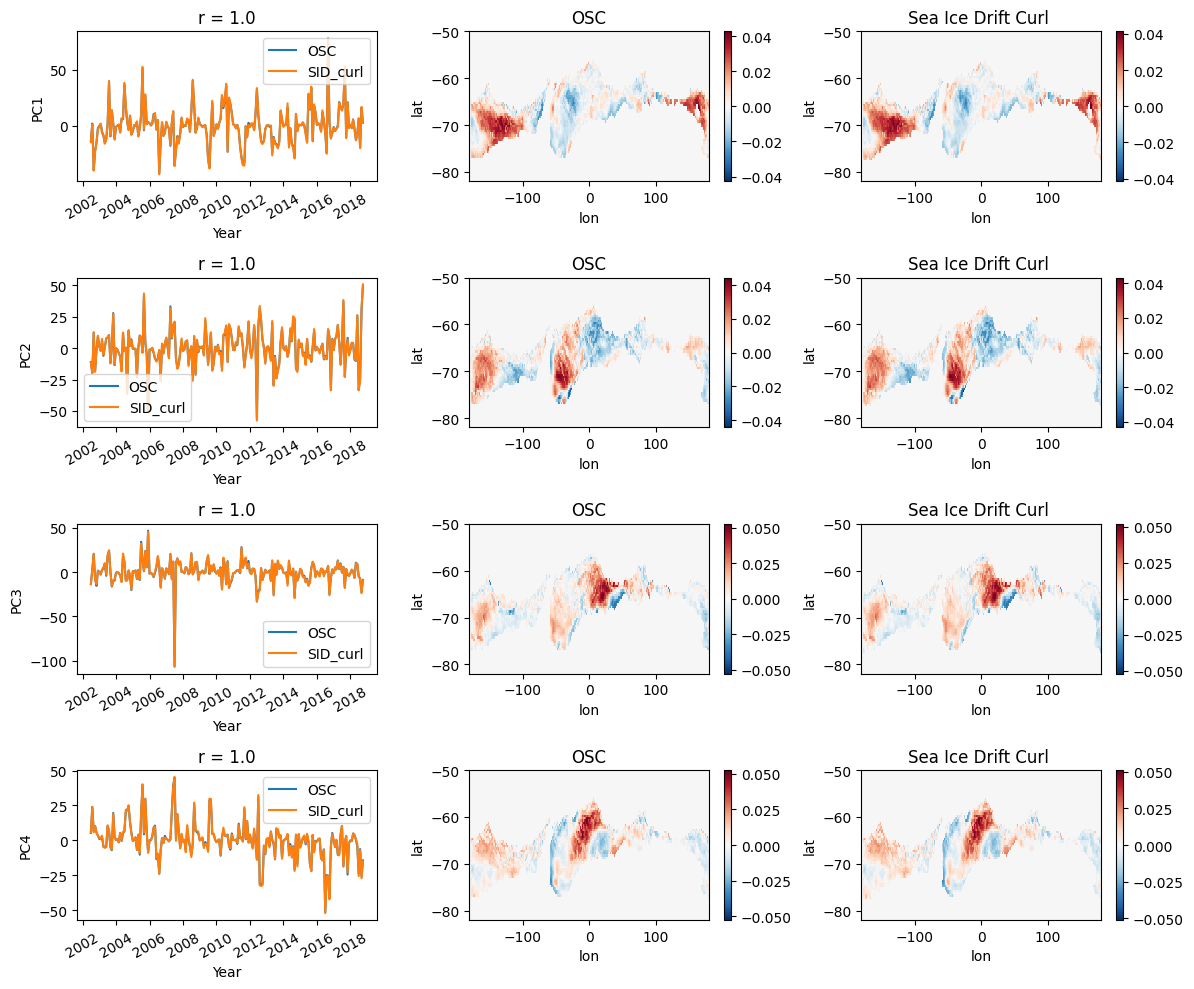

In [120]:
model = xe.cross.MCA(n_modes=22, standardize=True)
#print(dir(model))
print(total_osc_masked.coords)
print(sid_curl_xa_masked.coords)

model.fit(total_osc_masked, sid_curl_xa_masked, dim='time')
comps1, comps2 = model.components()  # Singular vectors (spatial patterns)
scores1, scores2 = model.scores()  # Expansion coefficients (temporal patterns)
s1 = scores1.values;
s2 = scores2.values
c1 = comps1.values;
c2 = comps2.values
print(path)
print(gridtype)
# Full path to the 'results' directory
results_dir = os.path.join(path, 'results')

# Check if the directory already exists
if os.path.exists(results_dir):
    print("Directory already exists")
else:
    # Create the directory if it doesn't exist
    os.makedirs(results_dir, exist_ok=True)
    print("Directory created!")
# write PCs on files
# fname = path + 'results/PCs_dot_' + gridtype + '.txt'
fname = path + 'results/PCs_sid_curl_' + gridtype + '_seas.txt'
with open(fname, 'w') as file:
    file.write('time\tPC1\tPC2\tPC3\n')
    for i in range(len(time_dot)):
        file.write(f'{time_dot[i]}\t{s1[0, i]}\t{s1[1, i]}\t{s1[2, i]}\n')
file.close()

# fname = path + 'results/PCs_ws_curl_' + gridtype + '.txt'
fname = path + 'results/PCs_sid_curl_' + gridtype + '_seas.txt'
with open(fname, 'w') as file:
    file.write('time\tPC1\tPC2\tPC3\n')
    for i in range(len(time_dot)):
        file.write(f'{time_dot[i]}\t{s2[0, i]}\t{s2[1, i]}\t{s2[2, i]}\n')
file.close()
#how can you change from using cross.MCA to calling the subplots PCA1, PCA2, PCA3 etc ...
r_pears = [];
p_pears = []
r_spear = [];
p_spear = []
for m in range(1, 5):
    x = scores1.sel(mode=m)
    y = scores2.sel(mode=m)
    r, p = scipy.stats.pearsonr(x, y)
    r_pears.append(np.round(r, 2));
    p_pears.append(np.round(p, 2))
    r, p = scipy.stats.spearmanr(x, y)
    r_spear.append(np.round(r, 2));
    p_spear.append(np.round(p, 2))
fig = plt.figure(figsize=(12, 10))

for i in range(0, 4):
    j = 3 * i + 1  # a = 2*(i+1) + i - 1

    plt.subplot(4, 3, j)
    scores1.sel(mode=i + 1).plot(label='OSC')
    scores2.sel(mode=i + 1).plot(label='SID_curl')
    plt.title('r = ' + str(r_spear[i]))
    plt.xlabel('Year');
    plt.ylabel('PC' + str(int(i + 1)))
    plt.xticks(rotation=30)
    plt.legend()

    plt.subplot(4, 3, j + 1)
    comps1.sel(mode=i + 1).plot()
    plt.title('OSC')

    plt.subplot(4, 3, j + 2)
    comps2.sel(mode=i + 1).plot()
    plt.title('Sea Ice Drift Curl ')

fig.tight_layout()

#fig.savefig(path + 'results/MCA_output_' + gridtype + '_seas.png')
# compute squared covariance fraction (equivalent to explained variance in PCA)
sq_cov_frac = model.squared_covariance_fraction()
scf = sq_cov_frac.values
cum_sum = np.cumsum(scf)
print('Cumulative sum of squares:', cum_sum)
print('Squared covariance fraction:', scf)
print(type(cum_sum))
print(len(cum_sum))
mode_percent = []
for i in range(len(cum_sum)):
    if i == 0:
        each_mode_percent = float(cum_sum[i])
        mode_percent.append(each_mode_percent)
    else:
        each_mode_percent = float(cum_sum[i] - cum_sum[i - 1])
        mode_percent.append(each_mode_percent)
print('PCA fraction', mode_percent)

In [121]:
#SID_C and WSC

Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lat      (lat) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lat      (lat) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
/Users/iw2g24/PycharmProjects/SSH_project/
remapcon
Directory already exists
Cumulative sum of squares: [0.35759984 0.46252821 0.53865685 0.60184602 0.64389224 0.6810902
 0.7170551  0.74900256 0.77143648 0.79174114 0.81032545 0.82606074
 0.84100876 0.85484429 0.86705881 0.87872379 0.88841612 0.89762802
 0.90572018 0.91309182 0.92010823 0.92678402]
Squared covariance fraction: [0.35759984 0.10492837 0.07612864 0.06318917 0.04204622 0.03719796
 0.0359649  0.03194746 0.02243392 0.02030465 0.01858431 0.

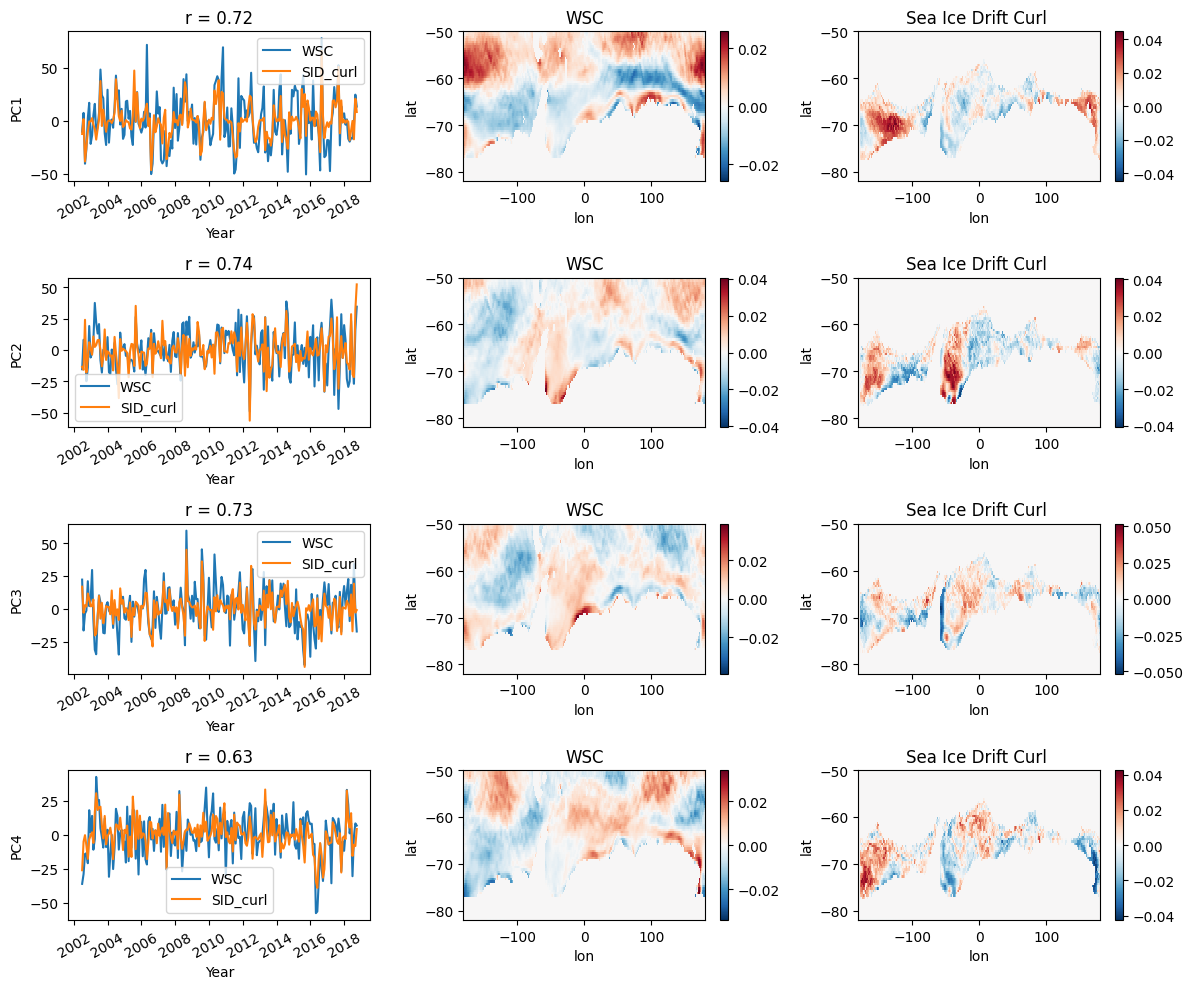

In [122]:
model = xe.cross.MCA(n_modes=22, standardize=True)
#print(dir(model))
print(WSC_xa_masked.coords)
print(sid_curl_xa_masked.coords)

model.fit(WSC_xa_masked, sid_curl_xa_masked, dim='time')
comps1, comps2 = model.components()  # Singular vectors (spatial patterns)
scores1, scores2 = model.scores()  # Expansion coefficients (temporal patterns)
s1 = scores1.values;
s2 = scores2.values
c1 = comps1.values;
c2 = comps2.values
print(path)
print(gridtype)
# Full path to the 'results' directory
results_dir = os.path.join(path, 'results')

# Check if the directory already exists
if os.path.exists(results_dir):
    print("Directory already exists")
else:
    # Create the directory if it doesn't exist
    os.makedirs(results_dir, exist_ok=True)
    print("Directory created!")
# write PCs on files
# fname = path + 'results/PCs_dot_' + gridtype + '.txt'
fname = path + 'results/PCs_sid_curl_' + gridtype + '_seas.txt'
with open(fname, 'w') as file:
    file.write('time\tPC1\tPC2\tPC3\n')
    for i in range(len(time_dot)):
        file.write(f'{time_dot[i]}\t{s1[0, i]}\t{s1[1, i]}\t{s1[2, i]}\n')
file.close()

# fname = path + 'results/PCs_ws_curl_' + gridtype + '.txt'
fname = path + 'results/PCs_sid_curl_' + gridtype + '_seas.txt'
with open(fname, 'w') as file:
    file.write('time\tPC1\tPC2\tPC3\n')
    for i in range(len(time_dot)):
        file.write(f'{time_dot[i]}\t{s2[0, i]}\t{s2[1, i]}\t{s2[2, i]}\n')
file.close()
#how can you change from using cross.MCA to calling the subplots PCA1, PCA2, PCA3 etc ...
r_pears = [];
p_pears = []
r_spear = [];
p_spear = []
for m in range(1, 5):
    x = scores1.sel(mode=m)
    y = scores2.sel(mode=m)
    r, p = scipy.stats.pearsonr(x, y)
    r_pears.append(np.round(r, 2));
    p_pears.append(np.round(p, 2))
    r, p = scipy.stats.spearmanr(x, y)
    r_spear.append(np.round(r, 2));
    p_spear.append(np.round(p, 2))
fig = plt.figure(figsize=(12, 10))

for i in range(0, 4):
    j = 3 * i + 1  # a = 2*(i+1) + i - 1

    plt.subplot(4, 3, j)
    scores1.sel(mode=i + 1).plot(label='WSC')
    scores2.sel(mode=i + 1).plot(label='SID_curl')
    plt.title('r = ' + str(r_spear[i]))
    plt.xlabel('Year');
    plt.ylabel('PC' + str(int(i + 1)))
    plt.xticks(rotation=30)
    plt.legend()

    plt.subplot(4, 3, j + 1)
    comps1.sel(mode=i + 1).plot()
    plt.title('WSC')

    plt.subplot(4, 3, j + 2)
    comps2.sel(mode=i + 1).plot()
    plt.title('Sea Ice Drift Curl ')

fig.tight_layout()

#fig.savefig(path + 'results/MCA_output_' + gridtype + '_seas.png')
# compute squared covariance fraction (equivalent to explained variance in PCA)
sq_cov_frac = model.squared_covariance_fraction()
scf = sq_cov_frac.values
cum_sum = np.cumsum(scf)
print('Cumulative sum of squares:', cum_sum)
print('Squared covariance fraction:', scf)
print(type(cum_sum))
print(len(cum_sum))
mode_percent = []
for i in range(len(cum_sum)):
    if i == 0:
        each_mode_percent = float(cum_sum[i])
        mode_percent.append(each_mode_percent)
    else:
        each_mode_percent = float(cum_sum[i] - cum_sum[i - 1])
        mode_percent.append(each_mode_percent)
print('PCA fraction', mode_percent)

<xarray.DataArray 'SAM' (time: 828)> Size: 7kB
[828 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 7kB 1957-01-01T12:00:00 ... 2025-12-01T12:...
828
546
741
[-6.98651800e-01  4.07097531e-01 -1.62112776e+00 -3.81429909e+00
 -2.71013937e-01  4.98734216e-01 -6.07015116e-01 -8.88034283e-01
 -3.32105061e-01  1.06077255e+00  3.46006408e-01 -1.82883758e+00
  4.43752205e-01  1.13408190e+00 -8.94143395e-01 -2.16031926e-01
 -3.80977959e-01 -7.10870025e-01  1.27459148e+00 -2.32367568e+00
  1.62733038e-01  4.43752205e-01 -3.80977959e-01  7.43098710e-01
  1.25015503e+00 -2.89341274e-01  7.91971608e-01 -6.49778902e-01
 -1.01021653e+00 -9.12470732e-01  3.64333745e-01  6.82007586e-01
 -3.62650622e-01  1.82441159e+00 -5.64251329e-01 -5.39814880e-01
 -5.94796891e-01  1.61143422e-02 -5.10858934e-02 -3.56541510e-01
  1.13860140e-01 -1.97545628e+00  5.27690162e-02 -1.41952706e+00
  7.24771373e-01 -7.10870025e-01  1.10353634e+00  9.63026753e-01
  6.94225811e-01 -1.90214693e+00 -4

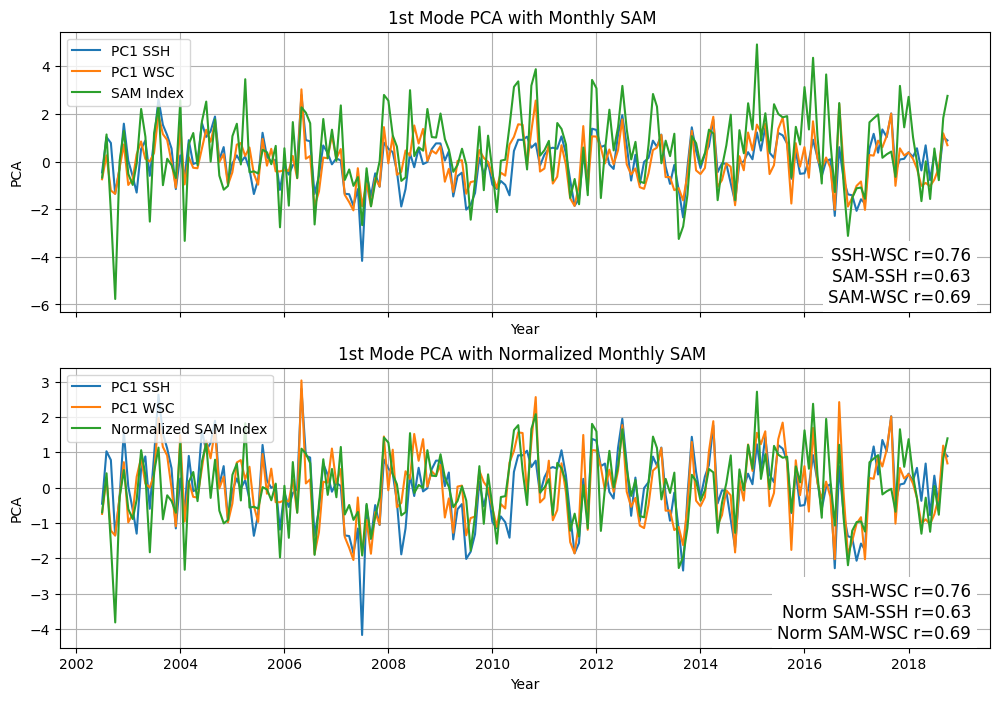

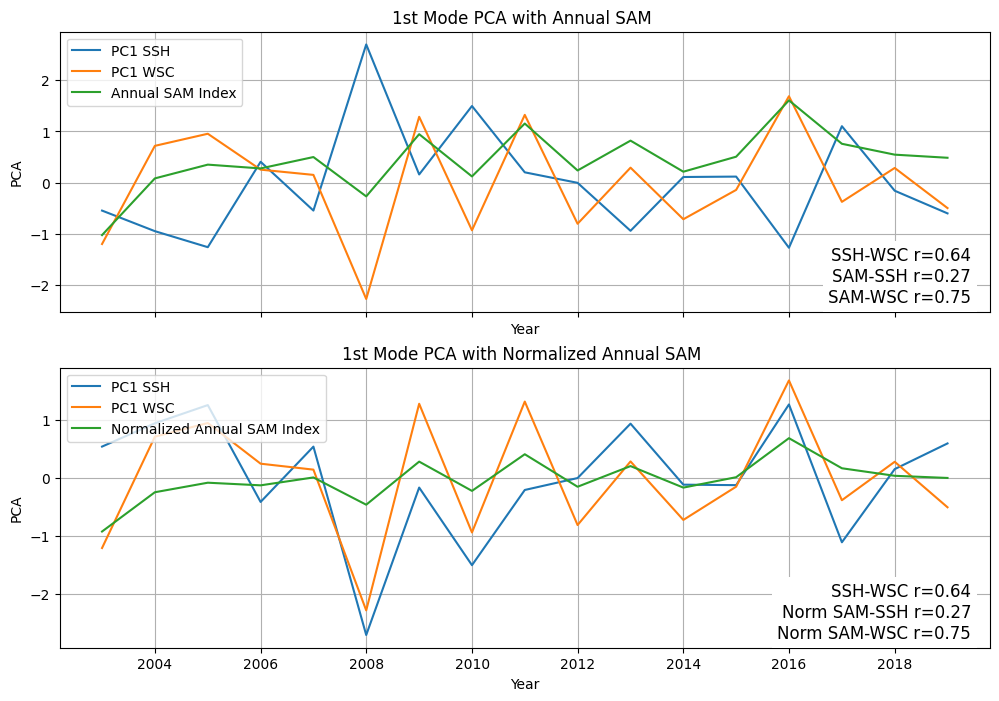

SSH
WSC
Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lat      (lat) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
SSH
WSC
16
17
<xarray.DataArray 'year' (year: 16)> Size: 128B
array([2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018])
Coordinates:
  * year     (year) int64 128B 2003 2004 2005 2006 2007 ... 2015 2016 2017 2018
16
16
16


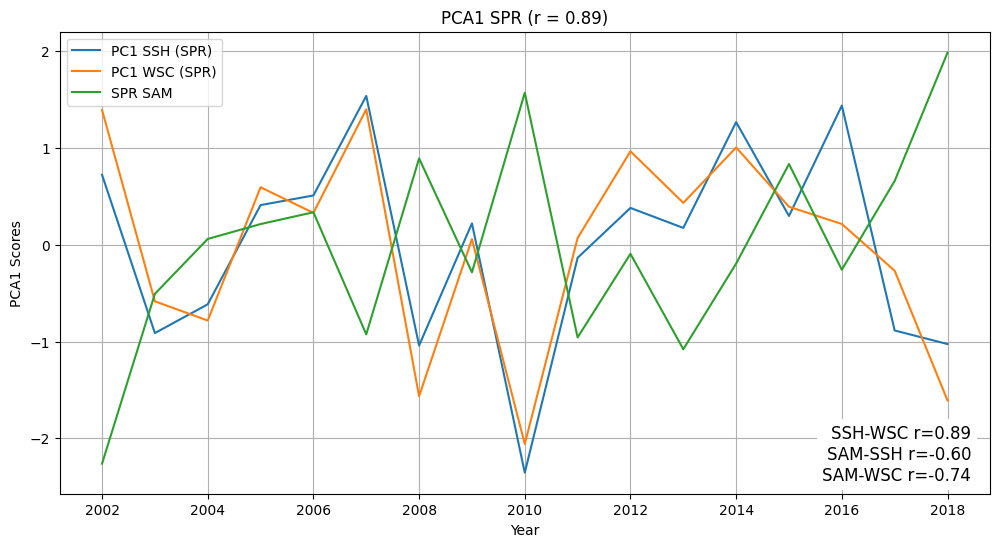

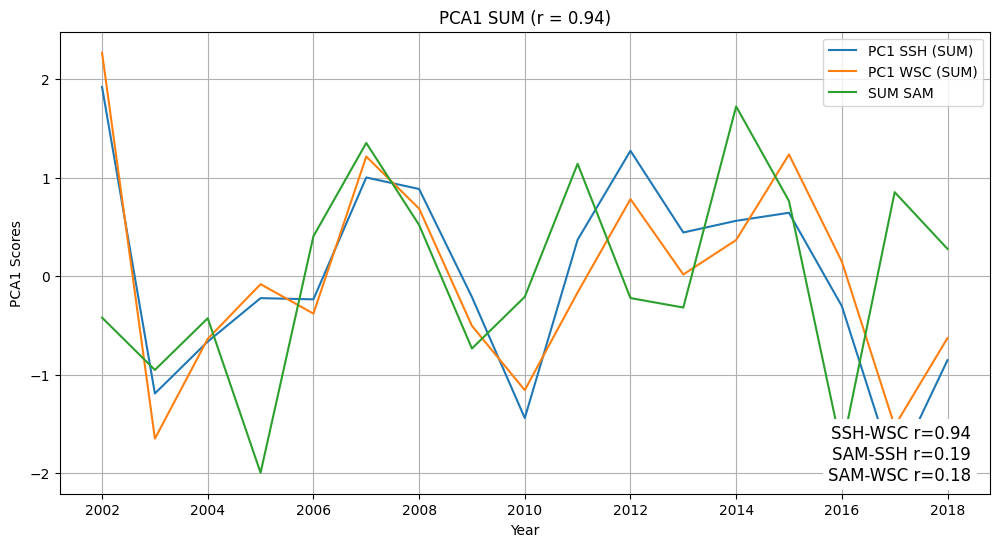

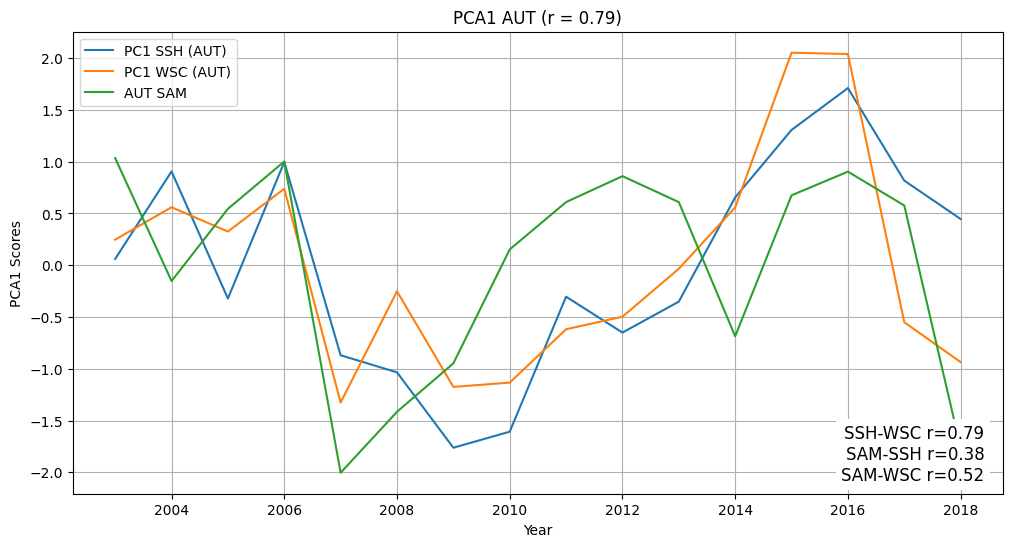

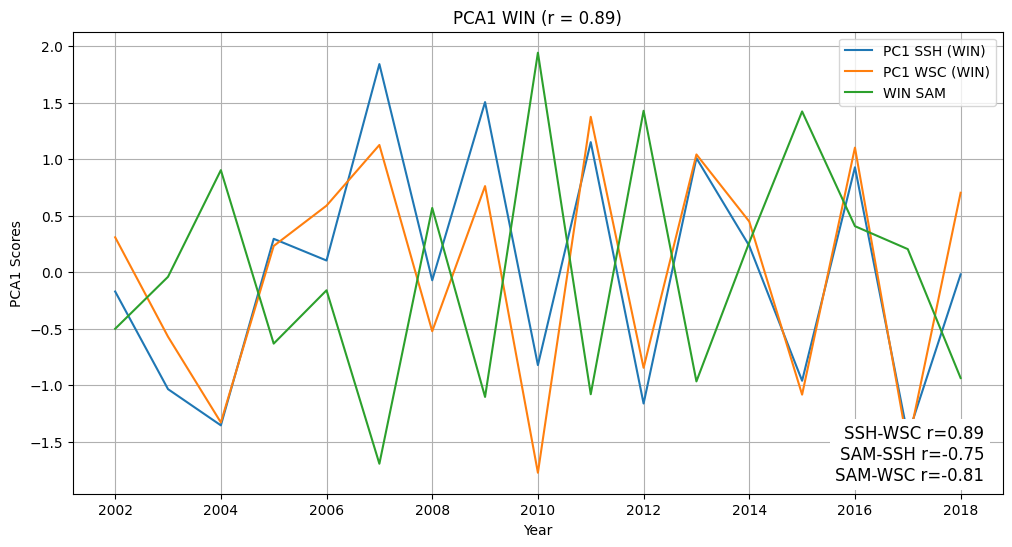

In [187]:
# 1st SVD PCA modes of time series and SAM index (monthly and seas) for SSH, WSC, OCS
path = '/Users/iw2g24/PycharmProjects/SSH_project/mca_shared_izzy/'
ds_monthly_sam = xr.open_dataset('monthly_sam.nc')
ds_seas_sam = xr.open_dataset('seas_sam.nc')
monthly_sam = ds_monthly_sam['SAM']
print(monthly_sam)
monthly_time = ds_monthly_sam['time'].values
print(len(monthly_time))

monthly_sam_start_date = 546
monthly_sam_end_date = 741
print(monthly_sam_start_date)
print(monthly_sam_end_date)

filtered_monthly_sam = monthly_sam[monthly_sam_start_date:monthly_sam_end_date + 1]

# Compute mean and standard deviation
f_monthly_sam_mean = filtered_monthly_sam.mean()
f_monthly_sam_std = filtered_monthly_sam.std()

# Normalize SAM
normalized_monthly_sam = (filtered_monthly_sam - f_monthly_sam_mean) / f_monthly_sam_std
print(normalized_monthly_sam.values)

ann_sam = ds_seas_sam['ANN_sam']
print(ann_sam)
ann_time = ds_seas_sam['ANN_time'].values
print(len(ann_time))

ann_sam_start_date = 50
ann_sam_end_date = 61
print(ann_sam_start_date)
print(ann_sam_end_date)

filtered_ann_sam = ann_sam[ann_sam_start_date:ann_sam_end_date + 1]

# Compute mean and standard deviation
f_ann_sam_mean = filtered_ann_sam.mean()
f_ann_sam_std = filtered_ann_sam.std()

# Normalize SAM
normalized_ann_sam = (filtered_ann_sam - f_ann_sam_mean) / f_ann_sam_std
print(normalized_ann_sam.values)


# Define a function to normalize SAM data for each season
def normalize_seasonal_sam(season_sam, season_time, start_date, end_date):
    filtered_season_sam = season_sam[start_date:end_date + 1]

    # Compute mean and standard deviation
    season_sam_mean = filtered_season_sam.mean()
    season_sam_std = filtered_season_sam.std()

    # Normalize SAM
    normalized_season_sam = (filtered_season_sam - season_sam_mean) / season_sam_std
    return normalized_season_sam


# Define the start and end dates for each season
season_dates = {
    "SPR": (45, 61),  # Spring start and end dates
    "WIN": (45, 61),  # Annual start and end dates
    "SUM": (45, 61),  # Summer start and end dates
    "AUT": (46, 61)  # Autumn start and end dates
}

# Assume ds_seas_sam contains the seasonal SAM data as before
seasons = ["SPR", "WIN", "SUM", "AUT"]

# Store the normalized SAM data for each season
normalized_sams = {}

for season in seasons:
    # Extract seasonal data and time
    season_sam = ds_seas_sam[f'{season}_sam']
    season_time = ds_seas_sam[f'{season}_time'].values
    start_date, end_date = season_dates[season]

    # Normalize the seasonal SAM
    normalized_sams[season] = normalize_seasonal_sam(season_sam, season_time, start_date, end_date)

# Print the normalized SAM values for each season
for season, normalized_sam in normalized_sams.items():
    print(f"Normalized {season} SAM:", normalized_sam.values)

print(ds_seas_sam['AUT_sam'][61])
print(normalized_sams['SPR'])
model = xe.cross.MCA(n_modes=22, standardize=True)
#print(dir(model))
print(dot_xa_masked.coords)
print(WSC_xa_masked.coords)

model.fit(dot_xa_masked, WSC_xa_masked, dim='time')
comps1, comps2 = model.components()  # Singular vectors (spatial patterns)
scores1, scores2 = model.scores()  # Expansion coefficients (temporal patterns)
s1 = scores1.values;
s2 = scores2.values
c1 = comps1.values;
c2 = comps2.values

#how can you change from using cross.MCA to calling the subplots PCA1, PCA2, PCA3 etc ...
r_pears = [];
p_pears = []
r_spear = [];
p_spear = []
for m in range(1, 5):
    x = scores1.sel(mode=m)
    y = scores2.sel(mode=m)
    r, p = scipy.stats.pearsonr(x, y)
    r_pears.append(np.round(r, 2));
    p_pears.append(np.round(p, 2))
    r, p = scipy.stats.spearmanr(x, y)
    r_spear.append(np.round(r, 2));
    p_spear.append(np.round(p, 2))

# Select only the first mode (PC1)
pc1_scores1 = scores1.sel(mode=1)  # First PC for SSH
pc1_scores2 = scores2.sel(mode=1)  # First PC for WSC

pc1_scores1 = (pc1_scores1 - pc1_scores1.mean()) / pc1_scores1.std()
pc1_scores2 = (pc1_scores2 - pc1_scores2.mean()) / pc1_scores2.std()

# Correlations
r_ssh_wsc, p_ssh_wsc = scipy.stats.pearsonr(pc1_scores1.values, pc1_scores2.values)
r_sam_ssh, p_sam_ssh = scipy.stats.pearsonr(filtered_monthly_sam.values, pc1_scores1.values)
r_sam_wsc, p_sam_wsc = scipy.stats.pearsonr(filtered_monthly_sam.values, pc1_scores2.values)
r_norm_sam_ssh, p_norm_sam_ssh = scipy.stats.pearsonr(normalized_monthly_sam.values, pc1_scores1.values)
r_norm_sam_wsc, p_norm_sam_wsc = scipy.stats.pearsonr(normalized_monthly_sam.values, pc1_scores2.values)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot PCA1
ax1.plot(pc1_scores1.time, pc1_scores1, label="PC1 SSH")
ax1.plot(pc1_scores2.time, pc1_scores2, label="PC1 WSC")
ax1.plot(filtered_monthly_sam.time, filtered_monthly_sam, label="SAM Index")
ax1.set_ylabel("PCA")
ax1.set_xlabel("Year")
ax1.legend(loc="upper left")
ax1.set_title("1st Mode PCA with Monthly SAM ")
ax1.grid(True)

# Add correlation text
correlation_text_1 = f"SSH-WSC r={r_ssh_wsc:.2f}\nSAM-SSH r={r_sam_ssh:.2f}\nSAM-WSC r={r_sam_wsc:.2f}"
ax1.text(0.98, 0.02, correlation_text_1, transform=ax1.transAxes, fontsize=12,
         verticalalignment='bottom', horizontalalignment='right', bbox=dict(facecolor='white', edgecolor='none'))

# Plot normalised SAM
ax2.plot(pc1_scores1.time, pc1_scores1, label="PC1 SSH")
ax2.plot(pc1_scores2.time, pc1_scores2, label="PC1 WSC")
ax2.plot(filtered_monthly_sam.time, normalized_monthly_sam, label="Normalized SAM Index")
ax2.set_ylabel("PCA")
ax2.set_xlabel("Year")
ax2.legend(loc="upper left")
ax2.set_title("1st Mode PCA with Normalized Monthly SAM ")
ax2.grid(True)

# Add correlation text for normalized SAM
correlation_text_2 = f"SSH-WSC r={r_ssh_wsc:.2f}\nNorm SAM-SSH r={r_norm_sam_ssh:.2f}\nNorm SAM-WSC r={r_norm_sam_wsc:.2f}"
ax2.text(0.98, 0.02, correlation_text_2, transform=ax2.transAxes, fontsize=12,
         verticalalignment='bottom', horizontalalignment='right', bbox=dict(facecolor='white', edgecolor='none'))

plt.show()
# Compute annual means for PC1 scores and SAM index
pc1_scores1_ann = scores1.sel(mode=1).resample(time='Y').mean()  # First PC for SSH
pc1_scores2_ann = scores2.sel(mode=1).resample(time='Y').mean()  # First PC for WSC
filtered_annual_sam = filtered_monthly_sam.resample(time='Y').mean()
normalized_annual_sam = normalized_monthly_sam.resample(time='Y').mean()

# Normalize PC1 scores
pc1_scores1_ann = (pc1_scores1_ann - pc1_scores1_ann.mean()) / pc1_scores1_ann.std()
pc1_scores2_ann = (pc1_scores2_ann - pc1_scores2_ann.mean()) / pc1_scores2_ann.std()

# Correlations using annual data
r_ssh_wsc, p_ssh_wsc = scipy.stats.pearsonr(pc1_scores1_ann.values, pc1_scores2_ann.values)
r_sam_ssh, p_sam_ssh = scipy.stats.pearsonr(filtered_annual_sam.values, pc1_scores1_ann.values)
r_sam_wsc, p_sam_wsc = scipy.stats.pearsonr(filtered_annual_sam.values, pc1_scores2_ann.values)
r_norm_sam_ssh, p_norm_sam_ssh = scipy.stats.pearsonr(normalized_annual_sam.values, pc1_scores1_ann.values)
r_norm_sam_wsc, p_norm_sam_wsc = scipy.stats.pearsonr(normalized_annual_sam.values, pc1_scores2_ann.values)

# Plot results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot PCA1 with annual SAM
ax1.plot(pc1_scores1_ann.time, -pc1_scores1_ann, label="PC1 SSH")
ax1.plot(pc1_scores2_ann.time, pc1_scores2_ann, label="PC1 WSC")
ax1.plot(filtered_annual_sam.time, filtered_annual_sam, label="Annual SAM Index")
ax1.set_ylabel("PCA")
ax1.set_xlabel("Year")
ax1.legend(loc="upper left")
ax1.set_title("1st Mode PCA with Annual SAM ")
ax1.grid(True)

# Add correlation text
correlation_text_1 = f"SSH-WSC r={r_ssh_wsc:.2f}\nSAM-SSH r={r_sam_ssh:.2f}\nSAM-WSC r={r_sam_wsc:.2f}"
ax1.text(0.98, 0.02, correlation_text_1, transform=ax1.transAxes, fontsize=12,
         verticalalignment='bottom', horizontalalignment='right', bbox=dict(facecolor='white', edgecolor='none'))

# Plot PCA1 with normalized annual SAM
ax2.plot(pc1_scores1_ann.time, pc1_scores1_ann, label="PC1 SSH")
ax2.plot(pc1_scores2_ann.time, pc1_scores2_ann, label="PC1 WSC")
ax2.plot(normalized_annual_sam.time, normalized_annual_sam, label="Normalized Annual SAM Index")
ax2.set_ylabel("PCA")
ax2.set_xlabel("Year")
ax2.legend(loc="upper left")
ax2.set_title("1st Mode PCA with Normalized Annual SAM ")
ax2.grid(True)

# Add correlation text for normalized SAM
correlation_text_2 = f"SSH-WSC r={r_ssh_wsc:.2f}\nNorm SAM-SSH r={r_norm_sam_ssh:.2f}\nNorm SAM-WSC r={r_norm_sam_wsc:.2f}"
ax2.text(0.98, 0.02, correlation_text_2, transform=ax2.transAxes, fontsize=12,
         verticalalignment='bottom', horizontalalignment='right', bbox=dict(facecolor='white', edgecolor='none'))

plt.show()

# Assign a name if missing
if dot_xa_masked.name is None:
    dot_xa_masked.name = "SSH"
if WSC_xa_masked.name is None:
    WSC_xa_masked.name = "WSC"

print(dot_xa_masked.name)
print(WSC_xa_masked.name)
print(dot_xa_masked.coords)

ssh_var = (dot_xa_masked.name)  # Get SSH variable name
wsc_var = (WSC_xa_masked.name)
print(ssh_var)
print(wsc_var)

# Define seasons based on months
seasons = {
    'SPR': [9, 10, 11],  # SON (Spring in SH)
    'SUM': [12, 1, 2],  # DJF (Summer in SH)
    'AUT': [3, 4, 5],  # MAM (Autumn in SH)
    'WIN': [6, 7, 8]  # JJA (Winter in SH)
}


def seasonal_avg(ds):
    """Compute seasonal averages for a given dataset."""
    seasonal_data = {}
    for season, months in seasons.items():
        season_ds = ds.where(ds['time'].dt.month.isin(months), drop=True)
        seasonal_mean = season_ds.groupby("time.year").mean(dim="time")
        seasonal_data[season] = seasonal_mean
    return seasonal_data


# Compute seasonal means directly
ssh_seasonal = seasonal_avg(dot_xa_masked)
wsc_seasonal = seasonal_avg(WSC_xa_masked)

# Rename for MCA analysis
spr_ann = ssh_seasonal['SPR'], wsc_seasonal['SPR']
sum_ann = ssh_seasonal['SUM'], wsc_seasonal['SUM']
aut_ann = ssh_seasonal['AUT'], wsc_seasonal['AUT']
win_ann = ssh_seasonal['WIN'], wsc_seasonal['WIN']

print(len(ssh_seasonal['AUT']))
print(len(wsc_seasonal['WIN']))

print(ssh_seasonal['AUT'].year)

print(len(ssh_seasonal['AUT']))
print(len(wsc_seasonal['AUT']))
print(len(normalized_sams['AUT']))
import scipy.stats
import matplotlib.pyplot as plt

seasons = ['SPR', 'SUM', 'AUT', 'WIN']

for season in seasons:
    # Extract seasonal data
    ssh_season = ssh_seasonal[season]
    wsc_season = wsc_seasonal[season]
    sam_season = normalized_sams[season]  # Assuming `normalized_sams` has seasonal SAM index

    # Fit the MCA model for the current season
    model = xe.cross.MCA(n_modes=4, standardize=True)
    model.fit(ssh_season, wsc_season, dim='year')
    comps1, comps2 = model.components()
    scores1, scores2 = model.scores()

    # Extract PCA1 scores for SSH and WSC
    pc1_scores1 = scores1.sel(mode=1)
    pc1_scores2 = scores2.sel(mode=1)

    # Normalize PCA1 scores
    pc1_scores1 = (pc1_scores1 - pc1_scores1.mean()) / pc1_scores1.std()
    pc1_scores2 = (pc1_scores2 - pc1_scores2.mean()) / pc1_scores2.std()

    # Compute Pearson Correlations
    r_ssh_wsc, p_ssh_wsc = scipy.stats.pearsonr(pc1_scores1.values, pc1_scores2.values)
    r_sam_ssh, p_sam_ssh = scipy.stats.pearsonr(sam_season.values, pc1_scores1.values)
    r_sam_wsc, p_sam_wsc = scipy.stats.pearsonr(sam_season.values, pc1_scores2.values)

    # Compute Spearman Correlations
    r_spear_ssh_wsc, _ = scipy.stats.spearmanr(pc1_scores1.values, pc1_scores2.values)
    r_spear_sam_ssh, _ = scipy.stats.spearmanr(sam_season.values, pc1_scores1.values)
    r_spear_sam_wsc, _ = scipy.stats.spearmanr(sam_season.values, pc1_scores2.values)

    # Plot results
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(ssh_season.year, pc1_scores1, label=f'PC1 SSH ({season})')
    ax.plot(wsc_season.year, pc1_scores2, label=f'PC1 WSC ({season})')
    ax.plot(sam_season.year, sam_season, label=f'{season} SAM')

    # Add title, labels, and grid
    ax.set_title(f'PCA1 {season} (r = {r_ssh_wsc:.2f})')
    ax.set_xlabel('Year')
    ax.set_ylabel('PCA1 Scores')
    ax.legend()
    ax.grid(True)

    # Add correlation text
    correlation_text = (f"SSH-WSC r={r_ssh_wsc:.2f}\n"
                        f"SAM-SSH r={r_sam_ssh:.2f}\n"
                        f"SAM-WSC r={r_sam_wsc:.2f}")
    ax.text(0.98, 0.02, correlation_text, transform=ax.transAxes, fontsize=12,
            verticalalignment='bottom', horizontalalignment='right', bbox=dict(facecolor='white', edgecolor='none'))

    plt.show()



In [140]:
#create xarray for tau_wsc for x and y and tau_ice_water and tau_air_water
time_steps = 196
lat_points = 64
lon_points = 360

#start_time = '2000-01-01T00:00:00.000000000'
time = ds_era5['time'][tstart_era5:tend_era5].values

# lat = ds_era5['latitude'].values
# lon = ds_era5['longitude'].values

lat = ds['latitude'].values
lon = ds['longitude'].values

tau_ds = xr.Dataset(
    {
        'tau_x_wsc': (['time', 'lat', 'lon'], tau_x_wsc),
        'tau_y_wsc': (['time', 'lat', 'lon'], tau_y_wsc),
        'tau_x_sid': (['time', 'lat', 'lon'], tau_x_sid.values),
        'tau_y_sid': (['time', 'lat', 'lon'], tau_y_sid.values),
        'tau_ice_water': (['time', 'lat', 'lon'], tau_ice_water),
        'tau_air_water': (['time', 'lat', 'lon'], tau_air_water),
    },
    coords={'time': time, 'lon': lon, 'lat': lat},
)

print(tau_ds)

<xarray.Dataset> Size: 217MB
Dimensions:        (time: 196, lat: 64, lon: 360)
Coordinates:
  * time           (time) datetime64[ns] 2kB 2002-07-01 ... 2018-10-01
  * lon            (lon) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * lat            (lat) float64 512B -81.75 -81.25 -80.75 ... -50.75 -50.25
Data variables:
    tau_x_wsc      (time, lat, lon) float64 36MB nan nan nan ... 0.1312 0.1307
    tau_y_wsc      (time, lat, lon) float64 36MB nan nan ... 0.007305 0.01033
    tau_x_sid      (time, lat, lon) float64 36MB nan nan nan nan ... nan nan nan
    tau_y_sid      (time, lat, lon) float64 36MB nan nan nan nan ... nan nan nan
    tau_ice_water  (time, lat, lon) float64 36MB nan nan ... 1.079e-07 1.101e-07
    tau_air_water  (time, lat, lon) float64 36MB nan nan nan nan ... nan nan nan


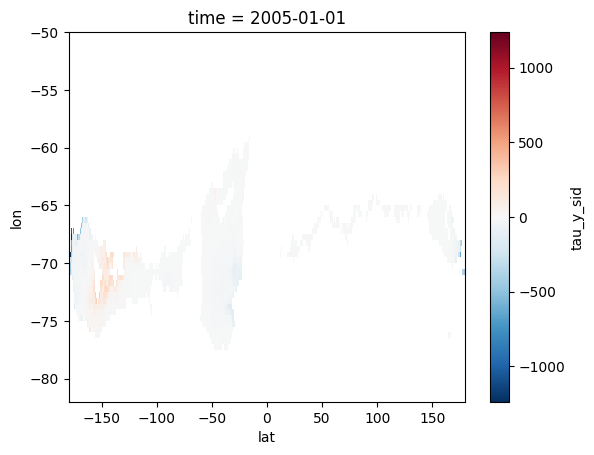

In [125]:
tau_ds['tau_y_sid'].isel(time=30).plot()

In [141]:
import os

directory = '/Users/iw2g24/PycharmProjects/SSH_project/mca_shared_izzy/'

# Function to save the file if it doesn't exist, or print a message if it does
def save_to_netcdf(data_array, file_path):
    if os.path.exists(file_path):
        print(f"File already exists: {file_path}")
    else:
        data_array.to_netcdf(file_path)
        print(f"Saved to: {file_path}")

# Saving the files
save_to_netcdf(dot_xa_masked, directory + 'dot_masked_v2.nc')
save_to_netcdf(tau_ds, directory + 'tau_nsidc_ds_v3.nc')
save_to_netcdf(sid_curl_xa_masked, directory + 'sidc_nsidc_masked_v2.nc')
save_to_netcdf(WSC_xa_masked, directory + 'WSC_nsidc_masked_v2.nc')


File already exists: /Users/iw2g24/PycharmProjects/SSH_project/mca_shared_izzy/dot_masked_v2.nc
Saved to: /Users/iw2g24/PycharmProjects/SSH_project/mca_shared_izzy/tau_nsidc_ds_v3.nc
File already exists: /Users/iw2g24/PycharmProjects/SSH_project/mca_shared_izzy/sidc_nsidc_masked_v2.nc
File already exists: /Users/iw2g24/PycharmProjects/SSH_project/mca_shared_izzy/WSC_nsidc_masked_v2.nc


In [127]:
# directory = '/Users/iw2g24/PycharmProjects/SSH_project/mca_shared_izzy/'
# dot_xa_masked.to_netcdf(directory+'dot_masked.nc')
# tau_ds.to_netcdf(directory+'tau_nsidc_ds.nc')
# sid_curl_xa_masked.to_netcdf(directory+'sidc_nsidc_masked.nc')
# WSC_xa_masked.to_netcdf(directory+'WSC_nsidc_masked.nc')
# dot_xa_masked.to_netcdf(directory+'dot_masked.nc')